# LSTM Time Series Forecasting for Sales Prediction

This notebook implements LSTM models for forecasting weekly sales across different product categories. Each category gets its own trained model with proper preprocessing, evaluation, and saving capabilities.

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0
NumPy version: 1.26.4
Pandas version: 2.2.3


In [13]:
# Load and explore the dataset
def load_and_explore_data(filepath):
    """
    Load the dataset and perform initial exploration
    
    Args:
        filepath (str): Path to the CSV file
    
    Returns:
        pd.DataFrame: Loaded dataset
    """
    df = pd.read_csv(filepath)
    
    print("Dataset Shape:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())
    
    print("\nDataset Info:")
    print(df.info())
    
    print("\nCategories and their counts:")
    print(df['category'].value_counts())
    
    print("\nMissing values:")
    print(df.isnull().sum())
    
    print("\nBasic statistics:")
    print(df.describe())
    
    return df

# Load the data
df = load_and_explore_data('dummy_forecasting_dataset.csv')

Dataset Shape: (2548, 8)

First 5 rows:
   week    category  sku_count  brand_count  weekly_sales  promo_active  \
0     1  Susu Bubuk         86           14           609         False   
1     2  Susu Bubuk         86           14           555         False   
2     3  Susu Bubuk         86           14           590         False   
3     4  Susu Bubuk         86           14           652          True   
4     5  Susu Bubuk         86           14           568         False   

   normal_price  promo_price  
0         16964          NaN  
1         16964          NaN  
2         16964          NaN  
3         16964      22700.0  
4         16964          NaN  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2548 entries, 0 to 2547
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   week          2548 non-null   int64  
 1   category      2548 non-null   object 
 2   sku_count     2548 non-nu

In [14]:
# Data preprocessing function
def preprocess_data(df):
    """
    Preprocess the dataset:
    - Handle missing values
    - Sort by category and week
    - Convert data types
    
    Args:
        df (pd.DataFrame): Raw dataset
    
    Returns:
        pd.DataFrame: Preprocessed dataset
    """
    # Make a copy to avoid modifying original data
    df_processed = df.copy()
    
    # Convert promo_active to numeric (0 for False, 1 for True)
    df_processed['promo_active'] = df_processed['promo_active'].astype(int)
    
    # Handle missing values in promo_price
    # Fill with normal_price when promo is not active, forward fill otherwise
    df_processed['promo_price'] = df_processed['promo_price'].fillna(df_processed['normal_price'])
    
    # Sort by category and week to ensure proper time series order
    df_processed = df_processed.sort_values(['category', 'week']).reset_index(drop=True)
    
    print("Data preprocessing completed!")
    print(f"Shape after preprocessing: {df_processed.shape}")
    print(f"Missing values after preprocessing: {df_processed.isnull().sum().sum()}")
    
    return df_processed

# Preprocess the data
df_processed = preprocess_data(df)

Data preprocessing completed!
Shape after preprocessing: (2548, 8)
Missing values after preprocessing: 0


In [ ]:
# LSTM data preparation function - UPDATED for specific features
def prepare_data_for_lstm(df, category, lookback=8):
    """
    Prepare data for LSTM training for a specific category
    Uses only: week, category, promo_active, normal_price, promo_price
    
    Args:
        df (pd.DataFrame): Preprocessed dataset
        category (str): Product category to filter
        lookback (int): Number of previous weeks to use as input
    
    Returns:
        tuple: (X_train, X_test, y_train, y_test, scaler_X, scaler_y)
    """
    # Filter data for the specific category
    category_data = df[df['category'] == category].copy()
    category_data = category_data.sort_values('week').reset_index(drop=True)
    
    print(f"Processing category: {category}")
    print(f"Data points for {category}: {len(category_data)}")
    
    # UPDATED: Select only specified features for modeling
    feature_columns = ['week', 'promo_active', 'normal_price', 'promo_price']
    target_column = 'weekly_sales'
    
    print(f"Using features: {feature_columns}")
    print(f"Target variable: {target_column}")
    
    # Extract features and target
    features = category_data[feature_columns].values
    target = category_data[target_column].values.reshape(-1, 1)
    
    # Initialize scalers
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Fit and transform features and target
    features_scaled = scaler_X.fit_transform(features)
    target_scaled = scaler_y.fit_transform(target)
    
    # Create sequences for LSTM
    X, y = [], []
    
    for i in range(lookback, len(features_scaled)):
        X.append(features_scaled[i-lookback:i])
        y.append(target_scaled[i])
    
    X = np.array(X)
    y = np.array(y)
    
    print(f"Sequence shape: X={X.shape}, y={y.shape}")
    print(f"Features per timestep: {X.shape[2]} (should be {len(feature_columns)})")
    
    # Check if we have enough data
    if len(X) < 10:
        raise ValueError(f"Not enough data for category {category}. Need at least {lookback + 10} weeks.")
    
    # Split into train and test (80-20 split)
    split_idx = int(0.8 * len(X))
    
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    print(f"Train set: X={X_train.shape}, y={y_train.shape}")
    print(f"Test set: X={X_test.shape}, y={y_test.shape}")
    
    return X_train, X_test, y_train, y_test, scaler_X, scaler_y

In [16]:
# LSTM model building function
def build_lstm_model(input_shape):
    """
    Build LSTM model architecture
    
    Args:
        input_shape (tuple): Shape of input sequences (timesteps, features)
    
    Returns:
        tensorflow.keras.Model: Compiled LSTM model
    """
    model = Sequential([
        # First LSTM layer with return_sequences=True
        LSTM(64, return_sequences=True, input_shape=input_shape, name='lstm_1'),
        Dropout(0.2, name='dropout_1'),
        
        # Second LSTM layer
        LSTM(32, return_sequences=False, name='lstm_2'),
        Dropout(0.2, name='dropout_2'),
        
        # Dense layers for regression
        Dense(16, activation='relu', name='dense_1'),
        Dropout(0.1, name='dropout_3'),
        Dense(1, activation='linear', name='output')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [17]:
# Evaluation metrics function
def calculate_metrics(y_true, y_pred):
    """
    Calculate evaluation metrics
    
    Args:
        y_true (np.array): True values
        y_pred (np.array): Predicted values
    
    Returns:
        dict: Dictionary containing MSE, RMSE, MAE, MAPE
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    # Avoid division by zero
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Plotting function
def plot_predictions(y_true, y_pred, category, save_path):
    """
    Plot actual vs predicted values
    
    Args:
        y_true (np.array): True values
        y_pred (np.array): Predicted values
        category (str): Category name for title
        save_path (str): Path to save the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Plot actual vs predicted
    plt.subplot(1, 2, 1)
    plt.plot(y_true, label='Actual', marker='o', alpha=0.7)
    plt.plot(y_pred, label='Predicted', marker='s', alpha=0.7)
    plt.title(f'{category} - Actual vs Predicted Sales')
    plt.xlabel('Time (Test Period)')
    plt.ylabel('Weekly Sales (Scaled)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Scatter plot
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Sales (Scaled)')
    plt.ylabel('Predicted Sales (Scaled)')
    plt.title(f'{category} - Correlation Plot')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Plot saved to: {save_path}")

In [18]:
# Main training and evaluation function
def train_and_evaluate_model(df, category, lookback=8, epochs=100, patience=10):
    """
    Train and evaluate LSTM model for a specific category
    
    Args:
        df (pd.DataFrame): Preprocessed dataset
        category (str): Product category
        lookback (int): Number of previous weeks to use as input
        epochs (int): Maximum number of training epochs
        patience (int): Early stopping patience
    
    Returns:
        dict: Results including model, scalers, and metrics
    """
    print(f"\n{'='*60}")
    print(f"Training LSTM model for category: {category}")
    print(f"{'='*60}")
    
    try:
        # Prepare data
        X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_data_for_lstm(
            df, category, lookback
        )
        
        # Build model
        input_shape = (X_train.shape[1], X_train.shape[2])
        model = build_lstm_model(input_shape)
        
        print(f"\nModel architecture for {category}:")
        model.summary()
        
        # Set up early stopping
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        )
        
        # Train model
        print(f"\nTraining model for {category}...")
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=16,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
        
        # Make predictions
        y_pred_train = model.predict(X_train, verbose=0)
        y_pred_test = model.predict(X_test, verbose=0)
        
        # Calculate metrics
        train_metrics = calculate_metrics(y_train, y_pred_train)
        test_metrics = calculate_metrics(y_test, y_pred_test)
        
        print(f"\n{category} - Training Metrics:")
        for metric, value in train_metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        print(f"\n{category} - Test Metrics:")
        for metric, value in test_metrics.items():
            print(f"  {metric}: {value:.4f}")
        
        # Create directories if they don't exist
        os.makedirs('models', exist_ok=True)
        os.makedirs('results/plots', exist_ok=True)
        
        # Save model
        model_path = f'models/lstm_model_{category}.h5'
        model.save(model_path)
        print(f"\nModel saved to: {model_path}")
        
        # Save scalers
        scaler_X_path = f'models/scaler_X_{category}.pkl'
        scaler_y_path = f'models/scaler_y_{category}.pkl'
        
        with open(scaler_X_path, 'wb') as f:
            pickle.dump(scaler_X, f)
        with open(scaler_y_path, 'wb') as f:
            pickle.dump(scaler_y, f)
        
        print(f"Scalers saved to: {scaler_X_path}, {scaler_y_path}")
        
        # Plot predictions
        plot_path = f'results/plots/{category}_predictions.png'
        plot_predictions(y_test, y_pred_test, category, plot_path)
        
        return {
            'category': category,
            'model': model,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'history': history,
            'train_metrics': train_metrics,
            'test_metrics': test_metrics,
            'y_test': y_test,
            'y_pred_test': y_pred_test
        }
        
    except Exception as e:
        print(f"Error training model for {category}: {str(e)}")
        return None

Starting LSTM model training for all categories...
Found 49 categories: ['Air Mineral', 'Beras', 'Bihun', 'Biskuit', 'Buah Kering', 'Buah-Buahan', 'Cokelat', 'Daging Segar', 'Garam', 'Gula', 'Gulali', 'Ice Cream', 'Jus Kemasan', 'Kacang', 'Kaldu Jamur', 'Kecap', 'Keju', 'Kentang Goreng', 'Keripik', 'Kopi Bubuk', 'Kopi Kemasan', 'Kornet', 'Krim', 'Kuaci', 'Makaroni', 'Marshmallow', 'Mayones', 'Mentega', 'Mie Instan', 'Minuman Isotonik', 'Minyak Goreng', 'Nugget', 'Pasta', 'Penyedap Rasa', 'Permen', 'Roti', 'Saos', 'Sarden Kaleng', 'Sayur-Sayuran', 'Seafood Segar', 'Selai', 'Sereal', 'Sirup', 'Soda', 'Susu Bubuk', 'Susu Kemasan', 'Teh', 'Telur', 'Yogurt']
Training parameters: lookback=8, epochs=100, patience=10

Training LSTM model for category: Air Mineral
Processing category: Air Mineral
Data points for Air Mineral: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Air Mineral:

Model architecture for A

Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Air Mineral...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - loss: 0.2784 - mae: 0.4934 - val_loss: 0.2415 - val_mae: 0.4630
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - loss: 0.2784 - mae: 0.4934 - val_loss: 0.2415 - val_mae: 0.4630
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1892 - mae: 0.3976 - val_loss: 0.1543 - val_mae: 0.3556
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.1892 - mae: 0.3976 - val_loss: 0.1543 - val_mae: 0.3556
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0893 - mae: 0.2576 - val_loss: 0.0833 - val_mae: 0.2641
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0893 - mae: 0.2576 - val_loss: 0.0833 - val_mae: 0.2641
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0785 - mae: 0.2283 - val_loss: 0.0407 - val_mae: 0.1797
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0785 - mae: 0.2283 - val_loss: 0.0407 - val_mae: 0.1797
Epoch 5/100
2/2 ━━━━━━━


Air Mineral - Training Metrics:
  MSE: 0.0499
  RMSE: 0.2234
  MAE: 0.1736
  MAPE: 31.9460

Air Mineral - Test Metrics:
  MSE: 0.0535
  RMSE: 0.2314
  MAE: 0.2065
  MAPE: 38.8663

Model saved to: models/lstm_model_Air Mineral.h5
Scalers saved to: models/scaler_X_Air Mineral.pkl, models/scaler_y_Air Mineral.pkl


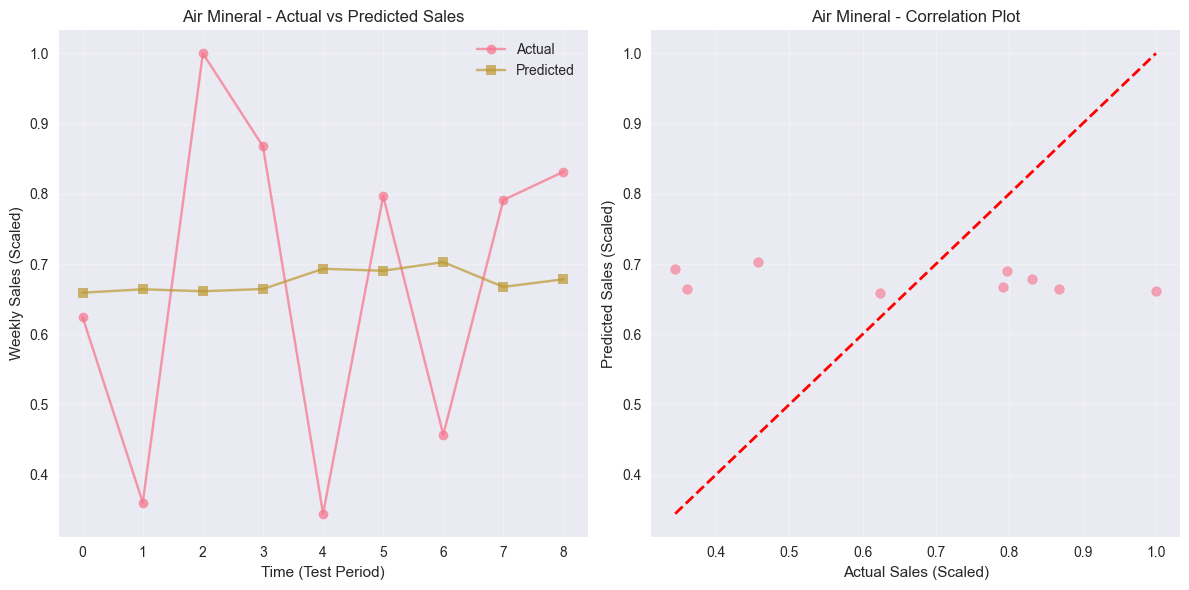

Plot saved to: results/plots/Air Mineral_predictions.png

Training LSTM model for category: Beras
Processing category: Beras
Data points for Beras: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Beras:


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Beras...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - loss: 0.3420 - mae: 0.5446 - val_loss: 0.3020 - val_mae: 0.5236
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - loss: 0.3420 - mae: 0.5446 - val_loss: 0.3020 - val_mae: 0.5236
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2631 - mae: 0.4770 - val_loss: 0.2188 - val_mae: 0.4368
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.2631 - mae: 0.4770 - val_loss: 0.2188 - val_mae: 0.4368
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2078 - mae: 0.4127 - val_loss: 0.1403 - val_mae: 0.3357
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2078 - mae: 0.4127 - val_loss: 0.1403 - val_mae: 0.3357
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1250 - mae: 0.3162 - val_loss: 0.0769 - val_mae: 0.2421
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.1250 - mae: 0.3162 - val_loss: 0.0769 - val_mae: 0.2421
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6


Beras - Training Metrics:
  MSE: 0.0373
  RMSE: 0.1931
  MAE: 0.1471
  MAPE: 28.9354

Beras - Test Metrics:
  MSE: 0.0533
  RMSE: 0.2308
  MAE: 0.1724
  MAPE: 216.0591

Model saved to: models/lstm_model_Beras.h5
Scalers saved to: models/scaler_X_Beras.pkl, models/scaler_y_Beras.pkl


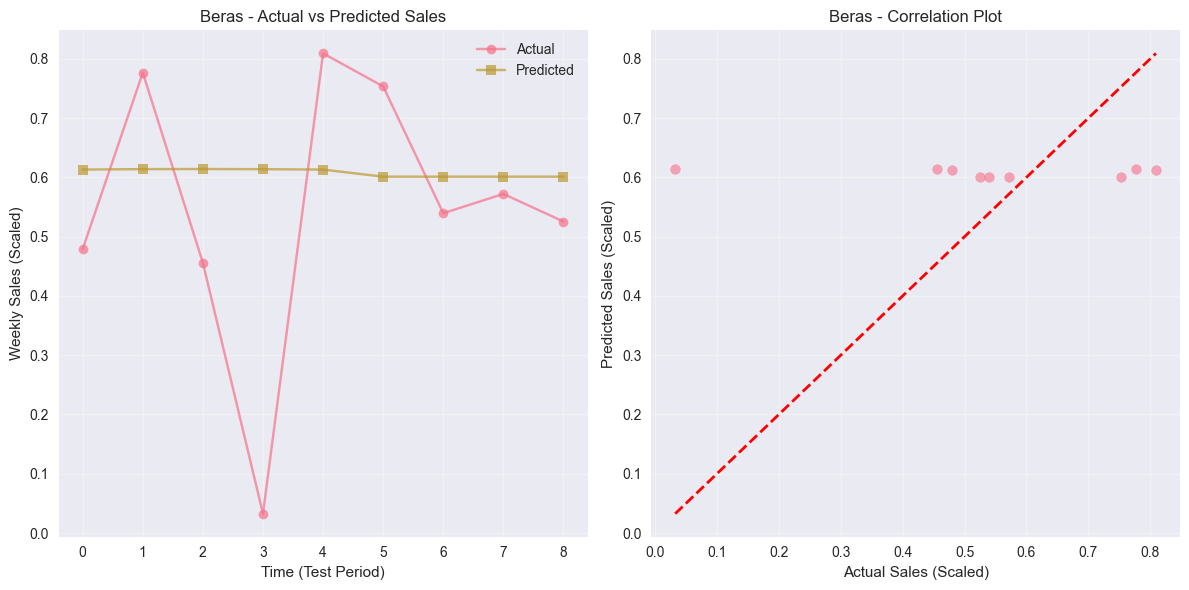

Plot saved to: results/plots/Beras_predictions.png

Training LSTM model for category: Bihun
Processing category: Bihun
Data points for Bihun: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Bihun:


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Bihun...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - loss: 0.4080 - mae: 0.6052 - val_loss: 0.3291 - val_mae: 0.5690
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - loss: 0.4080 - mae: 0.6052 - val_loss: 0.3291 - val_mae: 0.5690
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3651 - mae: 0.5674 - val_loss: 0.3080 - val_mae: 0.5502
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.3651 - mae: 0.5674 - val_loss: 0.3080 - val_mae: 0.5502
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.3402 - mae: 0.5444 - val_loss: 0.2815 - val_mae: 0.5255
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.3402 - mae: 0.5444 - val_loss: 0.2815 - val_mae: 0.5255
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.3049 - mae: 0.5081 - val_loss: 0.2502 - val_mae: 0.4949
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.3049 - mae: 0.5081 - val_loss: 0.2502 - val_mae: 0.4949
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7


Bihun - Training Metrics:
  MSE: 0.0337
  RMSE: 0.1836
  MAE: 0.1556
  MAPE: 31.8861

Bihun - Test Metrics:
  MSE: 0.0467
  RMSE: 0.2160
  MAE: 0.1755
  MAPE: 58.4165

Model saved to: models/lstm_model_Bihun.h5
Scalers saved to: models/scaler_X_Bihun.pkl, models/scaler_y_Bihun.pkl


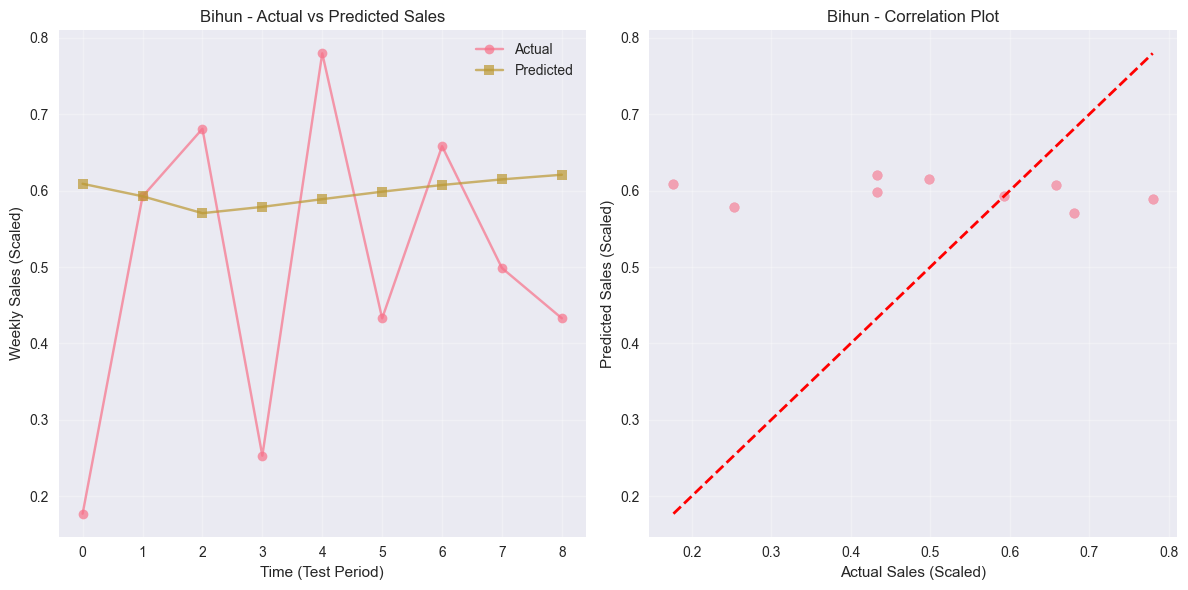

Plot saved to: results/plots/Bihun_predictions.png

Training LSTM model for category: Biskuit
Processing category: Biskuit
Data points for Biskuit: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Biskuit:


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Biskuit...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - loss: 0.3594 - mae: 0.5575 - val_loss: 0.2375 - val_mae: 0.4686
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - loss: 0.3594 - mae: 0.5575 - val_loss: 0.2375 - val_mae: 0.4686
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3158 - mae: 0.5199 - val_loss: 0.2200 - val_mae: 0.4496
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.3158 - mae: 0.5199 - val_loss: 0.2200 - val_mae: 0.4496
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2928 - mae: 0.4996 - val_loss: 0.1965 - val_mae: 0.4226
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2928 - mae: 0.4996 - val_loss: 0.1965 - val_mae: 0.4226
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2633 - mae: 0.4716 - val_loss: 0.1652 - val_mae: 0.3837
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.2633 - mae: 0.4716 - val_loss: 0.1652 - val_mae: 0.3837
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s


Biskuit - Training Metrics:
  MSE: 0.0342
  RMSE: 0.1850
  MAE: 0.1446
  MAPE: 29.8594

Biskuit - Test Metrics:
  MSE: 0.0518
  RMSE: 0.2275
  MAE: 0.1733
  MAPE: 54.9054

Model saved to: models/lstm_model_Biskuit.h5
Scalers saved to: models/scaler_X_Biskuit.pkl, models/scaler_y_Biskuit.pkl


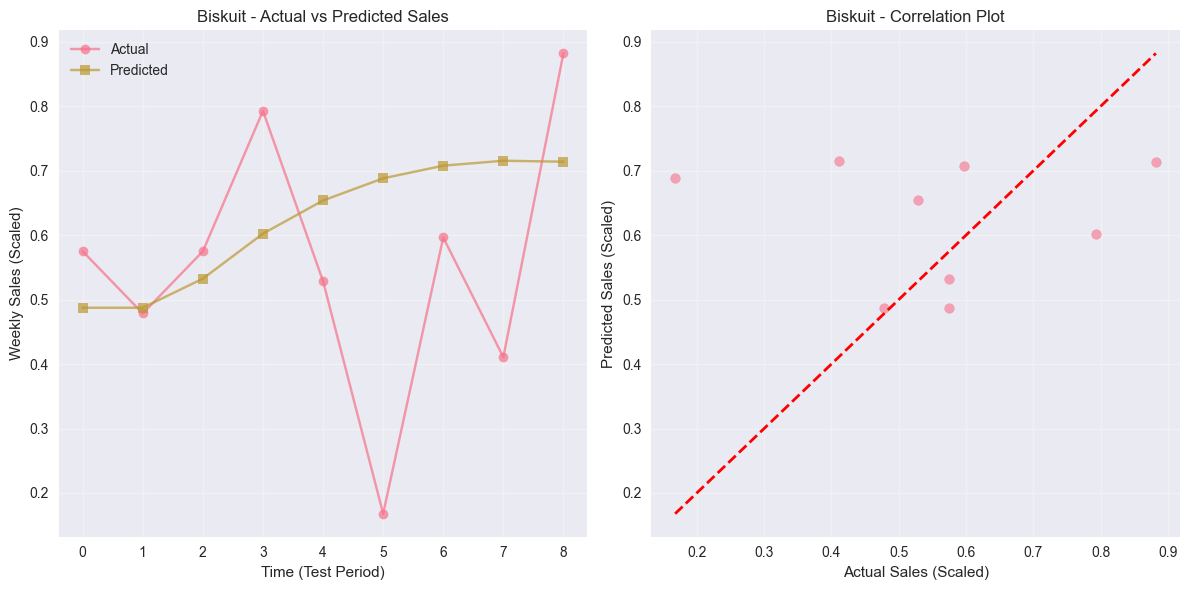

Plot saved to: results/plots/Biskuit_predictions.png

Training LSTM model for category: Buah Kering
Processing category: Buah Kering
Data points for Buah Kering: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Buah Kering:


Model: "sequential_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Buah Kering...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - loss: 0.2822 - mae: 0.4814 - val_loss: 0.4615 - val_mae: 0.6381
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - loss: 0.2822 - mae: 0.4814 - val_loss: 0.4615 - val_mae: 0.6381
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2410 - mae: 0.4429 - val_loss: 0.4128 - val_mae: 0.5987
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.2410 - mae: 0.4429 - val_loss: 0.4128 - val_mae: 0.5987
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2192 - mae: 0.4184 - val_loss: 0.3540 - val_mae: 0.5472
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.2192 - mae: 0.4184 - val_loss: 0.3540 - val_mae: 0.5472
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1711 - mae: 0.3694 - val_loss: 0.2924 - val_mae: 0.4875
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.1711 - mae: 0.3694 - val_loss: 0.2924 - val_mae: 0.4875
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━


Buah Kering - Training Metrics:
  MSE: 0.0606
  RMSE: 0.2462
  MAE: 0.1911
  MAPE: 117.3404

Buah Kering - Test Metrics:
  MSE: 0.0510
  RMSE: 0.2259
  MAE: 0.1703
  MAPE: 33.0949

Model saved to: models/lstm_model_Buah Kering.h5
Scalers saved to: models/scaler_X_Buah Kering.pkl, models/scaler_y_Buah Kering.pkl


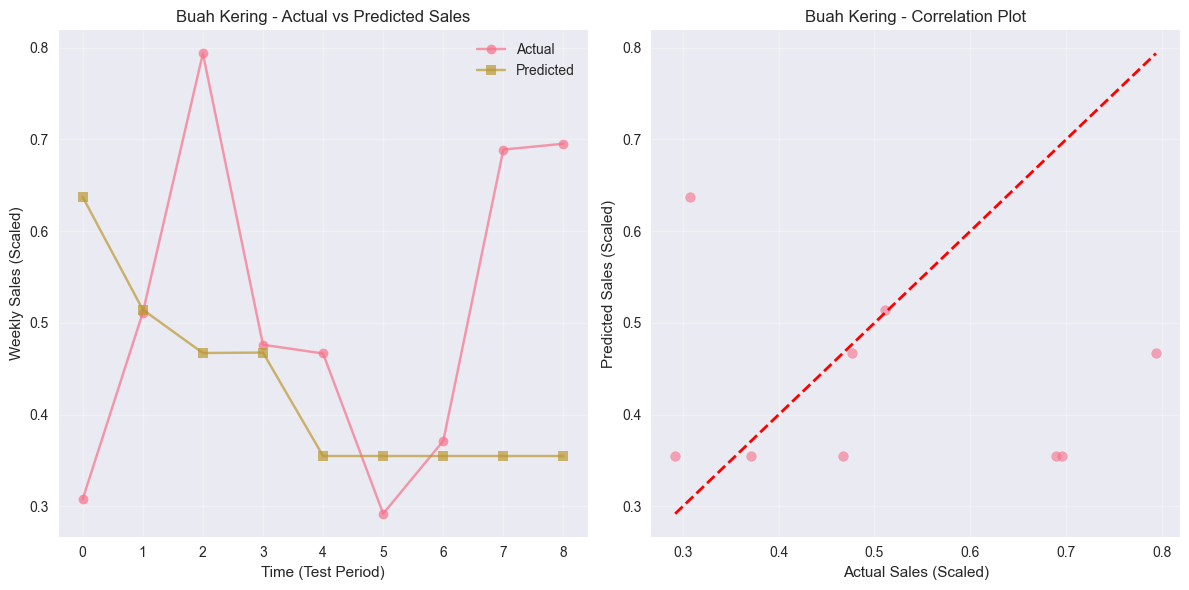

Plot saved to: results/plots/Buah Kering_predictions.png

Training LSTM model for category: Buah-Buahan
Processing category: Buah-Buahan
Data points for Buah-Buahan: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Buah-Buahan:


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Buah-Buahan...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.4040 - mae: 0.5975 - val_loss: 0.2586 - val_mae: 0.4337
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.4040 - mae: 0.5975 - val_loss: 0.2586 - val_mae: 0.4337
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.3018 - mae: 0.5078 - val_loss: 0.2180 - val_mae: 0.3840
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.3018 - mae: 0.5078 - val_loss: 0.2180 - val_mae: 0.3840
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.2525 - mae: 0.4593 - val_loss: 0.1951 - val_mae: 0.3616
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - loss: 0.2525 - mae: 0.4593 - val_loss: 0.1951 - val_mae: 0.3616
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2198 - mae: 0.4188 - val_loss: 0.1699 - val_mae: 0.3347
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2198 - mae: 0.4188 - val_loss: 0.1699 - val_mae: 0.3347
Epoch 5/100
2/2 ━━━━━


Buah-Buahan - Training Metrics:
  MSE: 0.0490
  RMSE: 0.2214
  MAE: 0.1942
  MAPE: 55.5469

Buah-Buahan - Test Metrics:
  MSE: 0.1065
  RMSE: 0.3263
  MAE: 0.2786
  MAPE: 37.9264

Model saved to: models/lstm_model_Buah-Buahan.h5
Scalers saved to: models/scaler_X_Buah-Buahan.pkl, models/scaler_y_Buah-Buahan.pkl


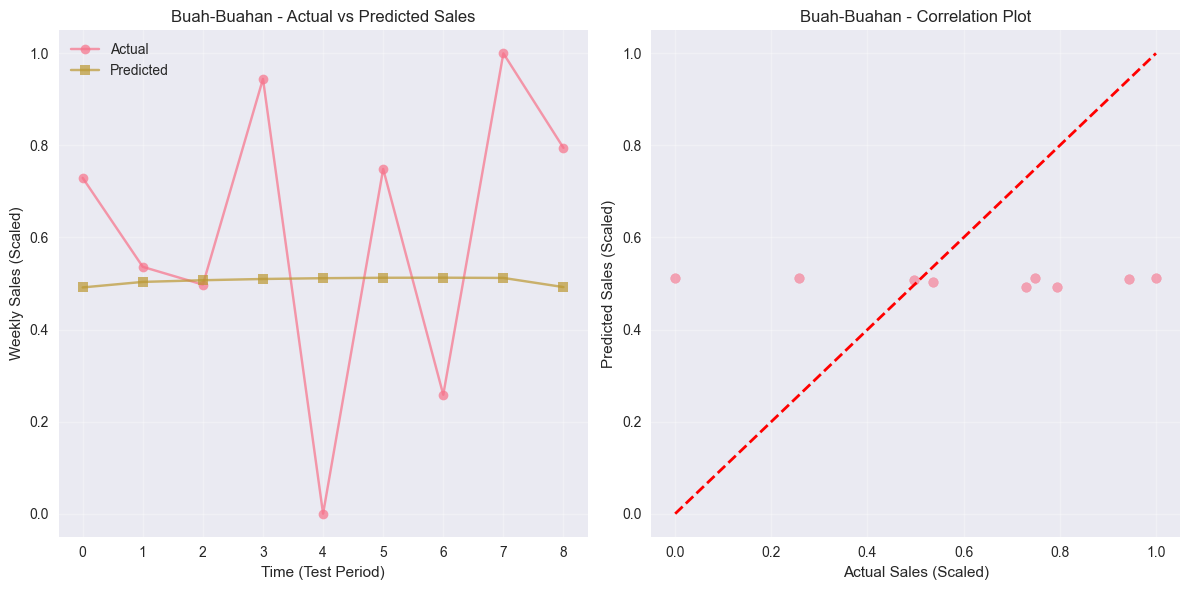

Plot saved to: results/plots/Buah-Buahan_predictions.png

Training LSTM model for category: Cokelat
Processing category: Cokelat
Data points for Cokelat: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Cokelat:

Model architecture for Cokelat:


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Cokelat...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.3615 - mae: 0.5694 - val_loss: 0.3173 - val_mae: 0.5346
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.3615 - mae: 0.5694 - val_loss: 0.3173 - val_mae: 0.5346
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2698 - mae: 0.4879 - val_loss: 0.2351 - val_mae: 0.4512
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.2698 - mae: 0.4879 - val_loss: 0.2351 - val_mae: 0.4512
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.2069 - mae: 0.4157 - val_loss: 0.1887 - val_mae: 0.3965
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.2069 - mae: 0.4157 - val_loss: 0.1887 - val_mae: 0.3965
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1700 - mae: 0.3756 - val_loss: 0.1404 - val_mae: 0.3300
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1700 - mae: 0.3756 - val_loss: 0.1404 - val_mae: 0.3300
Epoch 5/100
2/2 ━━━━━━━━━━━


Cokelat - Training Metrics:
  MSE: 0.0399
  RMSE: 0.1998
  MAE: 0.1580
  MAPE: 32.1963

Cokelat - Test Metrics:
  MSE: 0.0530
  RMSE: 0.2303
  MAE: 0.1989
  MAPE: 47.0982

Model saved to: models/lstm_model_Cokelat.h5
Scalers saved to: models/scaler_X_Cokelat.pkl, models/scaler_y_Cokelat.pkl

Model saved to: models/lstm_model_Cokelat.h5
Scalers saved to: models/scaler_X_Cokelat.pkl, models/scaler_y_Cokelat.pkl


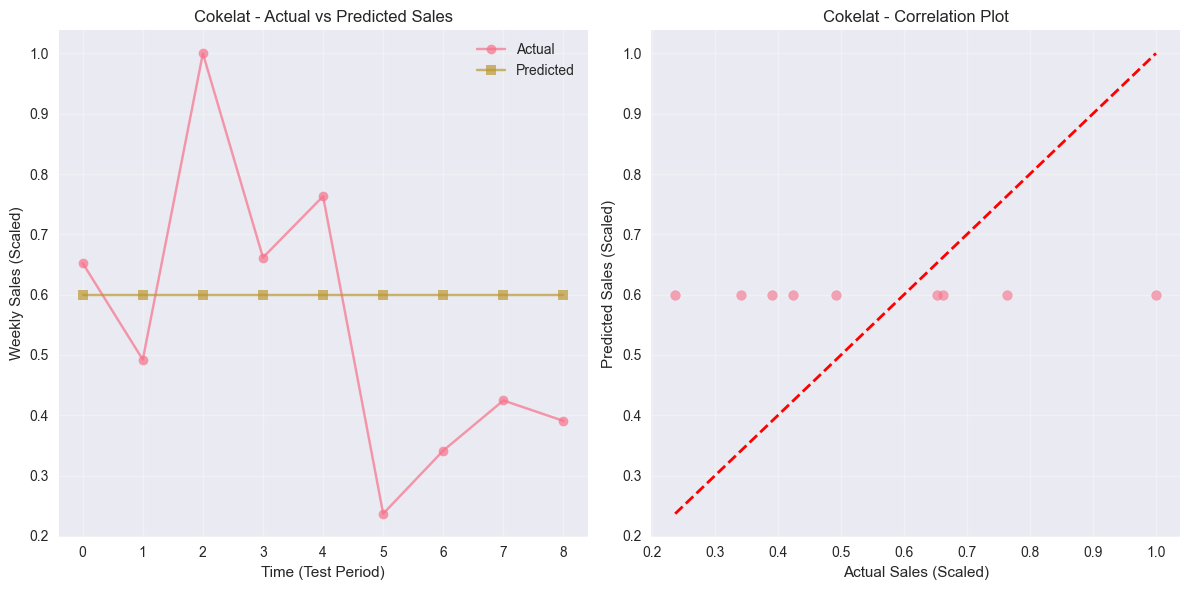

Plot saved to: results/plots/Cokelat_predictions.png

Training LSTM model for category: Daging Segar
Processing category: Daging Segar
Data points for Daging Segar: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Daging Segar:

Model architecture for Daging Segar:


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Daging Segar...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.4297 - mae: 0.6072 - val_loss: 0.5725 - val_mae: 0.7386
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.4297 - mae: 0.6072 - val_loss: 0.5725 - val_mae: 0.7386
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.3186 - mae: 0.5069 - val_loss: 0.5068 - val_mae: 0.6925
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.3186 - mae: 0.5069 - val_loss: 0.5068 - val_mae: 0.6925
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2716 - mae: 0.4621 - val_loss: 0.4726 - val_mae: 0.6672
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2716 - mae: 0.4621 - val_loss: 0.4726 - val_mae: 0.6672
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2536 - mae: 0.4444 - val_loss: 0.4411 - val_mae: 0.6430
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2536 - mae: 0.4444 - val_loss: 0.4411 - val_mae: 0.6430
Epoch 5/100
2/2 ━━━━━━


Daging Segar - Training Metrics:
  MSE: 0.0707
  RMSE: 0.2660
  MAE: 0.2112
  MAPE: 74.7035

Daging Segar - Test Metrics:
  MSE: 0.0478
  RMSE: 0.2187
  MAE: 0.1981
  MAPE: 51.1972

Model saved to: models/lstm_model_Daging Segar.h5
Scalers saved to: models/scaler_X_Daging Segar.pkl, models/scaler_y_Daging Segar.pkl

Model saved to: models/lstm_model_Daging Segar.h5
Scalers saved to: models/scaler_X_Daging Segar.pkl, models/scaler_y_Daging Segar.pkl


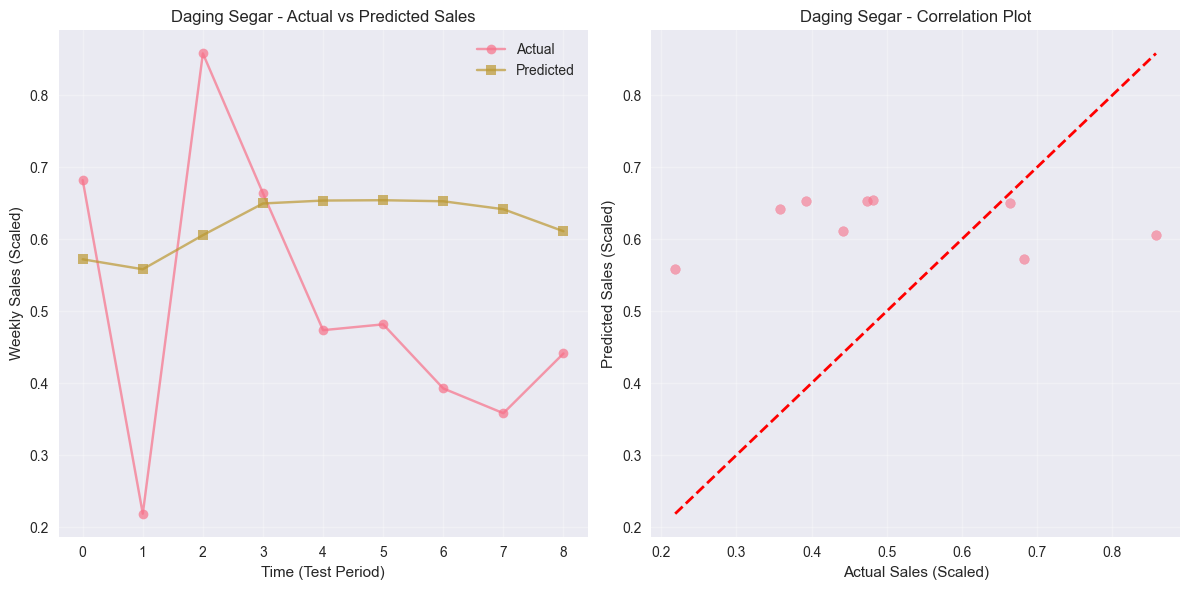

Plot saved to: results/plots/Daging Segar_predictions.png

Training LSTM model for category: Garam
Processing category: Garam
Data points for Garam: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Garam:

Model architecture for Garam:


Model: "sequential_57"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Garam...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 950ms/step - loss: 0.3253 - mae: 0.5179 - val_loss: 0.2139 - val_mae: 0.4363
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 950ms/step - loss: 0.3253 - mae: 0.5179 - val_loss: 0.2139 - val_mae: 0.4363
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.2934 - mae: 0.4864 - val_loss: 0.2026 - val_mae: 0.4233
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 172ms/step - loss: 0.2934 - mae: 0.4864 - val_loss: 0.2026 - val_mae: 0.4233
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2809 - mae: 0.4721 - val_loss: 0.1916 - val_mae: 0.4100
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.2809 - mae: 0.4721 - val_loss: 0.1916 - val_mae: 0.4100
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2684 - mae: 0.4583 - val_loss: 0.1717 - val_mae: 0.3850
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2684 - mae: 0.4583 - val_loss: 0.1717 - val_mae: 0.3850
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━


Garam - Training Metrics:
  MSE: 0.0577
  RMSE: 0.2402
  MAE: 0.1982
  MAPE: 53.5042

Garam - Test Metrics:
  MSE: 0.0470
  RMSE: 0.2167
  MAE: 0.1521
  MAPE: 43.1460

Model saved to: models/lstm_model_Garam.h5
Scalers saved to: models/scaler_X_Garam.pkl, models/scaler_y_Garam.pkl


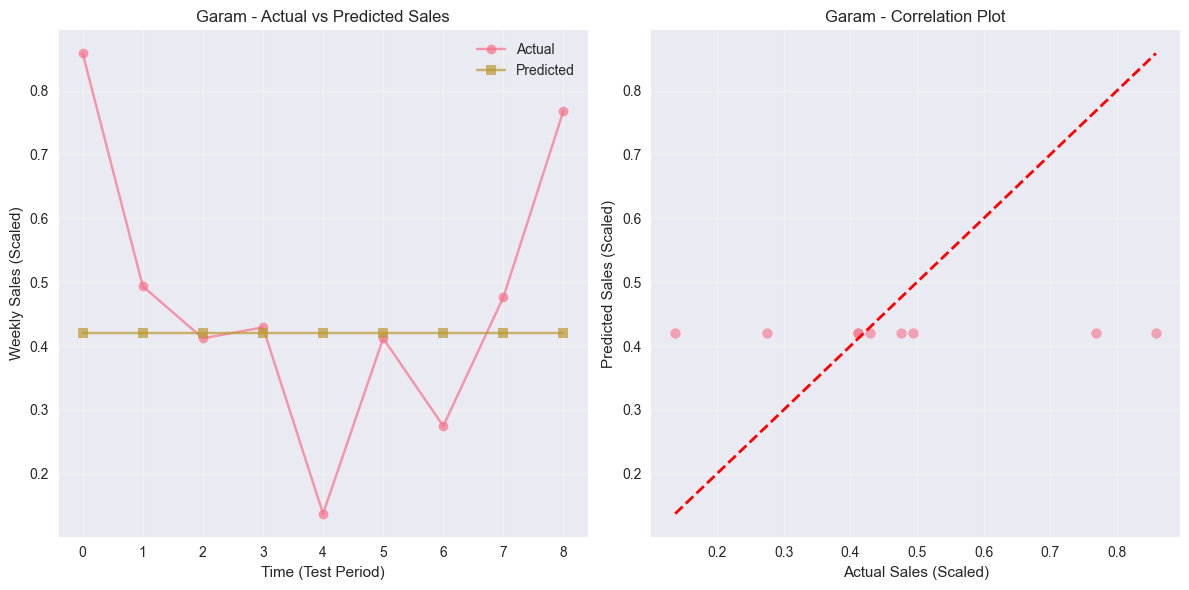

Plot saved to: results/plots/Garam_predictions.png

Training LSTM model for category: Gula
Processing category: Gula
Data points for Gula: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Gula:


Model: "sequential_58"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Gula...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 985ms/step - loss: 0.3365 - mae: 0.5334 - val_loss: 0.4727 - val_mae: 0.6692
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 985ms/step - loss: 0.3365 - mae: 0.5334 - val_loss: 0.4727 - val_mae: 0.6692
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2950 - mae: 0.4932 - val_loss: 0.4031 - val_mae: 0.6149
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2950 - mae: 0.4932 - val_loss: 0.4031 - val_mae: 0.6149
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2502 - mae: 0.4522 - val_loss: 0.3345 - val_mae: 0.5563
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2502 - mae: 0.4522 - val_loss: 0.3345 - val_mae: 0.5563
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1902 - mae: 0.3960 - val_loss: 0.2502 - val_mae: 0.4745
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1902 - mae: 0.3960 - val_loss: 0.2502 - val_mae: 0.4745
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━


Gula - Training Metrics:
  MSE: 0.0567
  RMSE: 0.2381
  MAE: 0.1862
  MAPE: 62.3599

Gula - Test Metrics:
  MSE: 0.0809
  RMSE: 0.2844
  MAE: 0.2347
  MAPE: 120.3819

Model saved to: models/lstm_model_Gula.h5
Scalers saved to: models/scaler_X_Gula.pkl, models/scaler_y_Gula.pkl


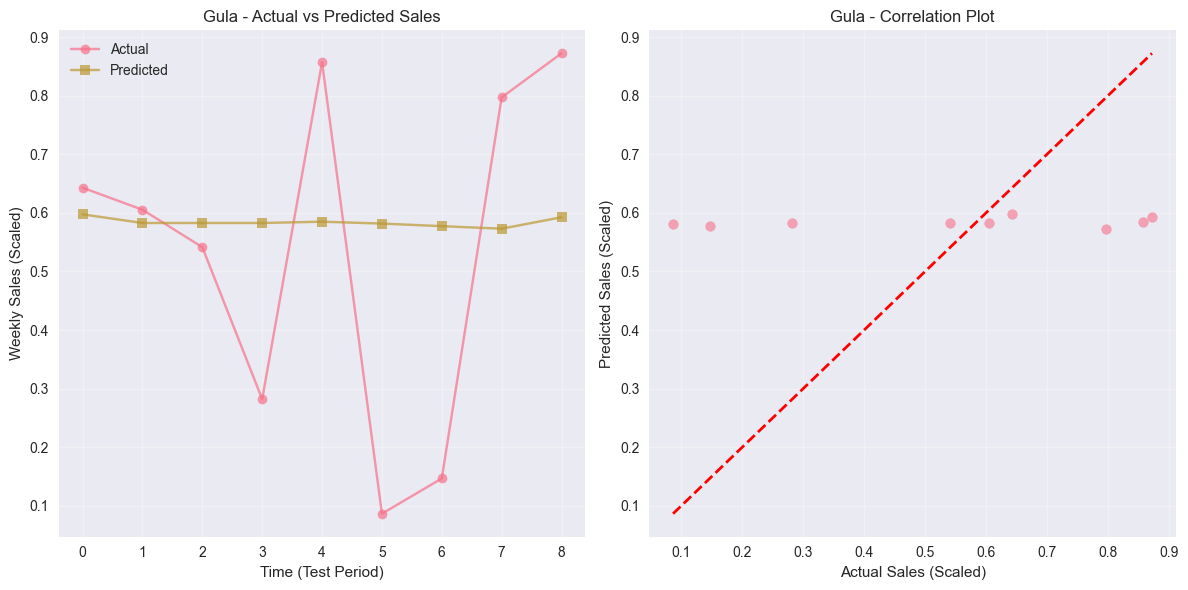

Plot saved to: results/plots/Gula_predictions.png

Training LSTM model for category: Gulali
Processing category: Gulali
Data points for Gulali: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Gulali:


Model: "sequential_59"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Gulali...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 965ms/step - loss: 0.3134 - mae: 0.5254 - val_loss: 0.3241 - val_mae: 0.5286
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 965ms/step - loss: 0.3134 - mae: 0.5254 - val_loss: 0.3241 - val_mae: 0.5286
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.2843 - mae: 0.4966 - val_loss: 0.3047 - val_mae: 0.5099
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.2843 - mae: 0.4966 - val_loss: 0.3047 - val_mae: 0.5099
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2639 - mae: 0.4773 - val_loss: 0.2820 - val_mae: 0.4871
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2639 - mae: 0.4773 - val_loss: 0.2820 - val_mae: 0.4871
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2437 - mae: 0.4584 - val_loss: 0.2597 - val_mae: 0.4637
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.2437 - mae: 0.4584 - val_loss: 0.2597 - val_mae: 0.4637
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━


Gulali - Training Metrics:
  MSE: 0.0367
  RMSE: 0.1917
  MAE: 0.1555
  MAPE: 31.9007

Gulali - Test Metrics:
  MSE: 0.0603
  RMSE: 0.2455
  MAE: 0.1852
  MAPE: 25.7384

Model saved to: models/lstm_model_Gulali.h5
Scalers saved to: models/scaler_X_Gulali.pkl, models/scaler_y_Gulali.pkl

Model saved to: models/lstm_model_Gulali.h5
Scalers saved to: models/scaler_X_Gulali.pkl, models/scaler_y_Gulali.pkl


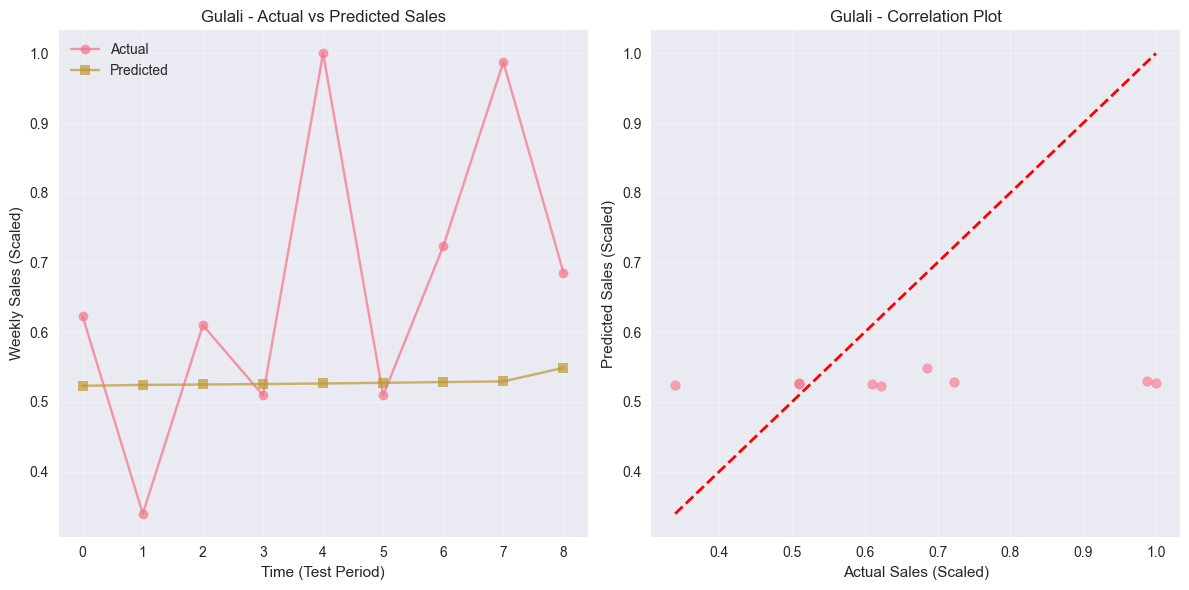

Plot saved to: results/plots/Gulali_predictions.png

Training LSTM model for category: Ice Cream
Processing category: Ice Cream
Data points for Ice Cream: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Ice Cream:


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Ice Cream...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.2555 - mae: 0.4641 - val_loss: 0.1340 - val_mae: 0.3295
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.2555 - mae: 0.4641 - val_loss: 0.1340 - val_mae: 0.3295
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1932 - mae: 0.3933 - val_loss: 0.0894 - val_mae: 0.2522
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1932 - mae: 0.3933 - val_loss: 0.0894 - val_mae: 0.2522
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1427 - mae: 0.3373 - val_loss: 0.0516 - val_mae: 0.1650
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.1427 - mae: 0.3373 - val_loss: 0.0516 - val_mae: 0.1650
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0910 - mae: 0.2612 - val_loss: 0.0296 - val_mae: 0.1420
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0910 - mae: 0.2612 - val_loss: 0.0296 - val_mae: 0.1420
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 


Ice Cream - Training Metrics:
  MSE: 0.0363
  RMSE: 0.1906
  MAE: 0.1493
  MAPE: 51.3888

Ice Cream - Test Metrics:
  MSE: 0.0830
  RMSE: 0.2882
  MAE: 0.2332
  MAPE: 117.0901

Model saved to: models/lstm_model_Ice Cream.h5
Scalers saved to: models/scaler_X_Ice Cream.pkl, models/scaler_y_Ice Cream.pkl


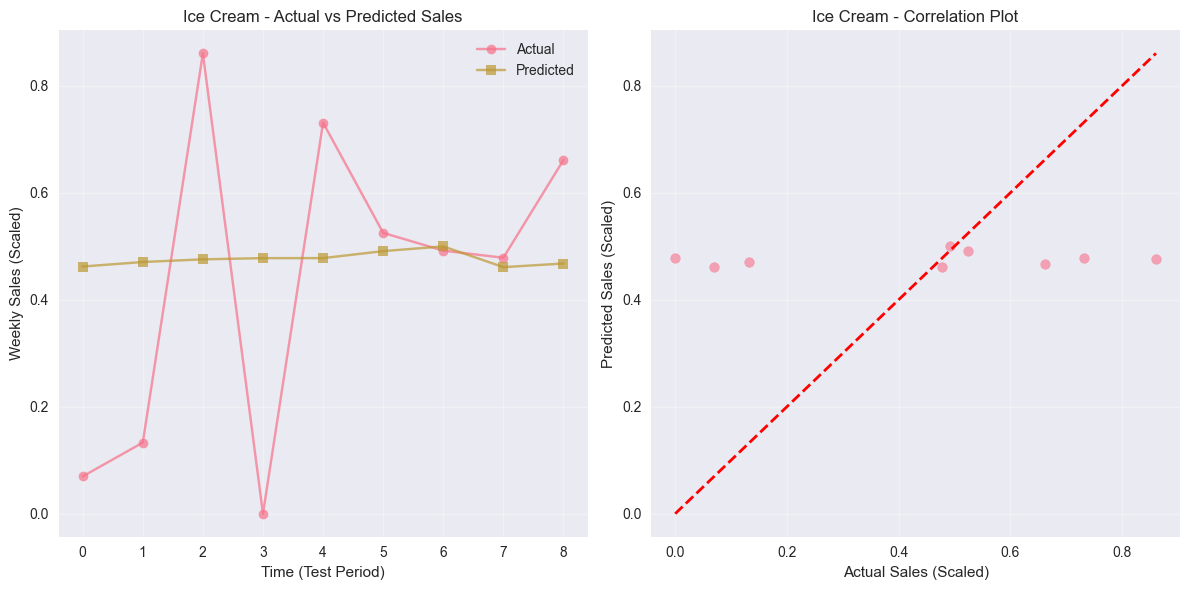

Plot saved to: results/plots/Ice Cream_predictions.png

Training LSTM model for category: Jus Kemasan
Processing category: Jus Kemasan
Data points for Jus Kemasan: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Jus Kemasan:


Model: "sequential_61"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Jus Kemasan...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.5148 - mae: 0.6890 - val_loss: 0.4670 - val_mae: 0.6711
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - loss: 0.5148 - mae: 0.6890 - val_loss: 0.4670 - val_mae: 0.6711
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.4459 - mae: 0.6421 - val_loss: 0.4092 - val_mae: 0.6262
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.4459 - mae: 0.6421 - val_loss: 0.4092 - val_mae: 0.6262
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3946 - mae: 0.6030 - val_loss: 0.3369 - val_mae: 0.5654
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - loss: 0.3946 - mae: 0.6030 - val_loss: 0.3369 - val_mae: 0.5654
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.3380 - mae: 0.5561 - val_loss: 0.2609 - val_mae: 0.4935
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 0.3380 - mae: 0.5561 - val_loss: 0.2609 - val_mae: 0.4935
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━


Jus Kemasan - Training Metrics:
  MSE: 0.0354
  RMSE: 0.1881
  MAE: 0.1352
  MAPE: 17.0984

Jus Kemasan - Test Metrics:
  MSE: 0.0528
  RMSE: 0.2297
  MAE: 0.1870
  MAPE: 22.6234

Model saved to: models/lstm_model_Jus Kemasan.h5
Scalers saved to: models/scaler_X_Jus Kemasan.pkl, models/scaler_y_Jus Kemasan.pkl


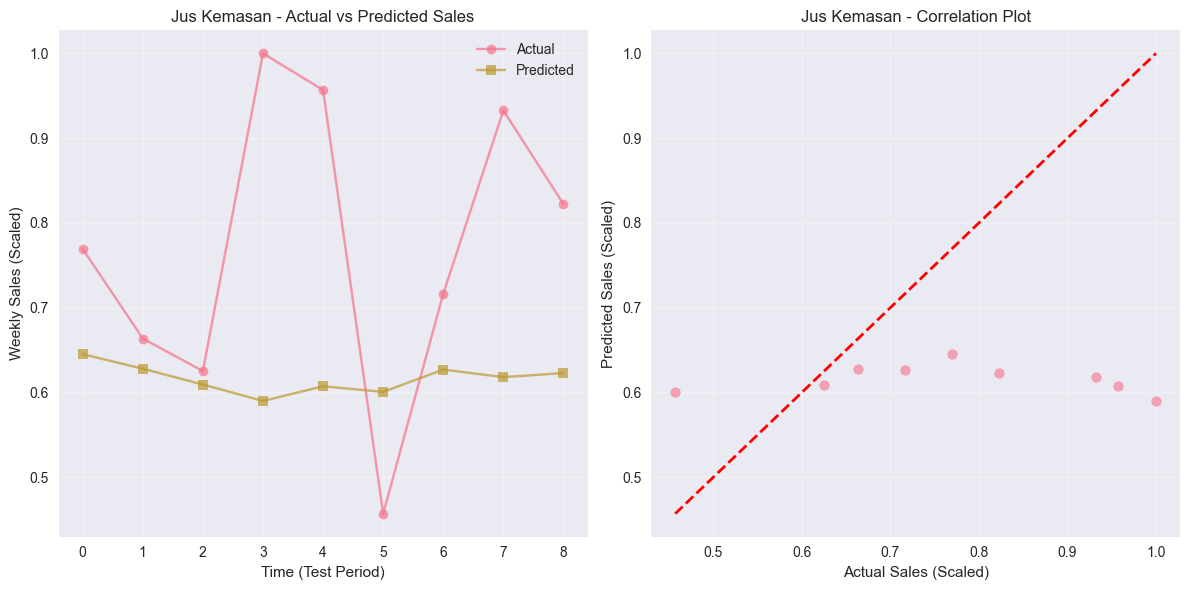

Plot saved to: results/plots/Jus Kemasan_predictions.png

Training LSTM model for category: Kacang
Processing category: Kacang
Data points for Kacang: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Kacang:


Model: "sequential_62"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Kacang...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.3795 - mae: 0.5783 - val_loss: 0.4390 - val_mae: 0.6438
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.3795 - mae: 0.5783 - val_loss: 0.4390 - val_mae: 0.6438
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2758 - mae: 0.4766 - val_loss: 0.3237 - val_mae: 0.5474
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2758 - mae: 0.4766 - val_loss: 0.3237 - val_mae: 0.5474
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1971 - mae: 0.3948 - val_loss: 0.2288 - val_mae: 0.4532
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1971 - mae: 0.3948 - val_loss: 0.2288 - val_mae: 0.4532
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1315 - mae: 0.3182 - val_loss: 0.1527 - val_mae: 0.3598
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1315 - mae: 0.3182 - val_loss: 0.1527 - val_mae: 0.3598
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 


Kacang - Training Metrics:
  MSE: 0.0560
  RMSE: 0.2366
  MAE: 0.1842
  MAPE: 43.3273

Kacang - Test Metrics:
  MSE: 0.0364
  RMSE: 0.1908
  MAE: 0.1639
  MAPE: 25.9055

Model saved to: models/lstm_model_Kacang.h5
Scalers saved to: models/scaler_X_Kacang.pkl, models/scaler_y_Kacang.pkl


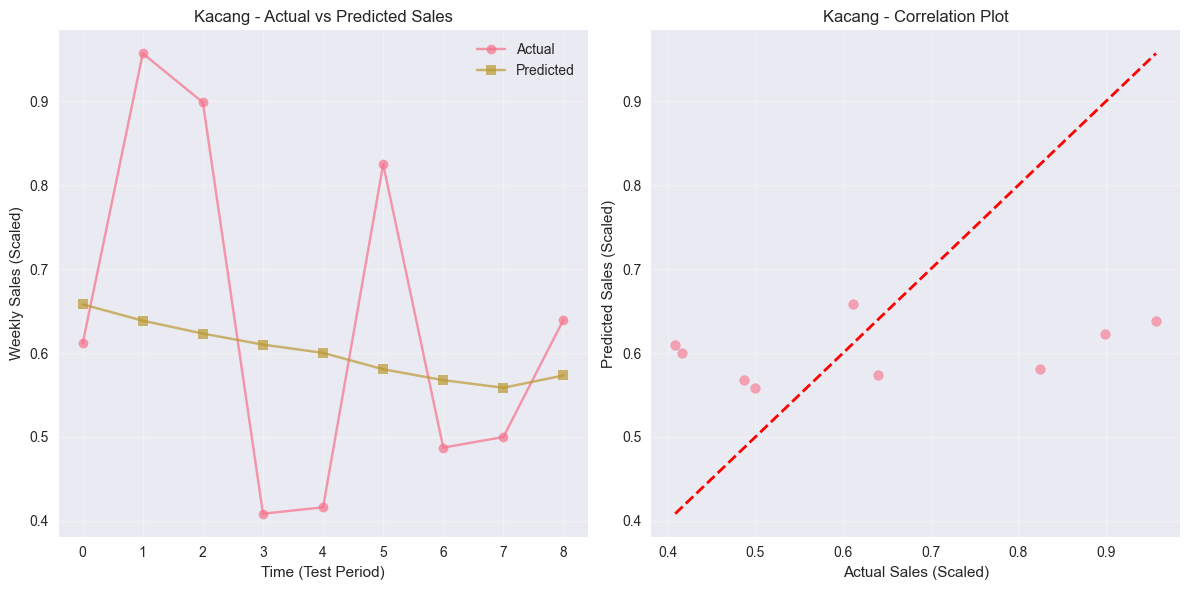

Plot saved to: results/plots/Kacang_predictions.png

Training LSTM model for category: Kaldu Jamur
Processing category: Kaldu Jamur
Data points for Kaldu Jamur: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Kaldu Jamur:


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Kaldu Jamur...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 998ms/step - loss: 0.3612 - mae: 0.5436 - val_loss: 0.1919 - val_mae: 0.3660
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 998ms/step - loss: 0.3612 - mae: 0.5436 - val_loss: 0.1919 - val_mae: 0.3660
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2965 - mae: 0.4872 - val_loss: 0.1489 - val_mae: 0.3045
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2965 - mae: 0.4872 - val_loss: 0.1489 - val_mae: 0.3045
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2476 - mae: 0.4459 - val_loss: 0.1101 - val_mae: 0.2378
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2476 - mae: 0.4459 - val_loss: 0.1101 - val_mae: 0.2378
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1985 - mae: 0.3929 - val_loss: 0.0751 - val_mae: 0.1876
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1985 - mae: 0.3929 - val_loss: 0.0751 - val_mae: 0.1876
Epoch 5/100
2/2 ━━━━━━━━━━━━━


Kaldu Jamur - Training Metrics:
  MSE: 0.0779
  RMSE: 0.2791
  MAE: 0.2293
  MAPE: 129.6261

Kaldu Jamur - Test Metrics:
  MSE: 0.0736
  RMSE: 0.2713
  MAE: 0.2086
  MAPE: 184.2329

Model saved to: models/lstm_model_Kaldu Jamur.h5
Scalers saved to: models/scaler_X_Kaldu Jamur.pkl, models/scaler_y_Kaldu Jamur.pkl


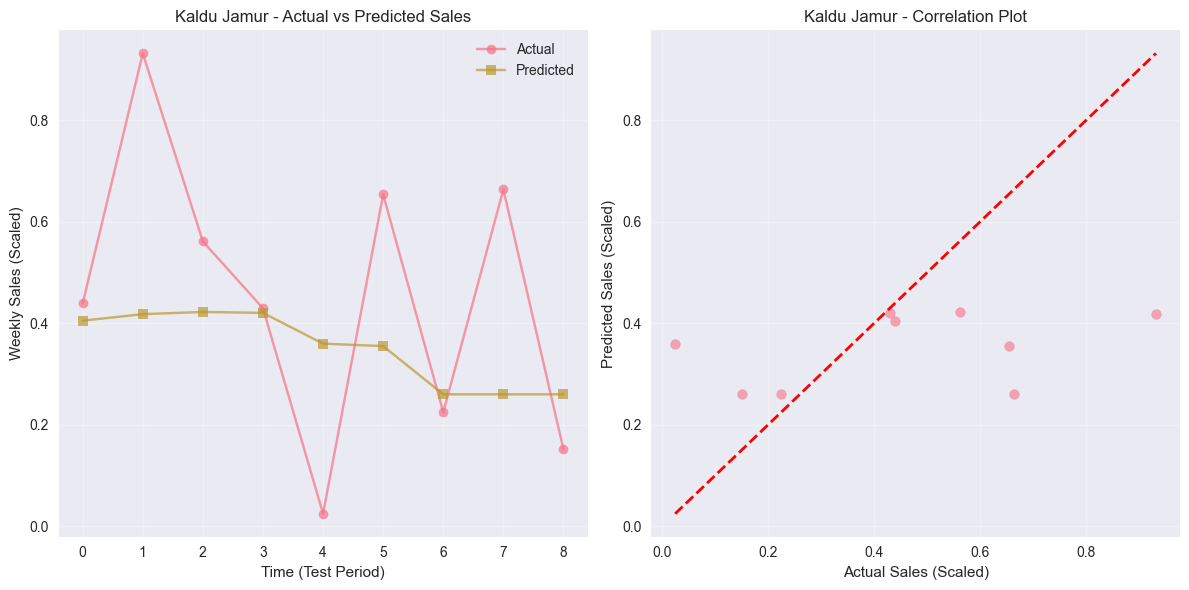

Plot saved to: results/plots/Kaldu Jamur_predictions.png

Training LSTM model for category: Kecap
Processing category: Kecap
Data points for Kecap: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Kecap:


Model: "sequential_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Kecap...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 970ms/step - loss: 0.1988 - mae: 0.3752 - val_loss: 0.3453 - val_mae: 0.5375
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 970ms/step - loss: 0.1988 - mae: 0.3752 - val_loss: 0.3453 - val_mae: 0.5375
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1807 - mae: 0.3516 - val_loss: 0.3273 - val_mae: 0.5204
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1807 - mae: 0.3516 - val_loss: 0.3273 - val_mae: 0.5204
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1680 - mae: 0.3341 - val_loss: 0.3056 - val_mae: 0.4988
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.1680 - mae: 0.3341 - val_loss: 0.3056 - val_mae: 0.4988
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1583 - mae: 0.3206 - val_loss: 0.2819 - val_mae: 0.4740
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1583 - mae: 0.3206 - val_loss: 0.2819 - val_mae: 0.4740
Epoch 5/100
2/2 ━━━━━━━


Kecap - Training Metrics:
  MSE: 0.0665
  RMSE: 0.2580
  MAE: 0.2055
  MAPE: 104.4656

Kecap - Test Metrics:
  MSE: 0.0736
  RMSE: 0.2713
  MAE: 0.2199
  MAPE: 120.4494

Model saved to: models/lstm_model_Kecap.h5
Scalers saved to: models/scaler_X_Kecap.pkl, models/scaler_y_Kecap.pkl


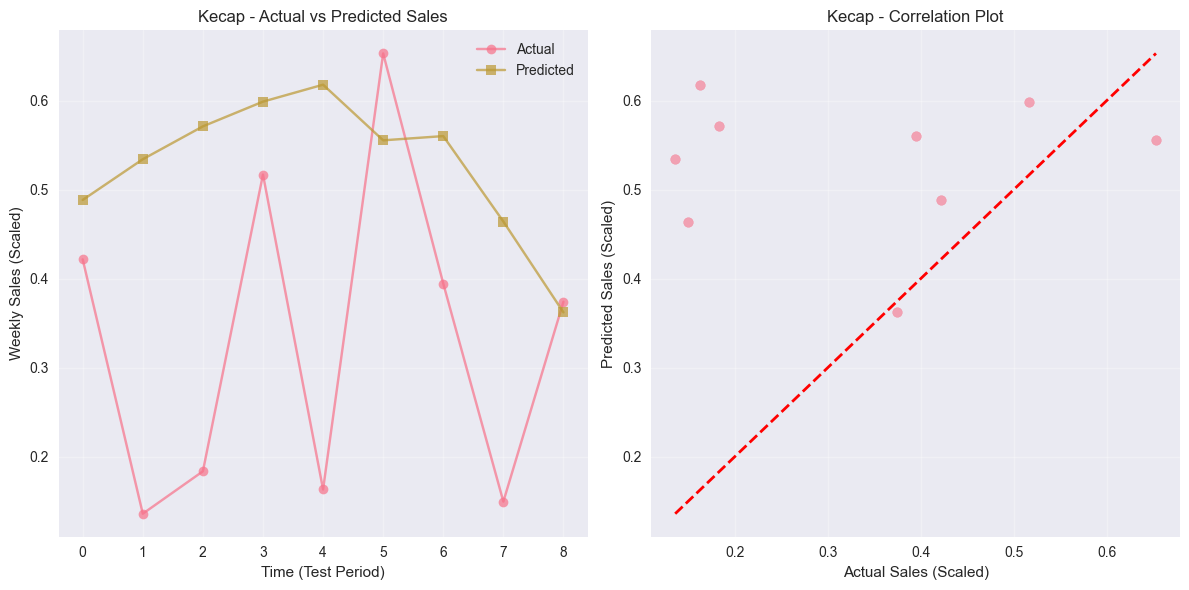

Plot saved to: results/plots/Kecap_predictions.png

Training LSTM model for category: Keju
Processing category: Keju
Data points for Keju: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Keju:


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Keju...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 930ms/step - loss: 0.3245 - mae: 0.5246 - val_loss: 0.2469 - val_mae: 0.4613
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 930ms/step - loss: 0.3245 - mae: 0.5246 - val_loss: 0.2469 - val_mae: 0.4613
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.2559 - mae: 0.4589 - val_loss: 0.2076 - val_mae: 0.4151
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.2559 - mae: 0.4589 - val_loss: 0.2076 - val_mae: 0.4151
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2266 - mae: 0.4248 - val_loss: 0.1827 - val_mae: 0.3835
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2266 - mae: 0.4248 - val_loss: 0.1827 - val_mae: 0.3835
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.1894 - mae: 0.3842 - val_loss: 0.1579 - val_mae: 0.3491
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.1894 - mae: 0.3842 - val_loss: 0.1579 - val_mae: 0.3491
Epoch 5/100
2/2 ━━━━━━━━


Keju - Training Metrics:
  MSE: 0.0385
  RMSE: 0.1963
  MAE: 0.1551
  MAPE: 44.9946

Keju - Test Metrics:
  MSE: 0.0682
  RMSE: 0.2612
  MAE: 0.2211
  MAPE: 63.3281

Model saved to: models/lstm_model_Keju.h5
Scalers saved to: models/scaler_X_Keju.pkl, models/scaler_y_Keju.pkl


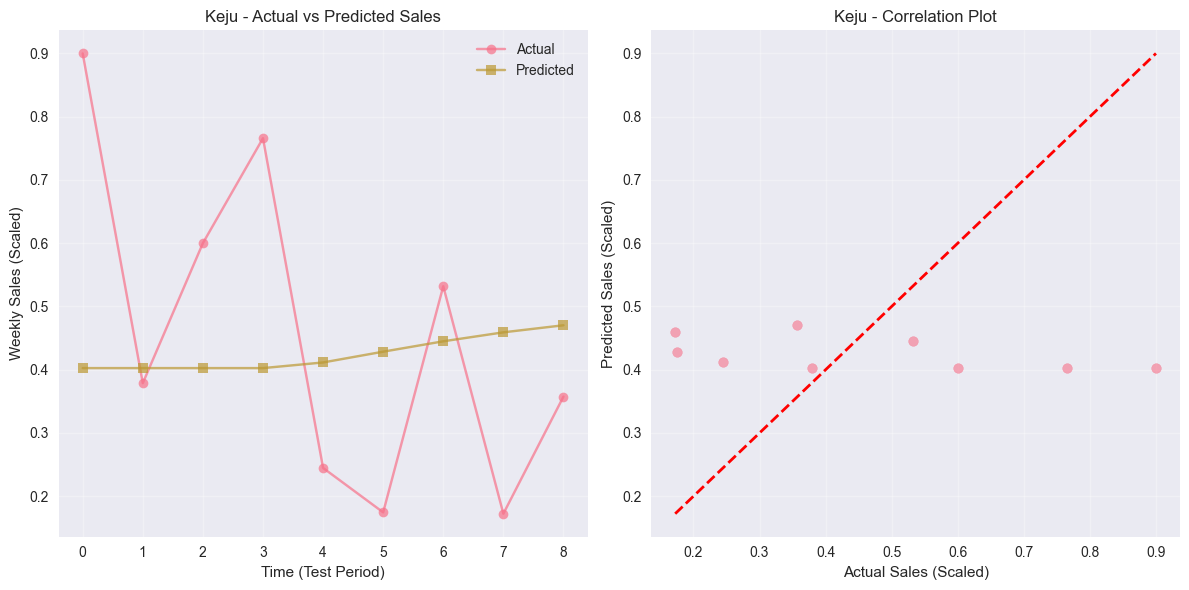

Plot saved to: results/plots/Keju_predictions.png

Training LSTM model for category: Kentang Goreng
Processing category: Kentang Goreng
Data points for Kentang Goreng: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Kentang Goreng:

Model architecture for Kentang Goreng:


Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Kentang Goreng...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 940ms/step - loss: 0.4236 - mae: 0.5949 - val_loss: 0.2160 - val_mae: 0.4576
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 940ms/step - loss: 0.4236 - mae: 0.5949 - val_loss: 0.2160 - val_mae: 0.4576
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.3663 - mae: 0.5460 - val_loss: 0.1608 - val_mae: 0.3928
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - loss: 0.3663 - mae: 0.5460 - val_loss: 0.1608 - val_mae: 0.3928
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.3041 - mae: 0.4840 - val_loss: 0.1084 - val_mae: 0.3192
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.3041 - mae: 0.4840 - val_loss: 0.1084 - val_mae: 0.3192
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2362 - mae: 0.4205 - val_loss: 0.0674 - val_mae: 0.2468
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.2362 - mae: 0.4205 - val_loss: 0.0674 - val_mae: 0.2468
Epoch 5/100
2/2 ━━━━━━━━━━


Kentang Goreng - Training Metrics:
  MSE: 0.0565
  RMSE: 0.2376
  MAE: 0.1933
  MAPE: 52.5065

Kentang Goreng - Test Metrics:
  MSE: 0.0610
  RMSE: 0.2470
  MAE: 0.1874
  MAPE: 30.3918

Model saved to: models/lstm_model_Kentang Goreng.h5
Scalers saved to: models/scaler_X_Kentang Goreng.pkl, models/scaler_y_Kentang Goreng.pkl


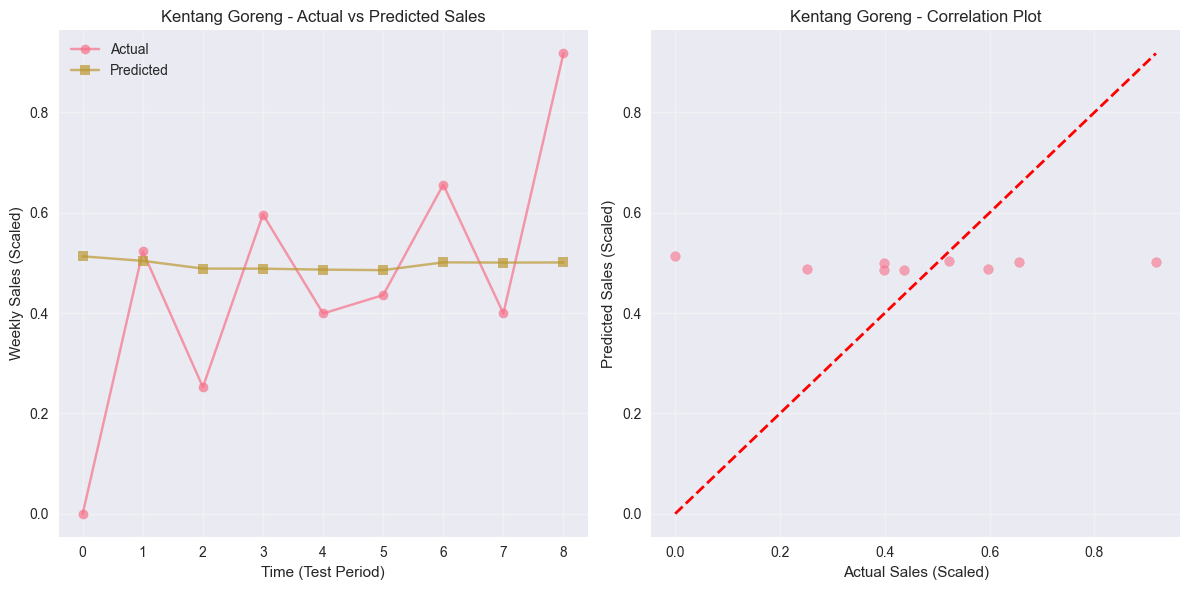

Plot saved to: results/plots/Kentang Goreng_predictions.png

Training LSTM model for category: Keripik
Processing category: Keripik
Data points for Keripik: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Keripik:

Model architecture for Keripik:


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Keripik...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 986ms/step - loss: 0.3718 - mae: 0.5679 - val_loss: 0.3427 - val_mae: 0.5045
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 986ms/step - loss: 0.3718 - mae: 0.5679 - val_loss: 0.3427 - val_mae: 0.5045
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.3100 - mae: 0.5070 - val_loss: 0.2917 - val_mae: 0.4650
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - loss: 0.3100 - mae: 0.5070 - val_loss: 0.2917 - val_mae: 0.4650
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2639 - mae: 0.4619 - val_loss: 0.2545 - val_mae: 0.4333
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.2639 - mae: 0.4619 - val_loss: 0.2545 - val_mae: 0.4333
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.2192 - mae: 0.4214 - val_loss: 0.2157 - val_mae: 0.3958
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.2192 - mae: 0.4214 - val_loss: 0.2157 - val_mae: 0.3958
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━


Keripik - Training Metrics:
  MSE: 0.0599
  RMSE: 0.2447
  MAE: 0.2008
  MAPE: 92.3108

Keripik - Test Metrics:
  MSE: 0.0496
  RMSE: 0.2228
  MAE: 0.1892
  MAPE: 30.7022

Model saved to: models/lstm_model_Keripik.h5
Scalers saved to: models/scaler_X_Keripik.pkl, models/scaler_y_Keripik.pkl


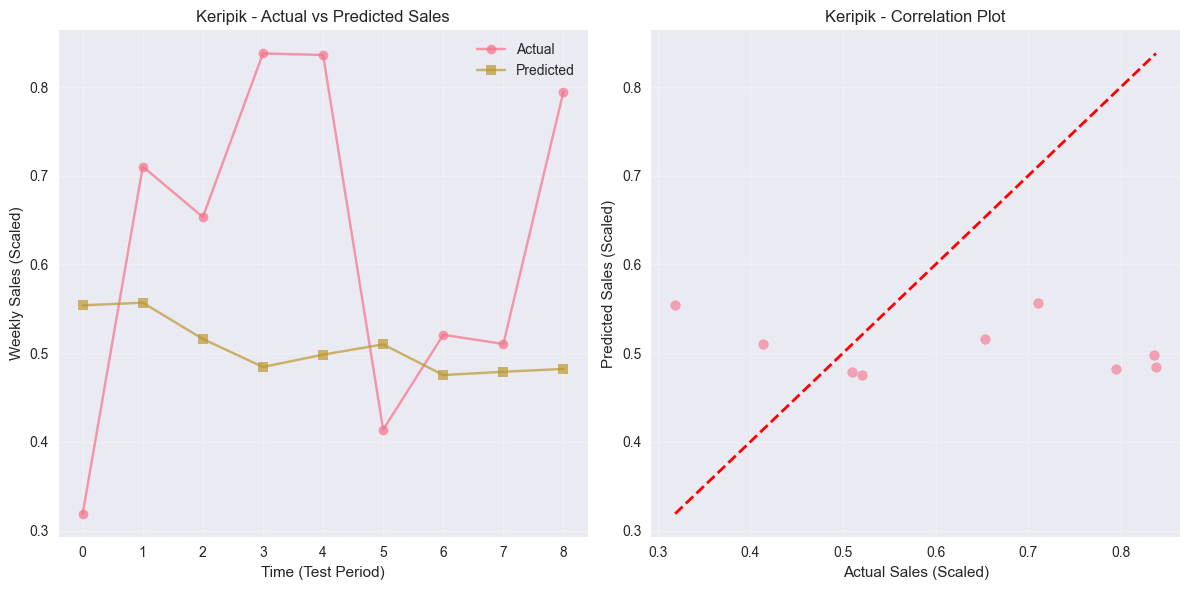

Plot saved to: results/plots/Keripik_predictions.png

Training LSTM model for category: Kopi Bubuk
Processing category: Kopi Bubuk
Data points for Kopi Bubuk: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Kopi Bubuk:

Model architecture for Kopi Bubuk:


Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Kopi Bubuk...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 982ms/step - loss: 0.2457 - mae: 0.4101 - val_loss: 0.0887 - val_mae: 0.2740
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 982ms/step - loss: 0.2457 - mae: 0.4101 - val_loss: 0.0887 - val_mae: 0.2740
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.2070 - mae: 0.3704 - val_loss: 0.0450 - val_mae: 0.1930
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.2070 - mae: 0.3704 - val_loss: 0.0450 - val_mae: 0.1930
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.1748 - mae: 0.3454 - val_loss: 0.0173 - val_mae: 0.1196
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 0.1748 - mae: 0.3454 - val_loss: 0.0173 - val_mae: 0.1196
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.1399 - mae: 0.3116 - val_loss: 0.0176 - val_mae: 0.0824
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.1399 - mae: 0.3116 - val_loss: 0.0176 - val_mae: 0.0824
Epoch 5/100
2/2 ━━


Kopi Bubuk - Training Metrics:
  MSE: 0.1195
  RMSE: 0.3457
  MAE: 0.2818
  MAPE: 98.3697

Kopi Bubuk - Test Metrics:
  MSE: 0.0344
  RMSE: 0.1854
  MAE: 0.1496
  MAPE: 40.0433

Model saved to: models/lstm_model_Kopi Bubuk.h5
Scalers saved to: models/scaler_X_Kopi Bubuk.pkl, models/scaler_y_Kopi Bubuk.pkl


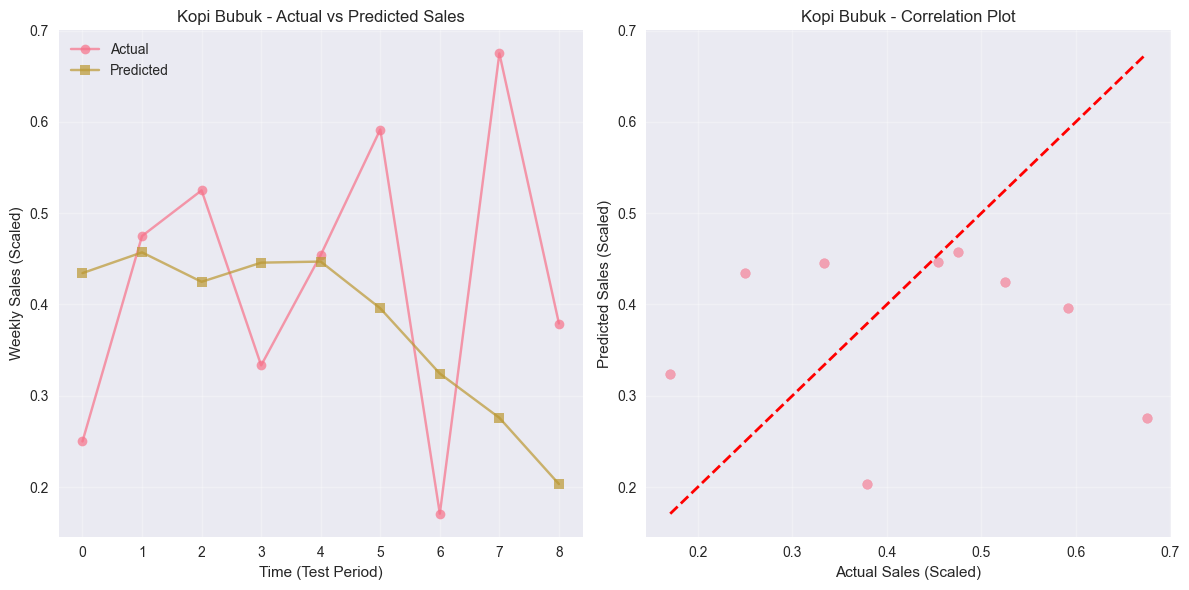

Plot saved to: results/plots/Kopi Bubuk_predictions.png

Training LSTM model for category: Kopi Kemasan
Processing category: Kopi Kemasan
Data points for Kopi Kemasan: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Kopi Kemasan:

Model architecture for Kopi Kemasan:


Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Kopi Kemasan...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 991ms/step - loss: 0.3189 - mae: 0.5290 - val_loss: 0.2401 - val_mae: 0.4354
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 991ms/step - loss: 0.3189 - mae: 0.5290 - val_loss: 0.2401 - val_mae: 0.4354
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2549 - mae: 0.4657 - val_loss: 0.1868 - val_mae: 0.3826
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.2549 - mae: 0.4657 - val_loss: 0.1868 - val_mae: 0.3826
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1772 - mae: 0.3810 - val_loss: 0.1394 - val_mae: 0.3214
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.1772 - mae: 0.3810 - val_loss: 0.1394 - val_mae: 0.3214
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1141 - mae: 0.2604 - val_loss: 0.1031 - val_mae: 0.2550
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.1141 - mae: 0.2604 - val_loss: 0.1031 - val_mae: 0.2550
Epoch 5/100
2/2 ━━━━━━━━━━━━


Kopi Kemasan - Training Metrics:
  MSE: 0.0572
  RMSE: 0.2391
  MAE: 0.1806
  MAPE: 64.6939

Kopi Kemasan - Test Metrics:
  MSE: 0.0405
  RMSE: 0.2013
  MAE: 0.1606
  MAPE: 22.9570

Model saved to: models/lstm_model_Kopi Kemasan.h5
Scalers saved to: models/scaler_X_Kopi Kemasan.pkl, models/scaler_y_Kopi Kemasan.pkl


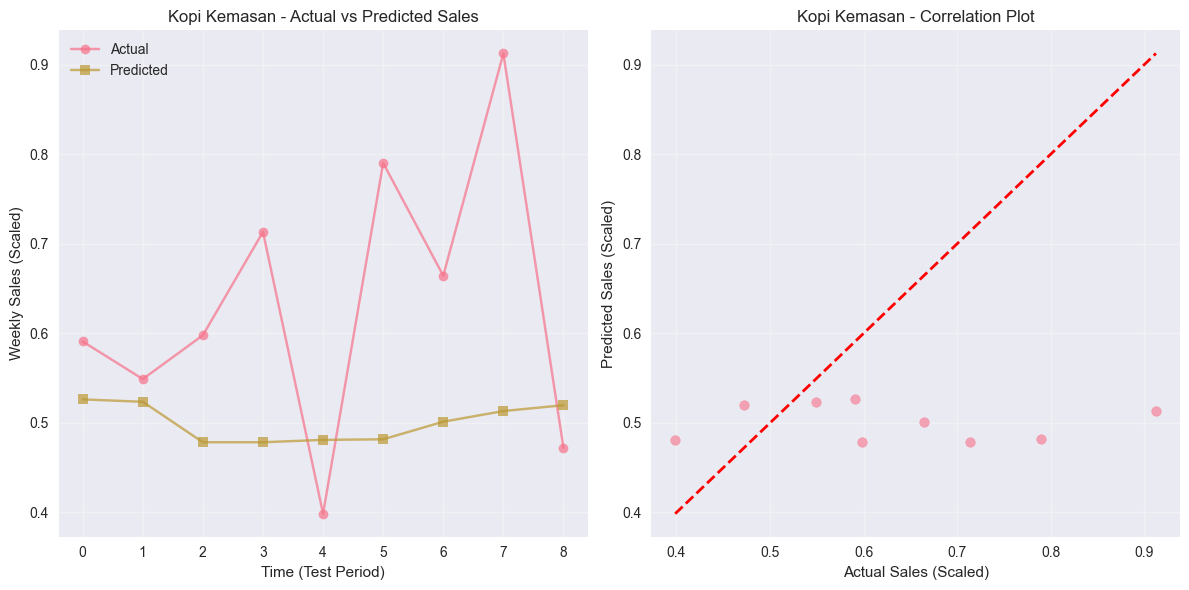

Plot saved to: results/plots/Kopi Kemasan_predictions.png

Training LSTM model for category: Kornet
Processing category: Kornet
Data points for Kornet: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Kornet:


Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Kornet...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 968ms/step - loss: 0.3275 - mae: 0.5440 - val_loss: 0.2048 - val_mae: 0.4168
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 968ms/step - loss: 0.3275 - mae: 0.5440 - val_loss: 0.2048 - val_mae: 0.4168
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2685 - mae: 0.4847 - val_loss: 0.1588 - val_mae: 0.3574
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2685 - mae: 0.4847 - val_loss: 0.1588 - val_mae: 0.3574
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2207 - mae: 0.4311 - val_loss: 0.1170 - val_mae: 0.2933
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2207 - mae: 0.4311 - val_loss: 0.1170 - val_mae: 0.2933
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.1615 - mae: 0.3529 - val_loss: 0.0793 - val_mae: 0.2200
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.1615 - mae: 0.3529 - val_loss: 0.0793 - val_mae: 0.2200
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━


Kornet - Training Metrics:
  MSE: 0.0342
  RMSE: 0.1848
  MAE: 0.1496
  MAPE: 28.9056

Kornet - Test Metrics:
  MSE: 0.0458
  RMSE: 0.2139
  MAE: 0.1958
  MAPE: 50.2635

Model saved to: models/lstm_model_Kornet.h5
Scalers saved to: models/scaler_X_Kornet.pkl, models/scaler_y_Kornet.pkl


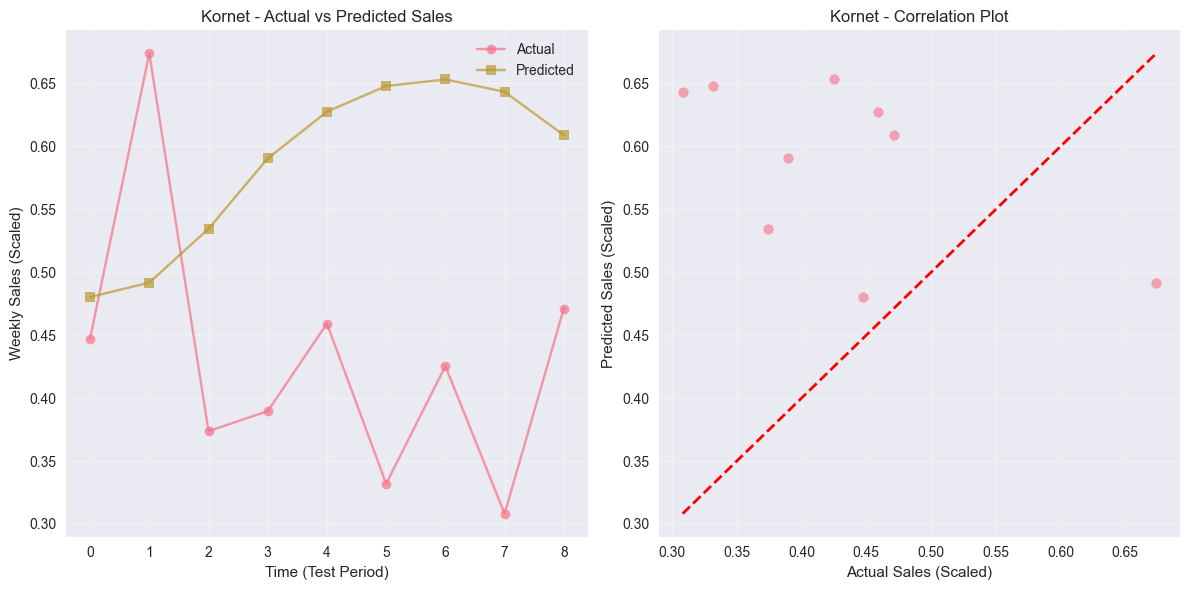

Plot saved to: results/plots/Kornet_predictions.png

Training LSTM model for category: Krim
Processing category: Krim
Data points for Krim: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Krim:

Model architecture for Krim:


Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Krim...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 920ms/step - loss: 0.1982 - mae: 0.3758 - val_loss: 0.2459 - val_mae: 0.4506
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 920ms/step - loss: 0.1982 - mae: 0.3758 - val_loss: 0.2459 - val_mae: 0.4506
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1408 - mae: 0.3140 - val_loss: 0.1874 - val_mae: 0.3802
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.1408 - mae: 0.3140 - val_loss: 0.1874 - val_mae: 0.3802
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1141 - mae: 0.2706 - val_loss: 0.1331 - val_mae: 0.2985
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.1141 - mae: 0.2706 - val_loss: 0.1331 - val_mae: 0.2985
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0935 - mae: 0.2488 - val_loss: 0.0880 - val_mae: 0.2333
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.0935 - mae: 0.2488 - val_loss: 0.0880 - val_mae: 0.2333
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━


Krim - Training Metrics:
  MSE: 0.0679
  RMSE: 0.2606
  MAE: 0.2156
  MAPE: 118.3783

Krim - Test Metrics:
  MSE: 0.0521
  RMSE: 0.2283
  MAE: 0.1781
  MAPE: 77.8361

Model saved to: models/lstm_model_Krim.h5
Scalers saved to: models/scaler_X_Krim.pkl, models/scaler_y_Krim.pkl


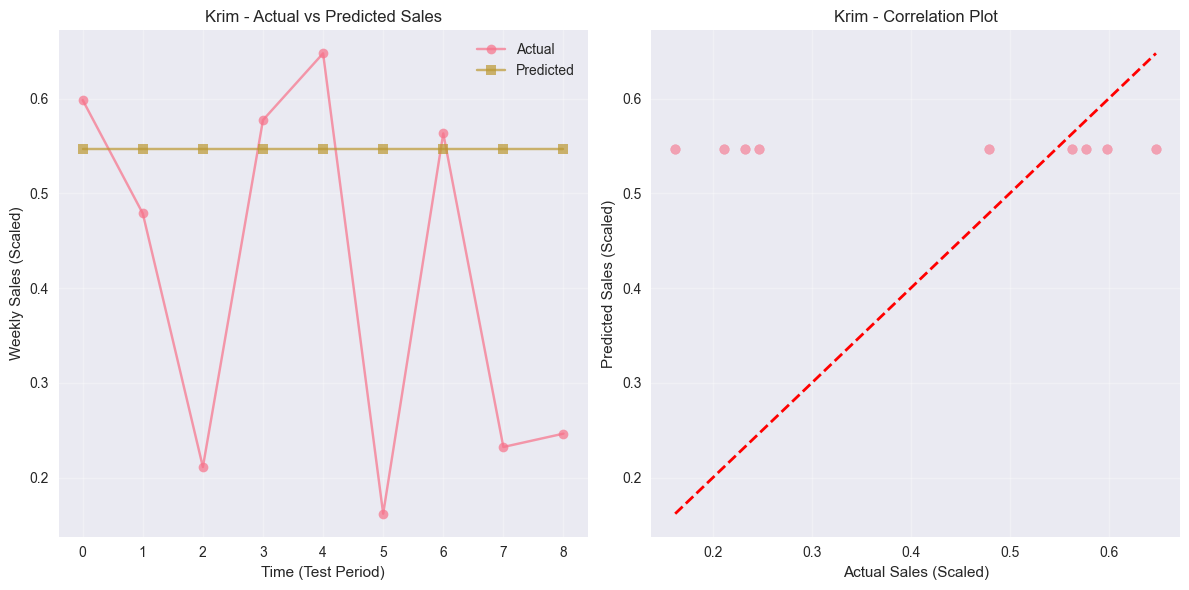

Plot saved to: results/plots/Krim_predictions.png

Training LSTM model for category: Kuaci
Processing category: Kuaci
Data points for Kuaci: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Kuaci:


Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Kuaci...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 927ms/step - loss: 0.5247 - mae: 0.6841 - val_loss: 0.2931 - val_mae: 0.4882
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 927ms/step - loss: 0.5247 - mae: 0.6841 - val_loss: 0.2931 - val_mae: 0.4882
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.3897 - mae: 0.5889 - val_loss: 0.2383 - val_mae: 0.4291
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.3897 - mae: 0.5889 - val_loss: 0.2383 - val_mae: 0.4291
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3199 - mae: 0.5242 - val_loss: 0.2077 - val_mae: 0.3927
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3199 - mae: 0.5242 - val_loss: 0.2077 - val_mae: 0.3927
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.2658 - mae: 0.4658 - val_loss: 0.1807 - val_mae: 0.3568
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - loss: 0.2658 - mae: 0.4658 - val_loss: 0.1807 - val_mae: 0.3568
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━


Kuaci - Training Metrics:
  MSE: 0.0507
  RMSE: 0.2251
  MAE: 0.1843
  MAPE: 45.3544

Kuaci - Test Metrics:
  MSE: 0.0284
  RMSE: 0.1684
  MAE: 0.1508
  MAPE: 29.6824

Model saved to: models/lstm_model_Kuaci.h5
Scalers saved to: models/scaler_X_Kuaci.pkl, models/scaler_y_Kuaci.pkl


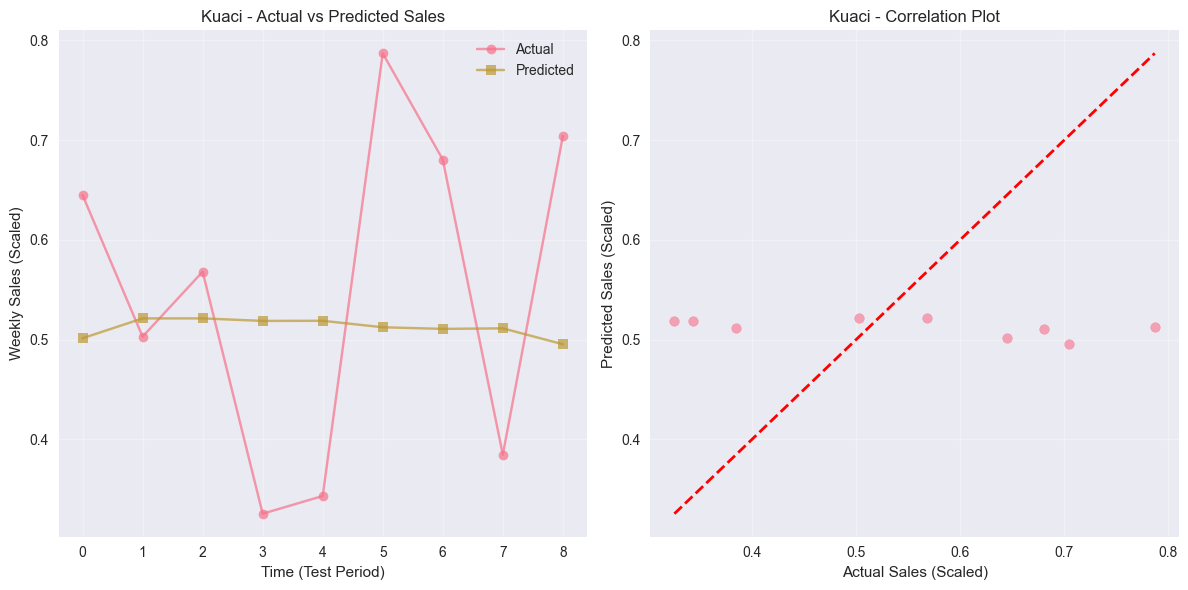

Plot saved to: results/plots/Kuaci_predictions.png

Training LSTM model for category: Makaroni
Processing category: Makaroni
Data points for Makaroni: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Makaroni:


Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Makaroni...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 988ms/step - loss: 0.3454 - mae: 0.5441 - val_loss: 0.3258 - val_mae: 0.5340
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 988ms/step - loss: 0.3454 - mae: 0.5441 - val_loss: 0.3258 - val_mae: 0.5340
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.2434 - mae: 0.4469 - val_loss: 0.2303 - val_mae: 0.4356
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - loss: 0.2434 - mae: 0.4469 - val_loss: 0.2303 - val_mae: 0.4356
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.1716 - mae: 0.3538 - val_loss: 0.1450 - val_mae: 0.3376
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - loss: 0.1716 - mae: 0.3538 - val_loss: 0.1450 - val_mae: 0.3376
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.1052 - mae: 0.2527 - val_loss: 0.0773 - val_mae: 0.2438
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.1052 - mae: 0.2527 - val_loss: 0.0773 - val_mae: 0.2438
Epoch 5/100
2/2 ━━━━


Makaroni - Training Metrics:
  MSE: 0.0636
  RMSE: 0.2522
  MAE: 0.2028
  MAPE: 42.3482

Makaroni - Test Metrics:
  MSE: 0.0204
  RMSE: 0.1430
  MAE: 0.1294
  MAPE: 21.6167

Model saved to: models/lstm_model_Makaroni.h5
Scalers saved to: models/scaler_X_Makaroni.pkl, models/scaler_y_Makaroni.pkl


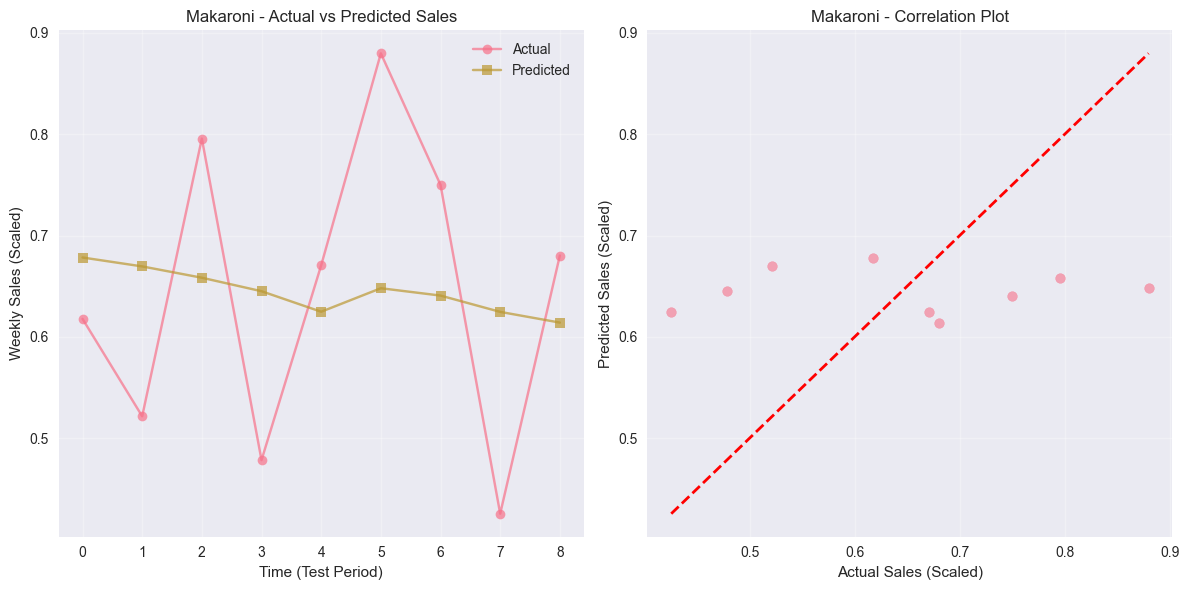

Plot saved to: results/plots/Makaroni_predictions.png

Training LSTM model for category: Marshmallow
Processing category: Marshmallow
Data points for Marshmallow: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Marshmallow:


Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Marshmallow...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.3894 - mae: 0.5839 - val_loss: 0.4572 - val_mae: 0.6657
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.3894 - mae: 0.5839 - val_loss: 0.4572 - val_mae: 0.6657
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3175 - mae: 0.5195 - val_loss: 0.3901 - val_mae: 0.6132
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - loss: 0.3175 - mae: 0.5195 - val_loss: 0.3901 - val_mae: 0.6132
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2642 - mae: 0.4688 - val_loss: 0.3184 - val_mae: 0.5517
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.2642 - mae: 0.4688 - val_loss: 0.3184 - val_mae: 0.5517
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.2367 - mae: 0.4356 - val_loss: 0.2464 - val_mae: 0.4821
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.2367 - mae: 0.4356 - val_loss: 0.2464 - val_mae: 0.4821
Epoch 5/100
2/2 ━━━━━━━


Marshmallow - Training Metrics:
  MSE: 0.0503
  RMSE: 0.2242
  MAE: 0.1774
  MAPE: 46.9510

Marshmallow - Test Metrics:
  MSE: 0.1047
  RMSE: 0.3236
  MAE: 0.2636
  MAPE: 47.6016

Model saved to: models/lstm_model_Marshmallow.h5
Scalers saved to: models/scaler_X_Marshmallow.pkl, models/scaler_y_Marshmallow.pkl


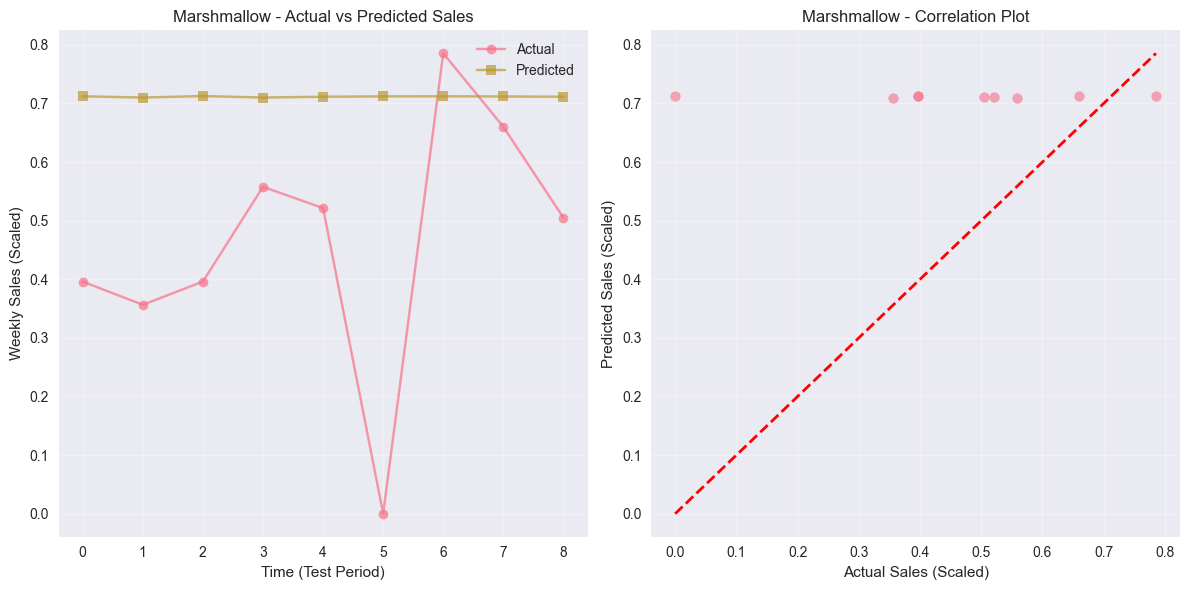

Plot saved to: results/plots/Marshmallow_predictions.png

Training LSTM model for category: Mayones
Processing category: Mayones
Data points for Mayones: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Mayones:


Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Mayones...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 962ms/step - loss: 0.2690 - mae: 0.4609 - val_loss: 0.0578 - val_mae: 0.2067
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 962ms/step - loss: 0.2690 - mae: 0.4609 - val_loss: 0.0578 - val_mae: 0.2067
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.2468 - mae: 0.4390 - val_loss: 0.0447 - val_mae: 0.1769
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.2468 - mae: 0.4390 - val_loss: 0.0447 - val_mae: 0.1769
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.2169 - mae: 0.4075 - val_loss: 0.0320 - val_mae: 0.1469
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.2169 - mae: 0.4075 - val_loss: 0.0320 - val_mae: 0.1469
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1969 - mae: 0.3853 - val_loss: 0.0208 - val_mae: 0.1109
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1969 - mae: 0.3853 - val_loss: 0.0208 - val_mae: 0.1109
Epoch 5/100
2/2 ━━━━━


Mayones - Training Metrics:
  MSE: 0.0826
  RMSE: 0.2873
  MAE: 0.2340
  MAPE: 70.2763

Mayones - Test Metrics:
  MSE: 0.0966
  RMSE: 0.3108
  MAE: 0.2471
  MAPE: 46.9123

Model saved to: models/lstm_model_Mayones.h5
Scalers saved to: models/scaler_X_Mayones.pkl, models/scaler_y_Mayones.pkl


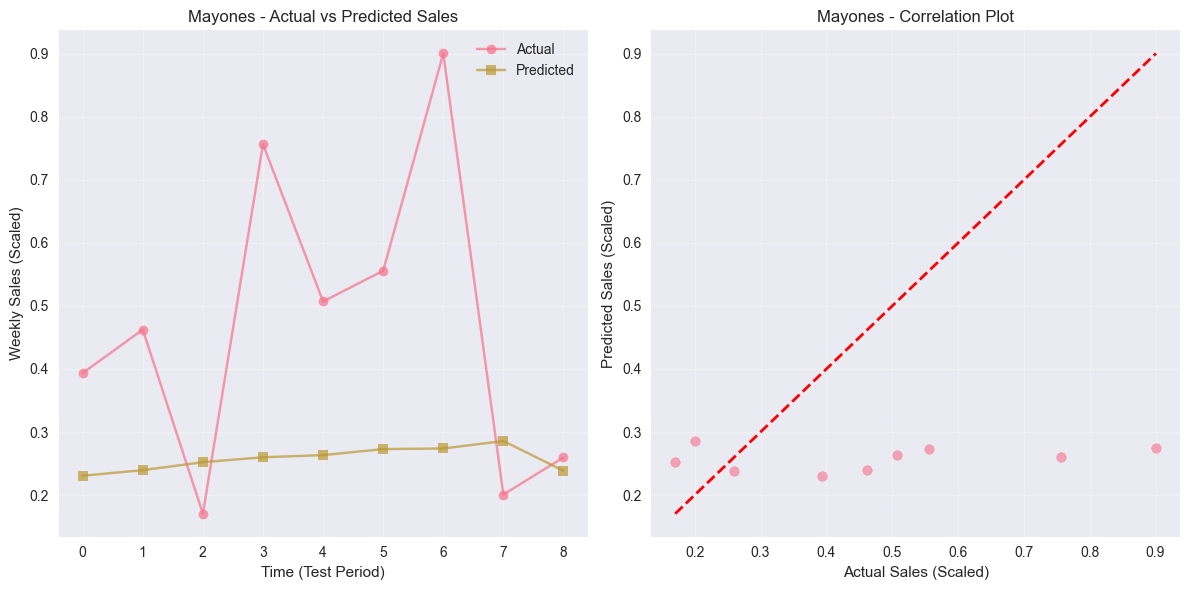

Plot saved to: results/plots/Mayones_predictions.png

Training LSTM model for category: Mentega
Processing category: Mentega
Data points for Mentega: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Mentega:


Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Mentega...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.2593 - mae: 0.4757 - val_loss: 0.1835 - val_mae: 0.4031
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.2593 - mae: 0.4757 - val_loss: 0.1835 - val_mae: 0.4031
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2243 - mae: 0.4379 - val_loss: 0.1528 - val_mae: 0.3626
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.2243 - mae: 0.4379 - val_loss: 0.1528 - val_mae: 0.3626
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1901 - mae: 0.3952 - val_loss: 0.1196 - val_mae: 0.3131
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.1901 - mae: 0.3952 - val_loss: 0.1196 - val_mae: 0.3131
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.1580 - mae: 0.3549 - val_loss: 0.0870 - val_mae: 0.2551
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - loss: 0.1580 - mae: 0.3549 - val_loss: 0.0870 - val_mae: 0.2551
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s


Mentega - Training Metrics:
  MSE: 0.0433
  RMSE: 0.2082
  MAE: 0.1677
  MAPE: 39.0950

Mentega - Test Metrics:
  MSE: 0.0491
  RMSE: 0.2216
  MAE: 0.1721
  MAPE: 48.2831

Model saved to: models/lstm_model_Mentega.h5
Scalers saved to: models/scaler_X_Mentega.pkl, models/scaler_y_Mentega.pkl


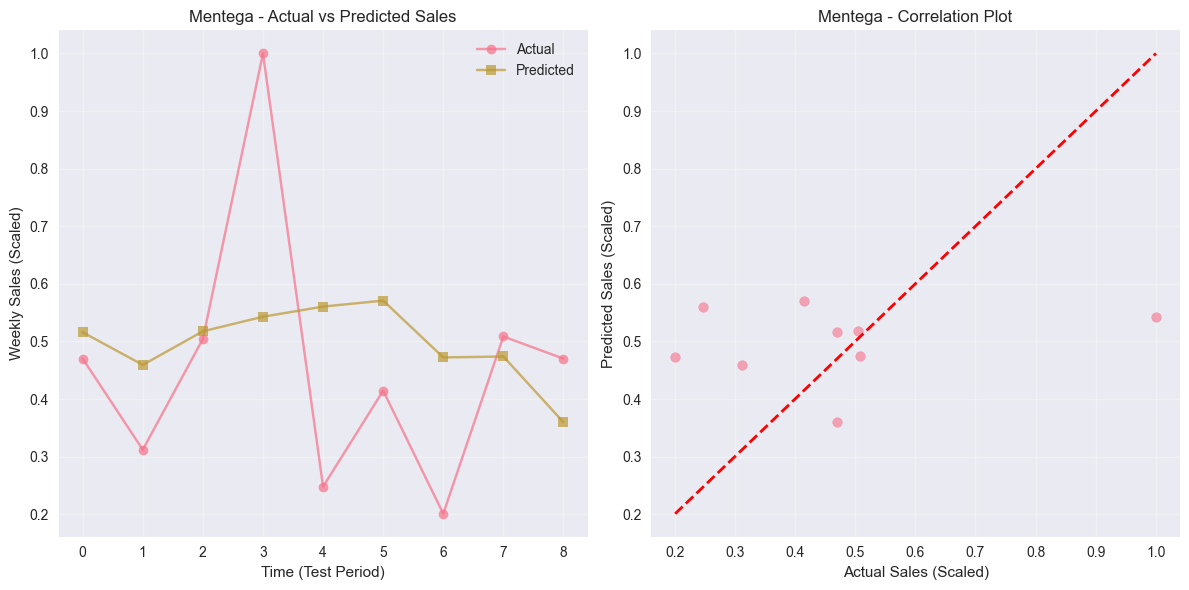

Plot saved to: results/plots/Mentega_predictions.png

Training LSTM model for category: Mie Instan
Processing category: Mie Instan
Data points for Mie Instan: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Mie Instan:


Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Mie Instan...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 960ms/step - loss: 0.2046 - mae: 0.3959 - val_loss: 0.1014 - val_mae: 0.2883
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 960ms/step - loss: 0.2046 - mae: 0.3959 - val_loss: 0.1014 - val_mae: 0.2883
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1540 - mae: 0.3298 - val_loss: 0.0618 - val_mae: 0.2263
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1540 - mae: 0.3298 - val_loss: 0.0618 - val_mae: 0.2263
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1097 - mae: 0.2675 - val_loss: 0.0345 - val_mae: 0.1594
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.1097 - mae: 0.2675 - val_loss: 0.0345 - val_mae: 0.1594
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0855 - mae: 0.2430 - val_loss: 0.0233 - val_mae: 0.1189
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 0.0855 - mae: 0.2430 - val_loss: 0.0233 - val_mae: 0.1189
Epoch 5/100
2/2 ━━━━━━━━━━━━━━


Mie Instan - Training Metrics:
  MSE: 0.0515
  RMSE: 0.2270
  MAE: 0.1758
  MAPE: 52.3136

Mie Instan - Test Metrics:
  MSE: 0.0793
  RMSE: 0.2815
  MAE: 0.2246
  MAPE: 41.2891

Model saved to: models/lstm_model_Mie Instan.h5
Scalers saved to: models/scaler_X_Mie Instan.pkl, models/scaler_y_Mie Instan.pkl


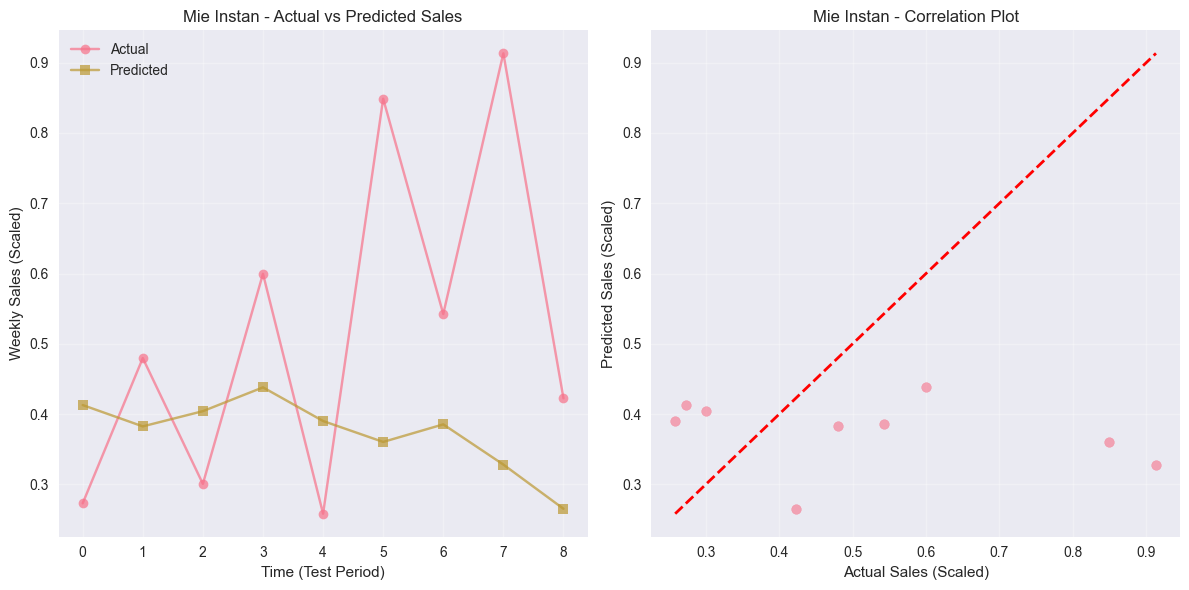

Plot saved to: results/plots/Mie Instan_predictions.png

Training LSTM model for category: Minuman Isotonik
Processing category: Minuman Isotonik
Data points for Minuman Isotonik: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Minuman Isotonik:


Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Minuman Isotonik...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 934ms/step - loss: 0.2341 - mae: 0.4361 - val_loss: 0.2147 - val_mae: 0.3571
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 934ms/step - loss: 0.2341 - mae: 0.4361 - val_loss: 0.2147 - val_mae: 0.3571
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1871 - mae: 0.3746 - val_loss: 0.1748 - val_mae: 0.3289
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1871 - mae: 0.3746 - val_loss: 0.1748 - val_mae: 0.3289
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1339 - mae: 0.3157 - val_loss: 0.1400 - val_mae: 0.3105
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.1339 - mae: 0.3157 - val_loss: 0.1400 - val_mae: 0.3105
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0963 - mae: 0.2713 - val_loss: 0.1154 - val_mae: 0.2975
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.0963 - mae: 0.2713 - val_loss: 0.1154 - val_mae: 0.2975
Epoch 5/100



Minuman Isotonik - Training Metrics:
  MSE: 0.0675
  RMSE: 0.2599
  MAE: 0.2041
  MAPE: 429.3377

Minuman Isotonik - Test Metrics:
  MSE: 0.0819
  RMSE: 0.2863
  MAE: 0.2506
  MAPE: 115.5795

Model saved to: models/lstm_model_Minuman Isotonik.h5
Scalers saved to: models/scaler_X_Minuman Isotonik.pkl, models/scaler_y_Minuman Isotonik.pkl

Model saved to: models/lstm_model_Minuman Isotonik.h5
Scalers saved to: models/scaler_X_Minuman Isotonik.pkl, models/scaler_y_Minuman Isotonik.pkl


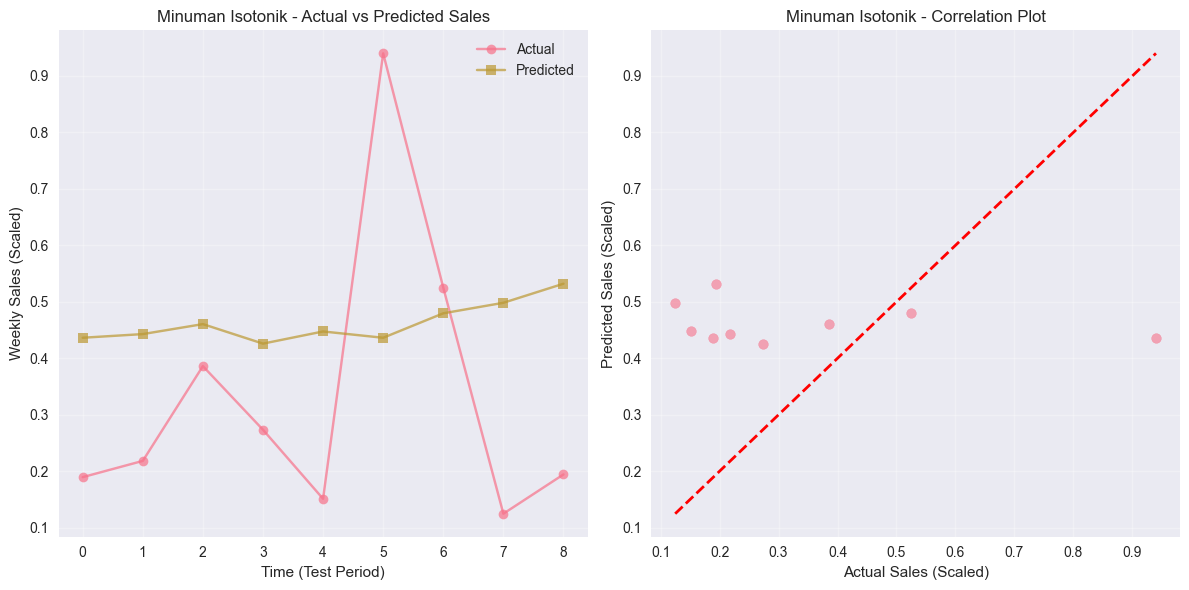

Plot saved to: results/plots/Minuman Isotonik_predictions.png

Training LSTM model for category: Minyak Goreng
Processing category: Minyak Goreng
Data points for Minyak Goreng: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Minyak Goreng:


Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Minyak Goreng...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 968ms/step - loss: 0.2919 - mae: 0.4880 - val_loss: 0.3051 - val_mae: 0.5418
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 968ms/step - loss: 0.2919 - mae: 0.4880 - val_loss: 0.3051 - val_mae: 0.5418
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.2622 - mae: 0.4602 - val_loss: 0.2805 - val_mae: 0.5186
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.2622 - mae: 0.4602 - val_loss: 0.2805 - val_mae: 0.5186
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2377 - mae: 0.4336 - val_loss: 0.2559 - val_mae: 0.4944
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2377 - mae: 0.4336 - val_loss: 0.2559 - val_mae: 0.4944
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2166 - mae: 0.4141 - val_loss: 0.2300 - val_mae: 0.4674
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 0.2166 - mae: 0.4141 - val_loss: 0.2300 - val_mae: 0.4674
Epoch 5/100
2/2


Minyak Goreng - Training Metrics:
  MSE: 0.0594
  RMSE: 0.2436
  MAE: 0.2072
  MAPE: 103.2607

Minyak Goreng - Test Metrics:
  MSE: 0.0719
  RMSE: 0.2682
  MAE: 0.1981
  MAPE: 53.9265

Model saved to: models/lstm_model_Minyak Goreng.h5
Scalers saved to: models/scaler_X_Minyak Goreng.pkl, models/scaler_y_Minyak Goreng.pkl


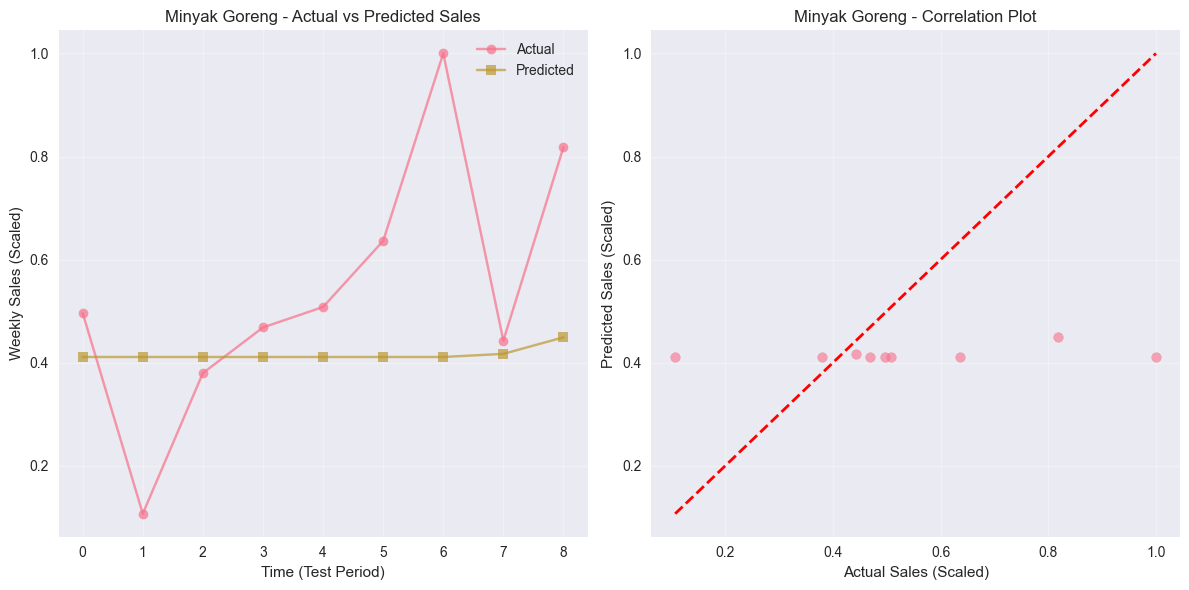

Plot saved to: results/plots/Minyak Goreng_predictions.png

Training LSTM model for category: Nugget
Processing category: Nugget
Data points for Nugget: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Nugget:


Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Nugget...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 999ms/step - loss: 0.3517 - mae: 0.5397 - val_loss: 0.2978 - val_mae: 0.5001
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 999ms/step - loss: 0.3517 - mae: 0.5397 - val_loss: 0.2978 - val_mae: 0.5001
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.3103 - mae: 0.4977 - val_loss: 0.2606 - val_mae: 0.4623
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.3103 - mae: 0.4977 - val_loss: 0.2606 - val_mae: 0.4623
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.2690 - mae: 0.4609 - val_loss: 0.2238 - val_mae: 0.4215
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.2690 - mae: 0.4609 - val_loss: 0.2238 - val_mae: 0.4215
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2308 - mae: 0.4230 - val_loss: 0.1863 - val_mae: 0.3755
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2308 - mae: 0.4230 - val_loss: 0.1863 - val_mae: 0.3755
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━


Nugget - Training Metrics:
  MSE: 0.0753
  RMSE: 0.2745
  MAE: 0.2149
  MAPE: 109.4192

Nugget - Test Metrics:
  MSE: 0.0821
  RMSE: 0.2865
  MAE: 0.2147
  MAPE: 25.1789

Model saved to: models/lstm_model_Nugget.h5
Scalers saved to: models/scaler_X_Nugget.pkl, models/scaler_y_Nugget.pkl


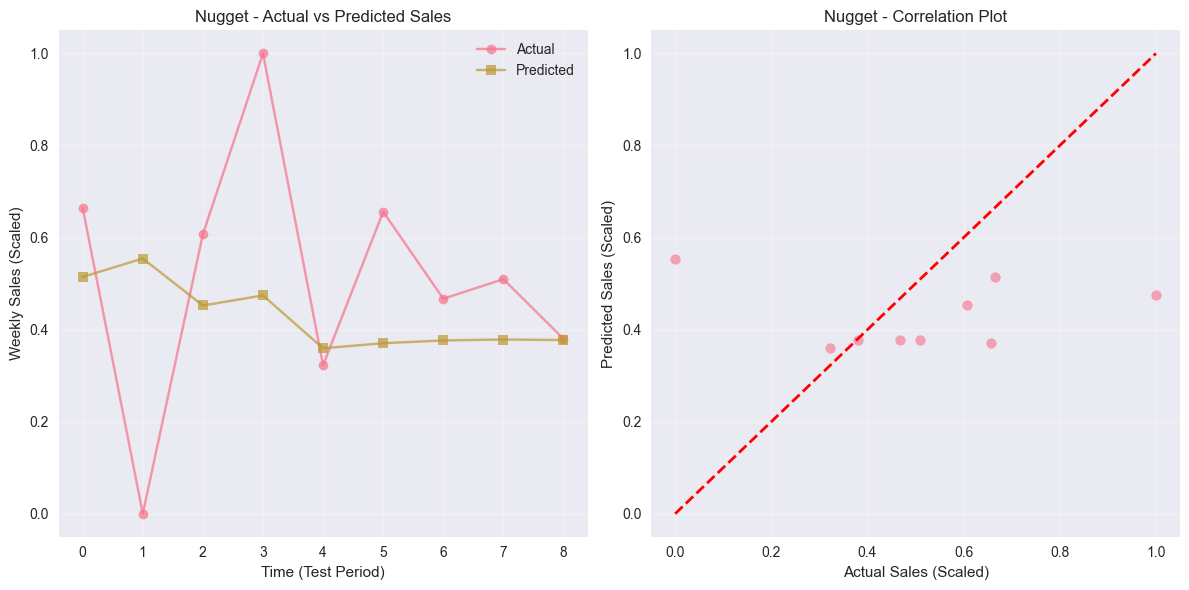

Plot saved to: results/plots/Nugget_predictions.png

Training LSTM model for category: Pasta
Processing category: Pasta
Data points for Pasta: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Pasta:


Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Pasta...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 929ms/step - loss: 0.3054 - mae: 0.5284 - val_loss: 0.1743 - val_mae: 0.3475
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 929ms/step - loss: 0.3054 - mae: 0.5284 - val_loss: 0.1743 - val_mae: 0.3475
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.2317 - mae: 0.4536 - val_loss: 0.1428 - val_mae: 0.2985
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - loss: 0.2317 - mae: 0.4536 - val_loss: 0.1428 - val_mae: 0.2985
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1920 - mae: 0.4063 - val_loss: 0.1183 - val_mae: 0.2655
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.1920 - mae: 0.4063 - val_loss: 0.1183 - val_mae: 0.2655
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1482 - mae: 0.3515 - val_loss: 0.0945 - val_mae: 0.2265
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.1482 - mae: 0.3515 - val_loss: 0.0945 - val_mae: 0.2265
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━


Pasta - Training Metrics:
  MSE: 0.0344
  RMSE: 0.1856
  MAE: 0.1541
  MAPE: 42.8477

Pasta - Test Metrics:
  MSE: 0.0600
  RMSE: 0.2450
  MAE: 0.1703
  MAPE: 106.4794

Model saved to: models/lstm_model_Pasta.h5
Scalers saved to: models/scaler_X_Pasta.pkl, models/scaler_y_Pasta.pkl


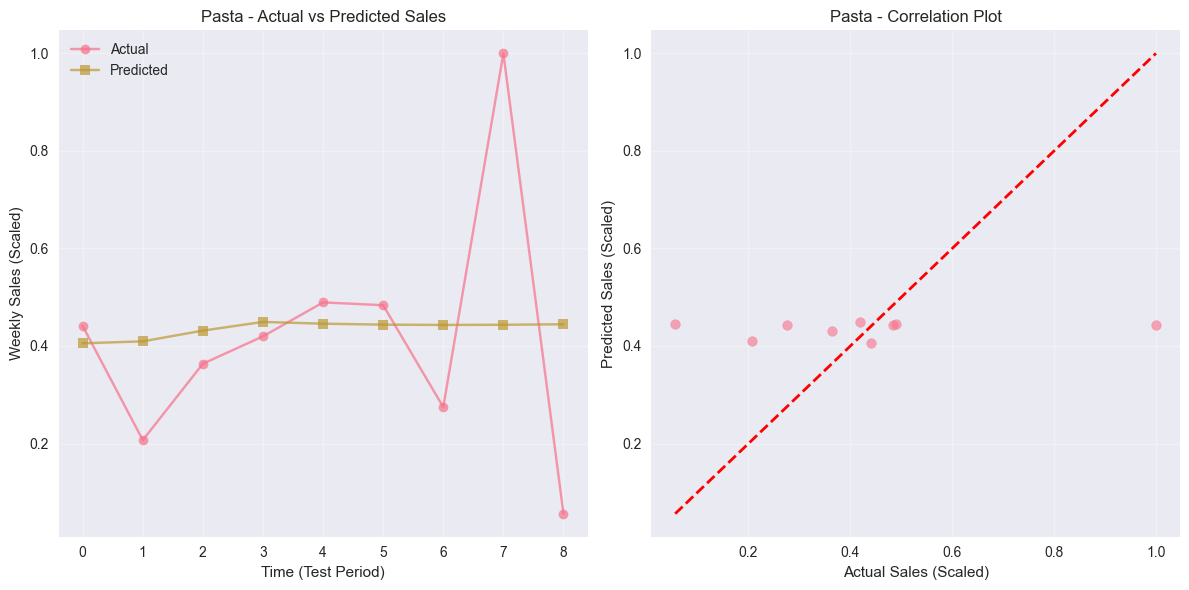

Plot saved to: results/plots/Pasta_predictions.png

Training LSTM model for category: Penyedap Rasa
Processing category: Penyedap Rasa
Data points for Penyedap Rasa: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Penyedap Rasa:


Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Penyedap Rasa...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 975ms/step - loss: 0.3167 - mae: 0.5197 - val_loss: 0.2886 - val_mae: 0.4763
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 975ms/step - loss: 0.3167 - mae: 0.5197 - val_loss: 0.2886 - val_mae: 0.4763
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.2625 - mae: 0.4695 - val_loss: 0.2194 - val_mae: 0.4139
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.2625 - mae: 0.4695 - val_loss: 0.2194 - val_mae: 0.4139
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2067 - mae: 0.4171 - val_loss: 0.1599 - val_mae: 0.3429
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.2067 - mae: 0.4171 - val_loss: 0.1599 - val_mae: 0.3429
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.1450 - mae: 0.3484 - val_loss: 0.1175 - val_mae: 0.3075
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.1450 - mae: 0.3484 - val_loss: 0.1175 - val_mae: 0.3075
Epoch 5/100
2/2


Penyedap Rasa - Training Metrics:
  MSE: 0.0624
  RMSE: 0.2497
  MAE: 0.2073
  MAPE: 201.2142

Penyedap Rasa - Test Metrics:
  MSE: 0.0497
  RMSE: 0.2229
  MAE: 0.1791
  MAPE: 82.9601

Model saved to: models/lstm_model_Penyedap Rasa.h5
Scalers saved to: models/scaler_X_Penyedap Rasa.pkl, models/scaler_y_Penyedap Rasa.pkl


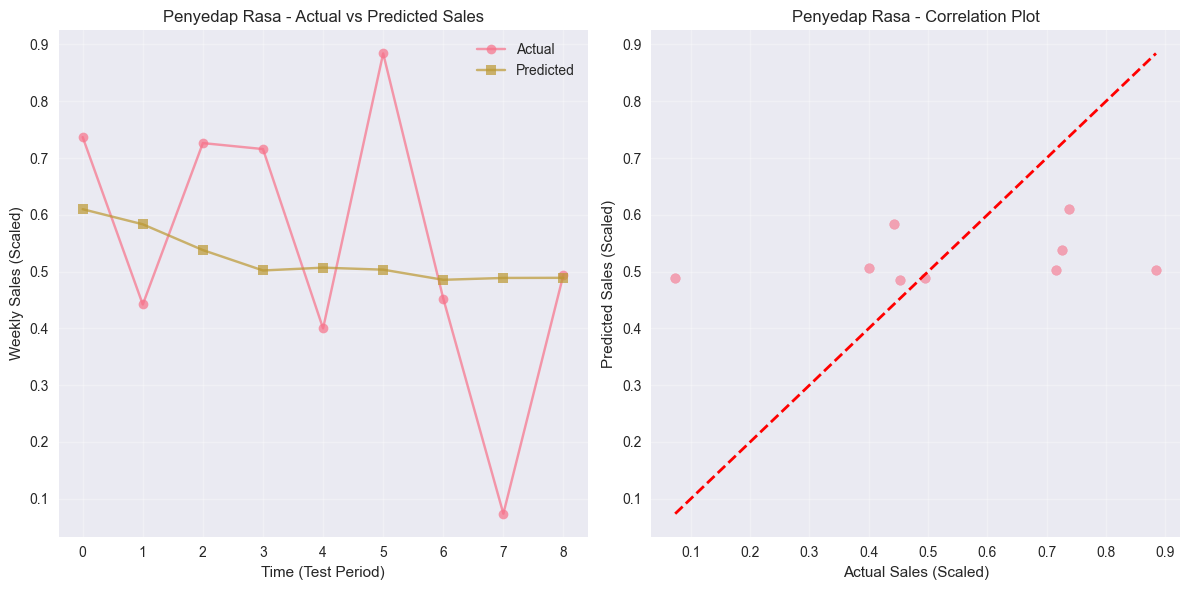

Plot saved to: results/plots/Penyedap Rasa_predictions.png

Training LSTM model for category: Permen
Processing category: Permen
Data points for Permen: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Permen:


Model: "sequential_83"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Permen...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 943ms/step - loss: 0.3183 - mae: 0.5088 - val_loss: 0.2383 - val_mae: 0.4226
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 943ms/step - loss: 0.3183 - mae: 0.5088 - val_loss: 0.2383 - val_mae: 0.4226
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.2531 - mae: 0.4443 - val_loss: 0.1936 - val_mae: 0.3805
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.2531 - mae: 0.4443 - val_loss: 0.1936 - val_mae: 0.3805
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2134 - mae: 0.4072 - val_loss: 0.1510 - val_mae: 0.3336
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.2134 - mae: 0.4072 - val_loss: 0.1510 - val_mae: 0.3336
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1622 - mae: 0.3416 - val_loss: 0.1126 - val_mae: 0.2804
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1622 - mae: 0.3416 - val_loss: 0.1126 - val_mae: 0.2804
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━


Permen - Training Metrics:
  MSE: 0.0615
  RMSE: 0.2480
  MAE: 0.2001
  MAPE: 104.8032

Permen - Test Metrics:
  MSE: 0.0568
  RMSE: 0.2383
  MAE: 0.1845
  MAPE: 26.0839

Model saved to: models/lstm_model_Permen.h5
Scalers saved to: models/scaler_X_Permen.pkl, models/scaler_y_Permen.pkl


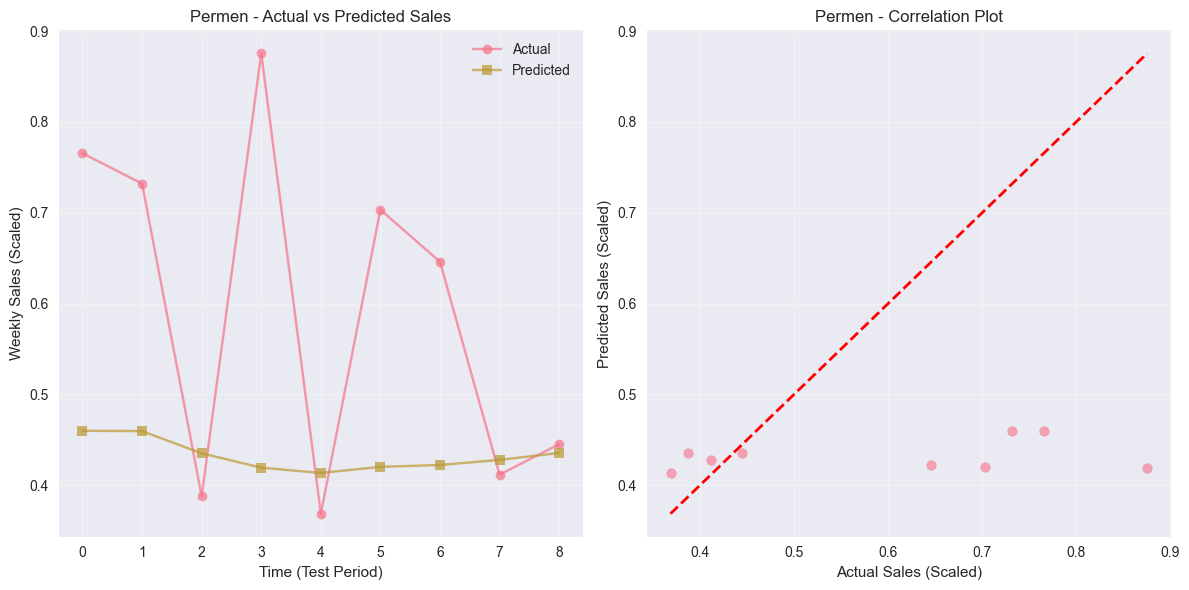

Plot saved to: results/plots/Permen_predictions.png

Training LSTM model for category: Roti
Processing category: Roti
Data points for Roti: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Roti:


Model: "sequential_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Roti...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 963ms/step - loss: 0.2738 - mae: 0.4588 - val_loss: 0.2024 - val_mae: 0.3901
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 963ms/step - loss: 0.2738 - mae: 0.4588 - val_loss: 0.2024 - val_mae: 0.3901
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.2169 - mae: 0.3990 - val_loss: 0.1668 - val_mae: 0.3528
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.2169 - mae: 0.3990 - val_loss: 0.1668 - val_mae: 0.3528
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.1953 - mae: 0.3741 - val_loss: 0.1343 - val_mae: 0.3127
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.1953 - mae: 0.3741 - val_loss: 0.1343 - val_mae: 0.3127
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.1481 - mae: 0.3162 - val_loss: 0.1047 - val_mae: 0.2673
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - loss: 0.1481 - mae: 0.3162 - val_loss: 0.1047 - val_mae: 0.2673
Epoch 5/100
2/2 ━━━━━━━━


Roti - Training Metrics:
  MSE: 0.0615
  RMSE: 0.2480
  MAE: 0.2047
  MAPE: 160.0842

Roti - Test Metrics:
  MSE: 0.0677
  RMSE: 0.2603
  MAE: 0.2237
  MAPE: 215.7024

Model saved to: models/lstm_model_Roti.h5
Scalers saved to: models/scaler_X_Roti.pkl, models/scaler_y_Roti.pkl


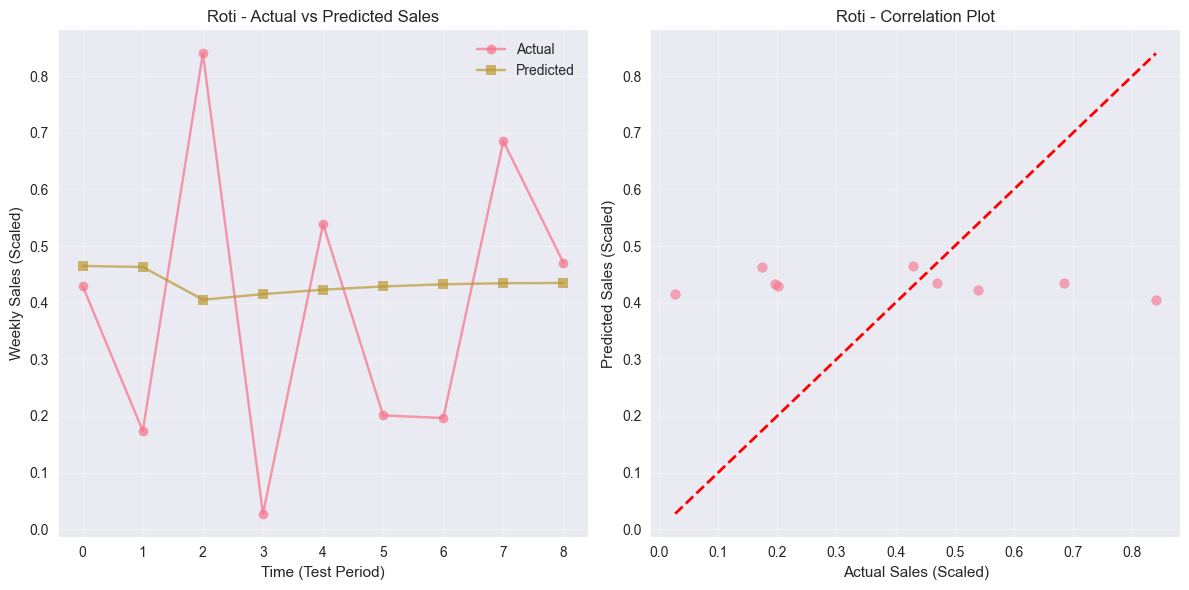

Plot saved to: results/plots/Roti_predictions.png

Training LSTM model for category: Saos
Processing category: Saos
Data points for Saos: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Saos:


Model: "sequential_85"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Saos...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.3305 - mae: 0.5444 - val_loss: 0.2531 - val_mae: 0.4589
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.3305 - mae: 0.5444 - val_loss: 0.2531 - val_mae: 0.4589
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.3012 - mae: 0.5176 - val_loss: 0.2178 - val_mae: 0.4191
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.3012 - mae: 0.5176 - val_loss: 0.2178 - val_mae: 0.4191
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.2717 - mae: 0.4924 - val_loss: 0.1833 - val_mae: 0.3761
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.2717 - mae: 0.4924 - val_loss: 0.1833 - val_mae: 0.3761
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2356 - mae: 0.4541 - val_loss: 0.1492 - val_mae: 0.3279
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.2356 - mae: 0.4541 - val_loss: 0.1492 - val_mae: 0.3279
Epoch 5/100
2/2 ━━━━━━━━━━━━━━


Saos - Training Metrics:
  MSE: 0.0527
  RMSE: 0.2295
  MAE: 0.1847
  MAPE: 32.7107

Saos - Test Metrics:
  MSE: 0.0439
  RMSE: 0.2095
  MAE: 0.1625
  MAPE: 29.4164

Model saved to: models/lstm_model_Saos.h5
Scalers saved to: models/scaler_X_Saos.pkl, models/scaler_y_Saos.pkl


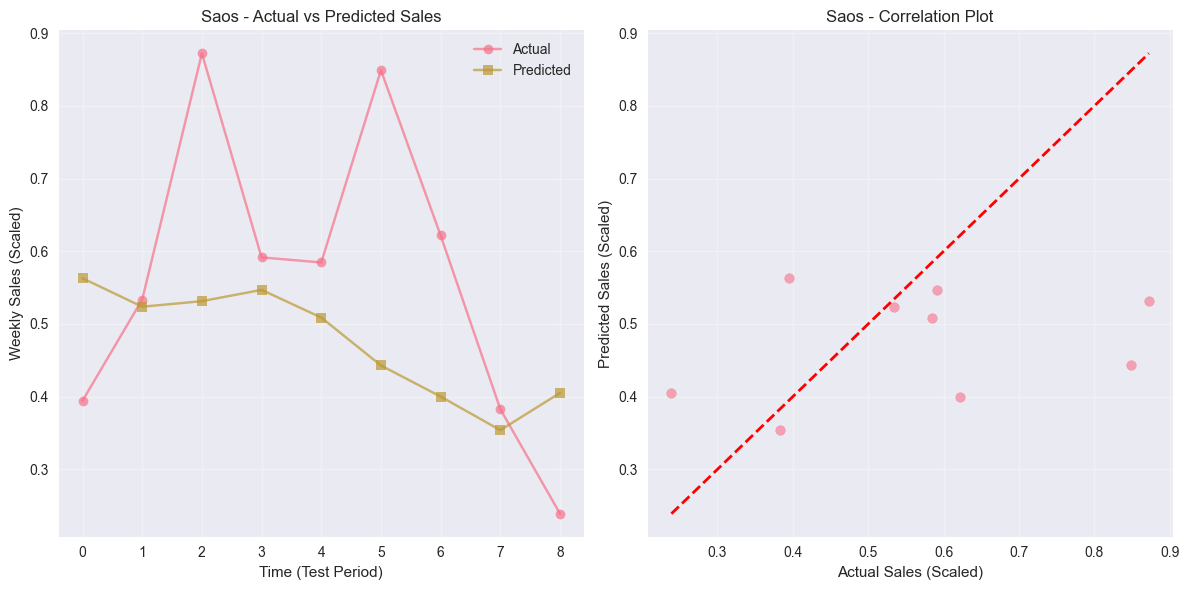

Plot saved to: results/plots/Saos_predictions.png

Training LSTM model for category: Sarden Kaleng
Processing category: Sarden Kaleng
Data points for Sarden Kaleng: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Sarden Kaleng:


Model: "sequential_86"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Sarden Kaleng...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 956ms/step - loss: 0.2031 - mae: 0.3912 - val_loss: 0.1401 - val_mae: 0.3136
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 956ms/step - loss: 0.2031 - mae: 0.3912 - val_loss: 0.1401 - val_mae: 0.3136
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.1597 - mae: 0.3272 - val_loss: 0.1104 - val_mae: 0.2765
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - loss: 0.1597 - mae: 0.3272 - val_loss: 0.1104 - val_mae: 0.2765
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1232 - mae: 0.2794 - val_loss: 0.0836 - val_mae: 0.2353
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1232 - mae: 0.2794 - val_loss: 0.0836 - val_mae: 0.2353
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0948 - mae: 0.2390 - val_loss: 0.0610 - val_mae: 0.1879
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0948 - mae: 0.2390 - val_loss: 0.0610 - val_mae: 0.1879
Epoch 5/100
2/2 ━━━━━━━━━━━


Sarden Kaleng - Training Metrics:
  MSE: 0.0494
  RMSE: 0.2223
  MAE: 0.1741
  MAPE: 117.2754

Sarden Kaleng - Test Metrics:
  MSE: 0.0555
  RMSE: 0.2355
  MAE: 0.1983
  MAPE: 247.0442

Model saved to: models/lstm_model_Sarden Kaleng.h5
Scalers saved to: models/scaler_X_Sarden Kaleng.pkl, models/scaler_y_Sarden Kaleng.pkl


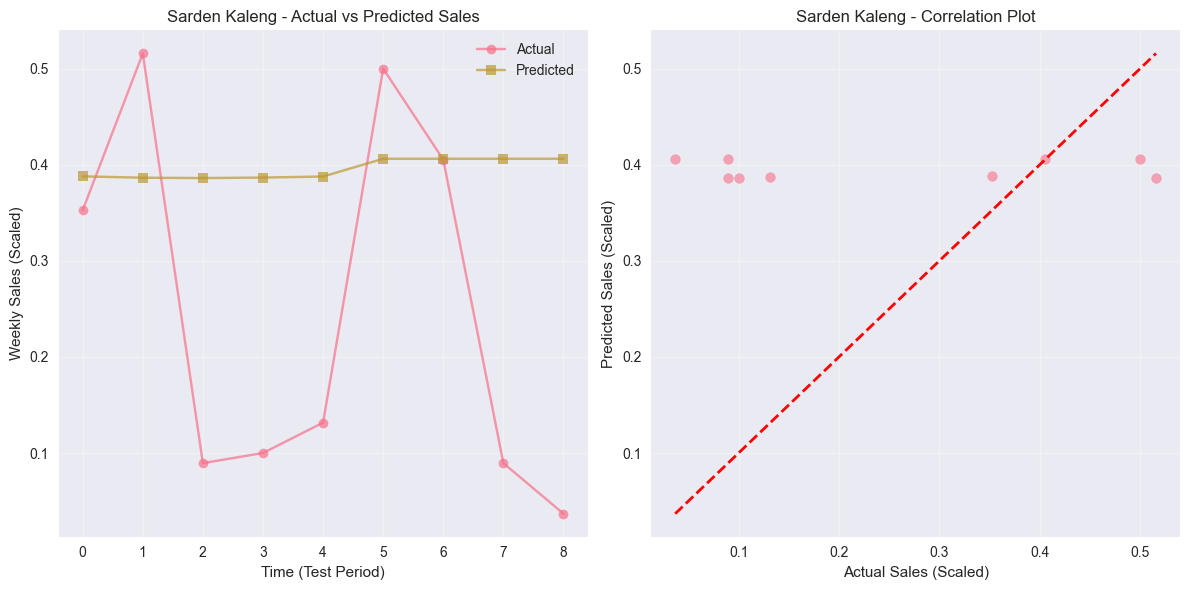

Plot saved to: results/plots/Sarden Kaleng_predictions.png

Training LSTM model for category: Sayur-Sayuran
Processing category: Sayur-Sayuran
Data points for Sayur-Sayuran: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Sayur-Sayuran:


Model: "sequential_87"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Sayur-Sayuran...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.2607 - mae: 0.4744 - val_loss: 0.3004 - val_mae: 0.4313
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.2607 - mae: 0.4744 - val_loss: 0.3004 - val_mae: 0.4313
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1868 - mae: 0.3878 - val_loss: 0.2399 - val_mae: 0.3946
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.1868 - mae: 0.3878 - val_loss: 0.2399 - val_mae: 0.3946
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1192 - mae: 0.2989 - val_loss: 0.1870 - val_mae: 0.3568
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.1192 - mae: 0.2989 - val_loss: 0.1870 - val_mae: 0.3568
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0836 - mae: 0.2401 - val_loss: 0.1461 - val_mae: 0.3344
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0836 - mae: 0.2401 - val_loss: 0.1461 - val_mae: 0.3344
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━


Sayur-Sayuran - Training Metrics:
  MSE: 0.0633
  RMSE: 0.2515
  MAE: 0.2005
  MAPE: 71.2607

Sayur-Sayuran - Test Metrics:
  MSE: 0.0175
  RMSE: 0.1322
  MAE: 0.1063
  MAPE: 20.8954

Model saved to: models/lstm_model_Sayur-Sayuran.h5
Scalers saved to: models/scaler_X_Sayur-Sayuran.pkl, models/scaler_y_Sayur-Sayuran.pkl


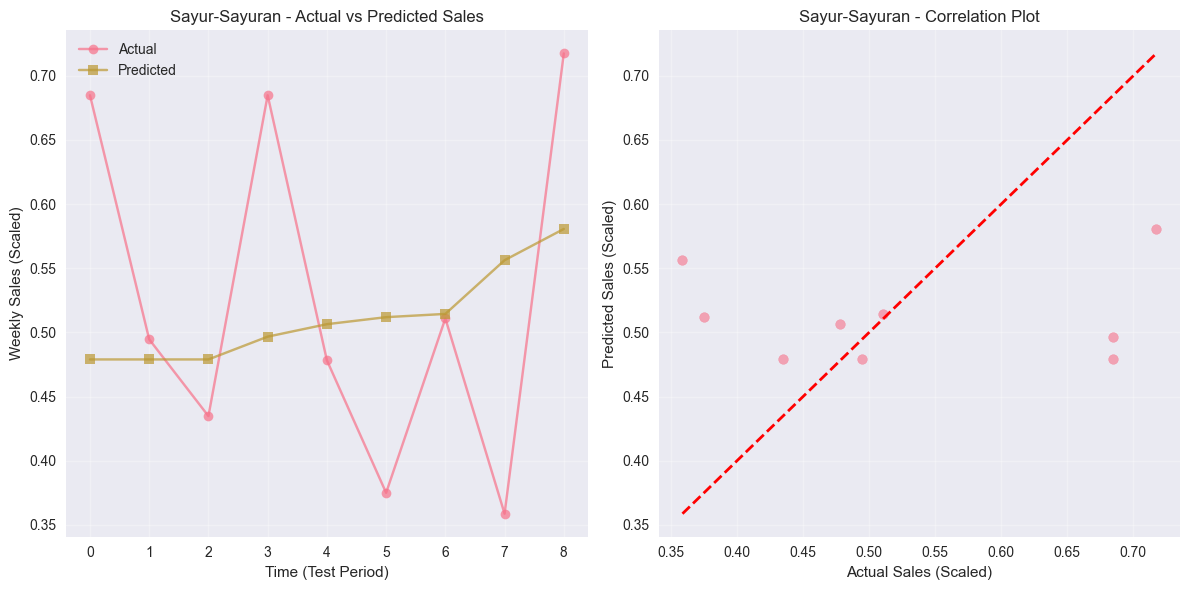

Plot saved to: results/plots/Sayur-Sayuran_predictions.png

Training LSTM model for category: Seafood Segar
Processing category: Seafood Segar
Data points for Seafood Segar: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Seafood Segar:


Model: "sequential_88"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Seafood Segar...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 969ms/step - loss: 0.3623 - mae: 0.5755 - val_loss: 0.4032 - val_mae: 0.5712
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 969ms/step - loss: 0.3623 - mae: 0.5755 - val_loss: 0.4032 - val_mae: 0.5712
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2318 - mae: 0.4530 - val_loss: 0.2758 - val_mae: 0.4726
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2318 - mae: 0.4530 - val_loss: 0.2758 - val_mae: 0.4726
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.1499 - mae: 0.3509 - val_loss: 0.1727 - val_mae: 0.3757
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - loss: 0.1499 - mae: 0.3509 - val_loss: 0.1727 - val_mae: 0.3757
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1024 - mae: 0.2733 - val_loss: 0.1054 - val_mae: 0.2806
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.1024 - mae: 0.2733 - val_loss: 0.1054 - val_mae: 0.2806
Epoch 5/100
2/2 ━━━━━━━━━━━


Seafood Segar - Training Metrics:
  MSE: 0.0552
  RMSE: 0.2350
  MAE: 0.1733
  MAPE: 40.0356

Seafood Segar - Test Metrics:
  MSE: 0.0314
  RMSE: 0.1773
  MAE: 0.1358
  MAPE: 31.3595

Model saved to: models/lstm_model_Seafood Segar.h5
Scalers saved to: models/scaler_X_Seafood Segar.pkl, models/scaler_y_Seafood Segar.pkl


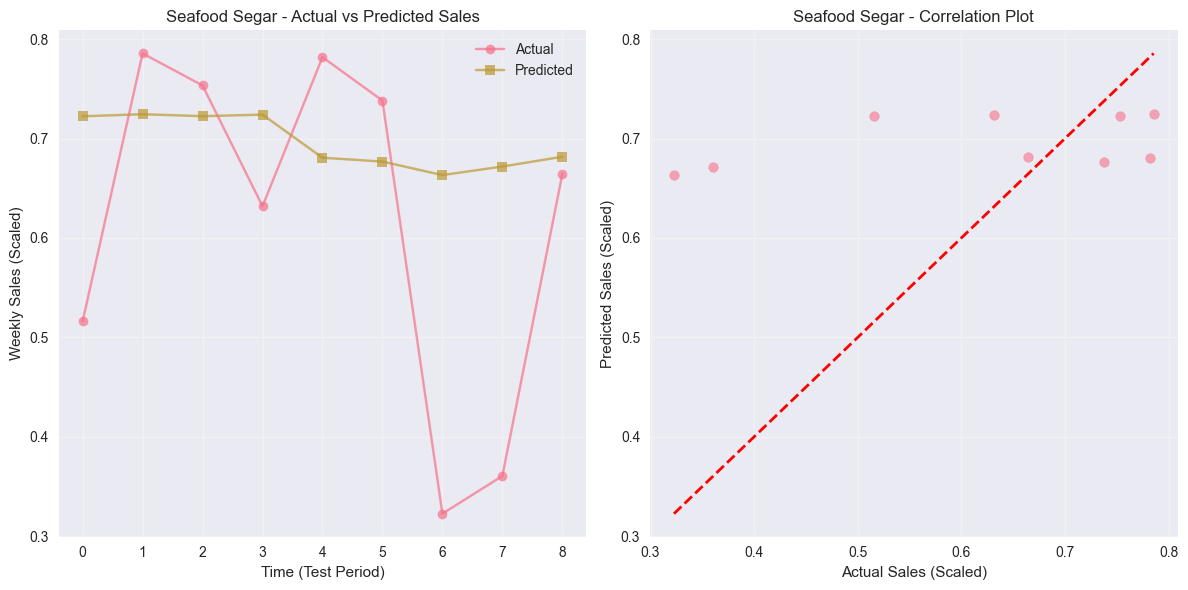

Plot saved to: results/plots/Seafood Segar_predictions.png

Training LSTM model for category: Selai
Processing category: Selai
Data points for Selai: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Selai:


Model: "sequential_89"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Selai...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 928ms/step - loss: 0.4903 - mae: 0.6490 - val_loss: 0.3363 - val_mae: 0.5113
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 928ms/step - loss: 0.4903 - mae: 0.6490 - val_loss: 0.3363 - val_mae: 0.5113
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.3667 - mae: 0.5499 - val_loss: 0.2800 - val_mae: 0.4688
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - loss: 0.3667 - mae: 0.5499 - val_loss: 0.2800 - val_mae: 0.4688
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.2794 - mae: 0.4754 - val_loss: 0.2392 - val_mae: 0.4331
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.2794 - mae: 0.4754 - val_loss: 0.2392 - val_mae: 0.4331
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2703 - mae: 0.4487 - val_loss: 0.2050 - val_mae: 0.4000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.2703 - mae: 0.4487 - val_loss: 0.2050 - val_mae: 0.4000
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━


Selai - Training Metrics:
  MSE: 0.0654
  RMSE: 0.2557
  MAE: 0.2091
  MAPE: 102.3606

Selai - Test Metrics:
  MSE: 0.0491
  RMSE: 0.2216
  MAE: 0.1885
  MAPE: 43.3573

Model saved to: models/lstm_model_Selai.h5
Scalers saved to: models/scaler_X_Selai.pkl, models/scaler_y_Selai.pkl


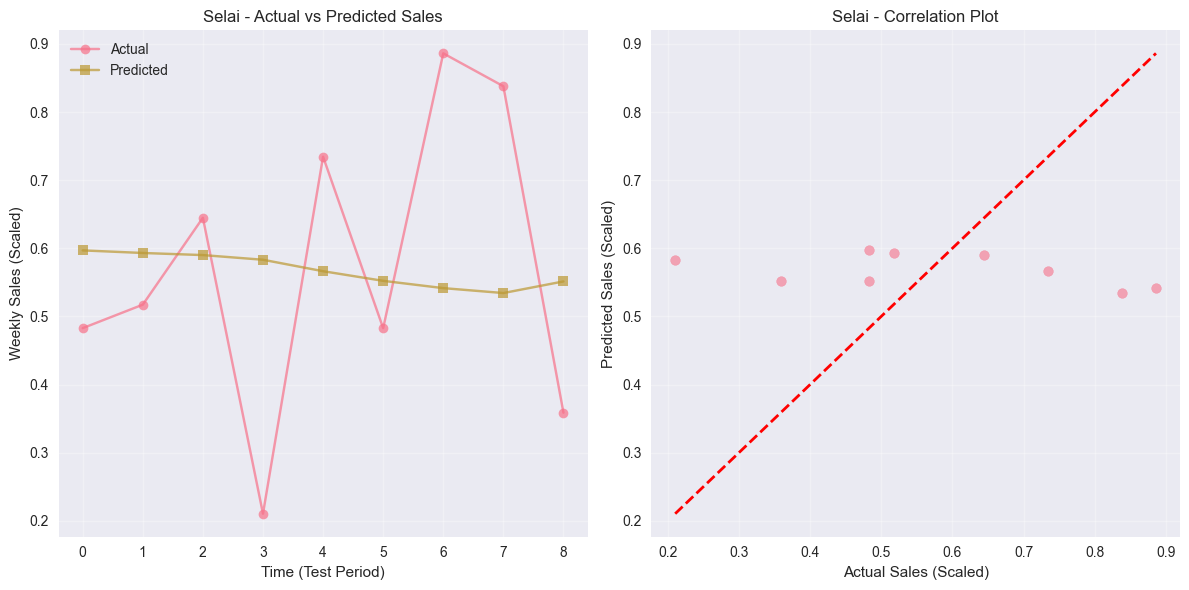

Plot saved to: results/plots/Selai_predictions.png

Training LSTM model for category: Sereal
Processing category: Sereal
Data points for Sereal: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Sereal:


Model: "sequential_90"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Sereal...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.2833 - mae: 0.4735 - val_loss: 0.2323 - val_mae: 0.4599
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - loss: 0.2833 - mae: 0.4735 - val_loss: 0.2323 - val_mae: 0.4599
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.2363 - mae: 0.4242 - val_loss: 0.1739 - val_mae: 0.3910
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 0.2363 - mae: 0.4242 - val_loss: 0.1739 - val_mae: 0.3910
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1944 - mae: 0.3784 - val_loss: 0.1229 - val_mae: 0.3183
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1944 - mae: 0.3784 - val_loss: 0.1229 - val_mae: 0.3183
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1508 - mae: 0.3112 - val_loss: 0.0795 - val_mae: 0.2469
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.1508 - mae: 0.3112 - val_loss: 0.0795 - val_mae: 0.2469
Epoch 5/100
2/2 ━━━━━━━━━━━━


Sereal - Training Metrics:
  MSE: 0.0488
  RMSE: 0.2209
  MAE: 0.1833
  MAPE: 63.3955

Sereal - Test Metrics:
  MSE: 0.1328
  RMSE: 0.3644
  MAE: 0.3039
  MAPE: 71.6117

Model saved to: models/lstm_model_Sereal.h5
Scalers saved to: models/scaler_X_Sereal.pkl, models/scaler_y_Sereal.pkl


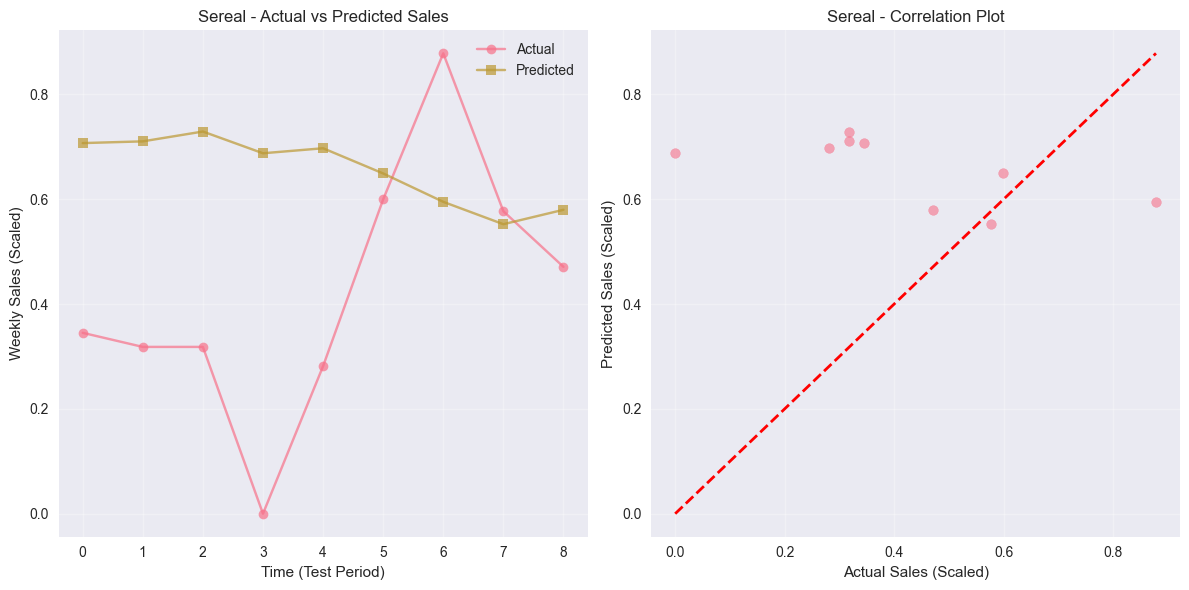

Plot saved to: results/plots/Sereal_predictions.png

Training LSTM model for category: Sirup
Processing category: Sirup
Data points for Sirup: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Sirup:


Model: "sequential_91"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Sirup...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 987ms/step - loss: 0.4370 - mae: 0.6183 - val_loss: 0.2418 - val_mae: 0.4617
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 987ms/step - loss: 0.4370 - mae: 0.6183 - val_loss: 0.2418 - val_mae: 0.4617
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.3518 - mae: 0.5521 - val_loss: 0.1952 - val_mae: 0.4087
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - loss: 0.3518 - mae: 0.5521 - val_loss: 0.1952 - val_mae: 0.4087
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.2736 - mae: 0.4849 - val_loss: 0.1445 - val_mae: 0.3419
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.2736 - mae: 0.4849 - val_loss: 0.1445 - val_mae: 0.3419
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2371 - mae: 0.4491 - val_loss: 0.0959 - val_mae: 0.2627
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - loss: 0.2371 - mae: 0.4491 - val_loss: 0.0959 - val_mae: 0.2627
Epoch 5/100
2/2 ━━━━━━━


Sirup - Training Metrics:
  MSE: 0.0450
  RMSE: 0.2121
  MAE: 0.1711
  MAPE: 37.9574

Sirup - Test Metrics:
  MSE: 0.0657
  RMSE: 0.2563
  MAE: 0.2098
  MAPE: 92.9283

Model saved to: models/lstm_model_Sirup.h5
Scalers saved to: models/scaler_X_Sirup.pkl, models/scaler_y_Sirup.pkl


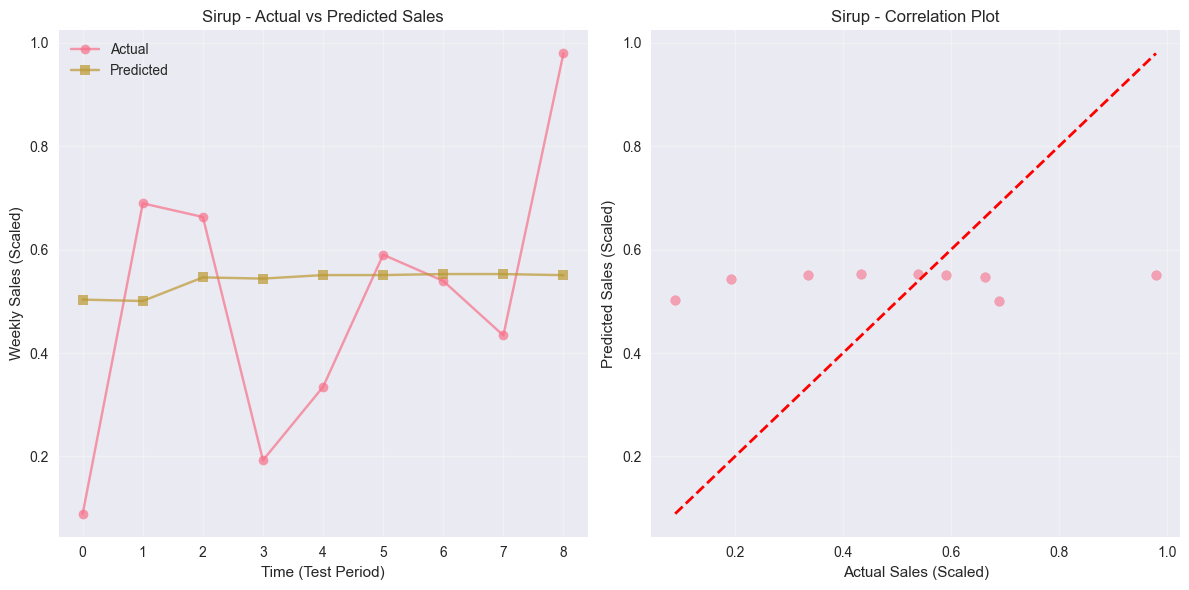

Plot saved to: results/plots/Sirup_predictions.png

Training LSTM model for category: Soda
Processing category: Soda
Data points for Soda: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Soda:


Model: "sequential_92"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Soda...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 941ms/step - loss: 0.2747 - mae: 0.4832 - val_loss: 0.2663 - val_mae: 0.4333
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 941ms/step - loss: 0.2747 - mae: 0.4832 - val_loss: 0.2663 - val_mae: 0.4333
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2273 - mae: 0.4384 - val_loss: 0.2122 - val_mae: 0.3650
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.2273 - mae: 0.4384 - val_loss: 0.2122 - val_mae: 0.3650
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1776 - mae: 0.3804 - val_loss: 0.1607 - val_mae: 0.2847
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1776 - mae: 0.3804 - val_loss: 0.1607 - val_mae: 0.2847
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1230 - mae: 0.3011 - val_loss: 0.1165 - val_mae: 0.2206
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.1230 - mae: 0.3011 - val_loss: 0.1165 - val_mae: 0.2206
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━


Soda - Training Metrics:
  MSE: 0.0521
  RMSE: 0.2282
  MAE: 0.1848
  MAPE: 135.8903

Soda - Test Metrics:
  MSE: 0.0806
  RMSE: 0.2838
  MAE: 0.2696
  MAPE: 125.7265

Model saved to: models/lstm_model_Soda.h5
Scalers saved to: models/scaler_X_Soda.pkl, models/scaler_y_Soda.pkl


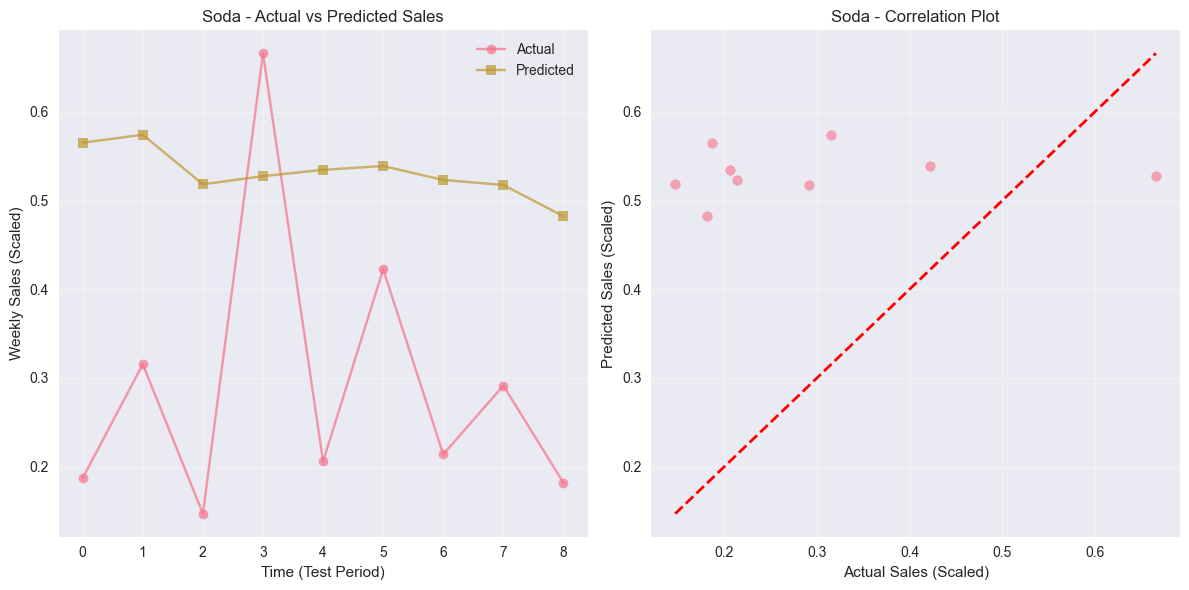

Plot saved to: results/plots/Soda_predictions.png

Training LSTM model for category: Susu Bubuk
Processing category: Susu Bubuk
Data points for Susu Bubuk: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Susu Bubuk:


Model: "sequential_93"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Susu Bubuk...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 910ms/step - loss: 0.4813 - mae: 0.6369 - val_loss: 0.6010 - val_mae: 0.7523
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 910ms/step - loss: 0.4813 - mae: 0.6369 - val_loss: 0.6010 - val_mae: 0.7523
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.4125 - mae: 0.5777 - val_loss: 0.5385 - val_mae: 0.7096
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.4125 - mae: 0.5777 - val_loss: 0.5385 - val_mae: 0.7096
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.3520 - mae: 0.5310 - val_loss: 0.4841 - val_mae: 0.6702
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.3520 - mae: 0.5310 - val_loss: 0.4841 - val_mae: 0.6702
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.3032 - mae: 0.4905 - val_loss: 0.4209 - val_mae: 0.6214
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - loss: 0.3032 - mae: 0.4905 - val_loss: 0.4209 - val_mae: 0.6214
Epoch 5/100
2/2 ━━


Susu Bubuk - Training Metrics:
  MSE: 0.0855
  RMSE: 0.2924
  MAE: 0.2205
  MAPE: 93.7379

Susu Bubuk - Test Metrics:
  MSE: 0.0860
  RMSE: 0.2933
  MAE: 0.2584
  MAPE: 63.1850

Model saved to: models/lstm_model_Susu Bubuk.h5
Scalers saved to: models/scaler_X_Susu Bubuk.pkl, models/scaler_y_Susu Bubuk.pkl

Model saved to: models/lstm_model_Susu Bubuk.h5
Scalers saved to: models/scaler_X_Susu Bubuk.pkl, models/scaler_y_Susu Bubuk.pkl


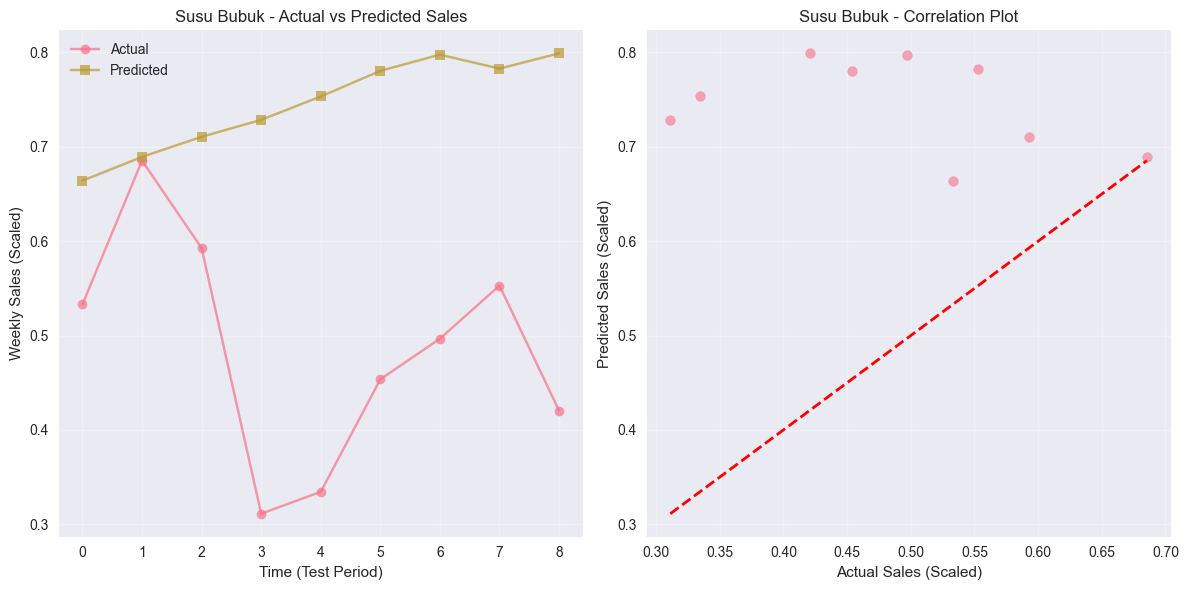

Plot saved to: results/plots/Susu Bubuk_predictions.png

Training LSTM model for category: Susu Kemasan
Processing category: Susu Kemasan
Data points for Susu Kemasan: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Susu Kemasan:


Model: "sequential_94"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Susu Kemasan...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 934ms/step - loss: 0.2345 - mae: 0.4204 - val_loss: 0.1245 - val_mae: 0.3279
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 934ms/step - loss: 0.2345 - mae: 0.4204 - val_loss: 0.1245 - val_mae: 0.3279
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1869 - mae: 0.3723 - val_loss: 0.0784 - val_mae: 0.2475
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.1869 - mae: 0.3723 - val_loss: 0.0784 - val_mae: 0.2475
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1306 - mae: 0.2998 - val_loss: 0.0410 - val_mae: 0.1704
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.1306 - mae: 0.2998 - val_loss: 0.0410 - val_mae: 0.1704
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0879 - mae: 0.2405 - val_loss: 0.0206 - val_mae: 0.1238
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - loss: 0.0879 - mae: 0.2405 - val_loss: 0.0206 - val_mae: 0.1238
Epoch 5/100
2/2 


Susu Kemasan - Training Metrics:
  MSE: 0.0466
  RMSE: 0.2158
  MAE: 0.1770
  MAPE: 99.1365

Susu Kemasan - Test Metrics:
  MSE: 0.0360
  RMSE: 0.1897
  MAE: 0.1419
  MAPE: 37.0354

Model saved to: models/lstm_model_Susu Kemasan.h5
Scalers saved to: models/scaler_X_Susu Kemasan.pkl, models/scaler_y_Susu Kemasan.pkl


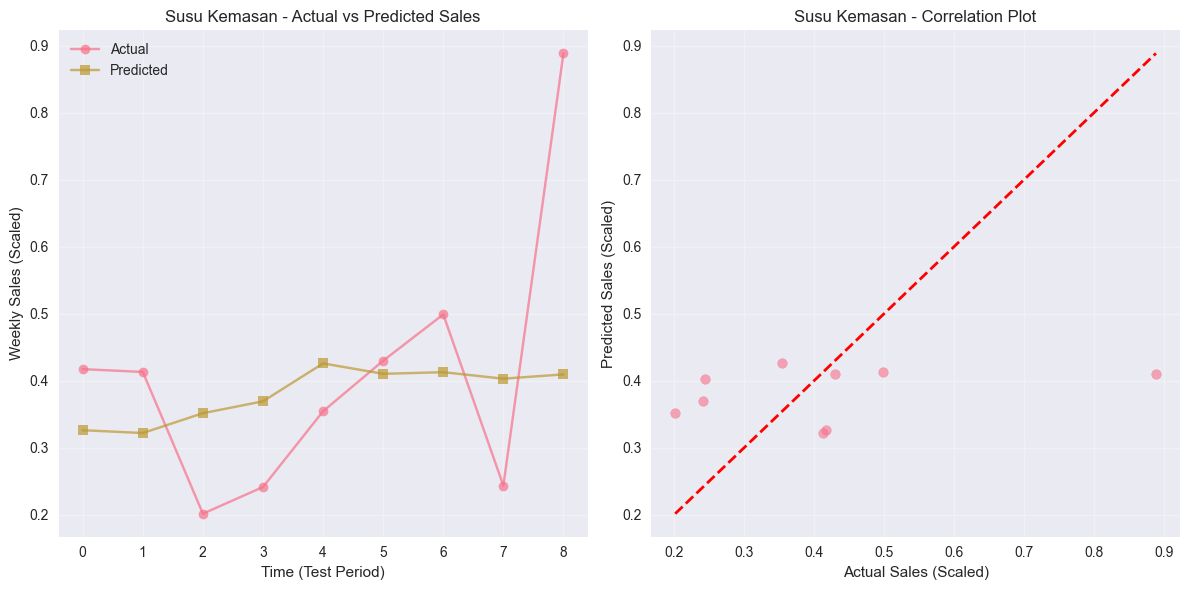

Plot saved to: results/plots/Susu Kemasan_predictions.png

Training LSTM model for category: Teh
Processing category: Teh
Data points for Teh: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Teh:


Model: "sequential_95"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Teh...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 869ms/step - loss: 0.2284 - mae: 0.4314 - val_loss: 0.2511 - val_mae: 0.4833
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 869ms/step - loss: 0.2284 - mae: 0.4314 - val_loss: 0.2511 - val_mae: 0.4833
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.1957 - mae: 0.3897 - val_loss: 0.2159 - val_mae: 0.4452
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - loss: 0.1957 - mae: 0.3897 - val_loss: 0.2159 - val_mae: 0.4452
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.1632 - mae: 0.3437 - val_loss: 0.1777 - val_mae: 0.3999
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.1632 - mae: 0.3437 - val_loss: 0.1777 - val_mae: 0.3999
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1427 - mae: 0.3162 - val_loss: 0.1388 - val_mae: 0.3476
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.1427 - mae: 0.3162 - val_loss: 0.1388 - val_mae: 0.3476
Epoch 5/100
2/2 ━━━━━━━━━


Teh - Training Metrics:
  MSE: 0.0459
  RMSE: 0.2141
  MAE: 0.1708
  MAPE: 73.7085

Teh - Test Metrics:
  MSE: 0.0690
  RMSE: 0.2627
  MAE: 0.2007
  MAPE: 66.1970

Model saved to: models/lstm_model_Teh.h5
Scalers saved to: models/scaler_X_Teh.pkl, models/scaler_y_Teh.pkl


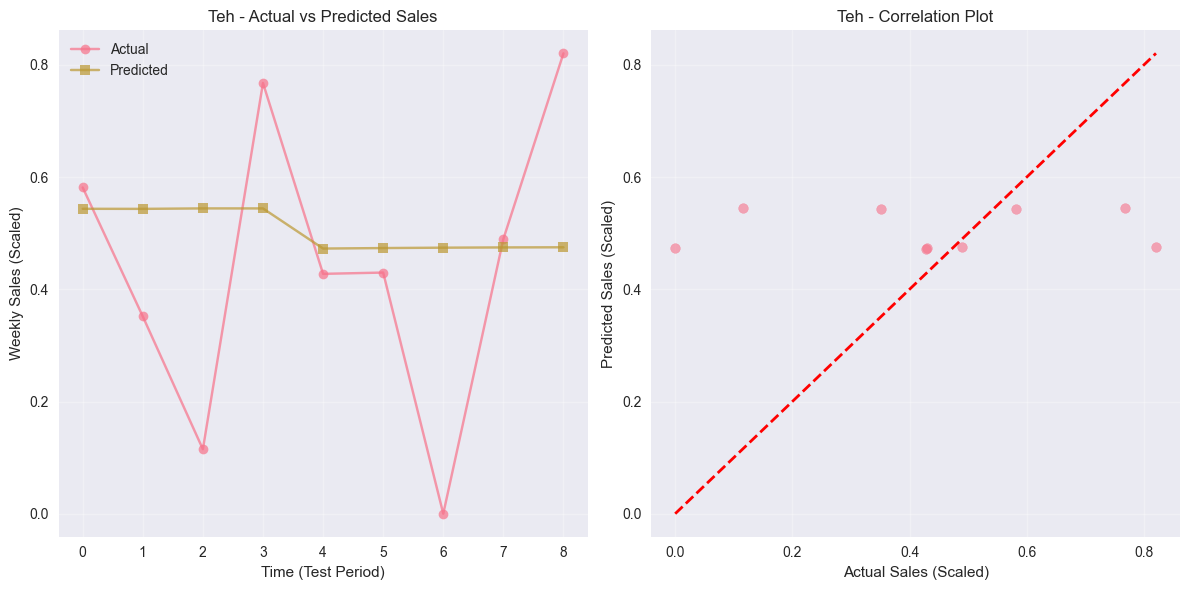

Plot saved to: results/plots/Teh_predictions.png

Training LSTM model for category: Telur
Processing category: Telur
Data points for Telur: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Telur:


Model: "sequential_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Telur...
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.1956 - mae: 0.3707 - val_loss: 0.4711 - val_mae: 0.6429
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - loss: 0.1956 - mae: 0.3707 - val_loss: 0.4711 - val_mae: 0.6429
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1562 - mae: 0.3184 - val_loss: 0.4286 - val_mae: 0.6087
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.1562 - mae: 0.3184 - val_loss: 0.4286 - val_mae: 0.6087
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1312 - mae: 0.2865 - val_loss: 0.3793 - val_mae: 0.5668
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - loss: 0.1312 - mae: 0.2865 - val_loss: 0.3793 - val_mae: 0.5668
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1244 - mae: 0.2778 - val_loss: 0.3236 - val_mae: 0.5184
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - loss: 0.1244 - mae: 0.2778 - val_loss: 0.3236 - val_mae: 0.5184
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1


Telur - Training Metrics:
  MSE: 0.0775
  RMSE: 0.2784
  MAE: 0.2311
  MAPE: 219.1579

Telur - Test Metrics:
  MSE: 0.0441
  RMSE: 0.2101
  MAE: 0.1485
  MAPE: 647.5622

Model saved to: models/lstm_model_Telur.h5
Scalers saved to: models/scaler_X_Telur.pkl, models/scaler_y_Telur.pkl


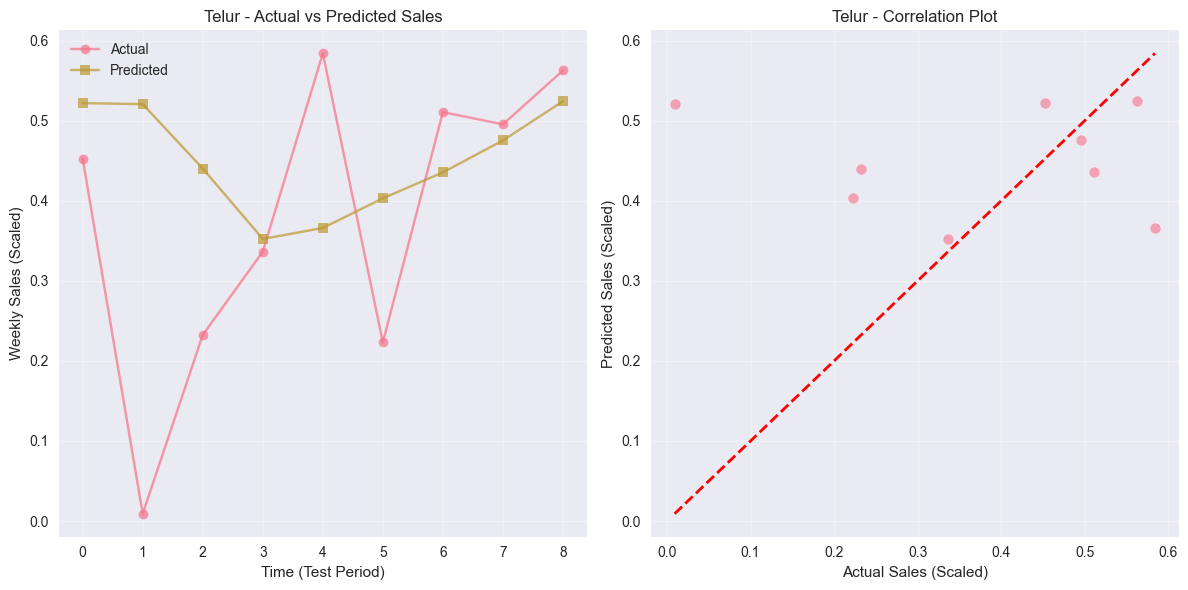

Plot saved to: results/plots/Telur_predictions.png

Training LSTM model for category: Yogurt
Processing category: Yogurt
Data points for Yogurt: 52
Sequence shape: X=(44, 8, 5), y=(44, 1)
Train set: X=(35, 8, 5), y=(35, 1)
Test set: X=(9, 8, 5), y=(9, 1)

Model architecture for Yogurt:


Model: "sequential_97"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 8, 64)          │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,881 (120.63 KB)

 Trainable params: 30,881 (120.63 KB)

 Non-trainable params: 0 (0.00 B)


Training model for Yogurt...
Epoch 1/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 882ms/step - loss: 0.2994 - mae: 0.5097 - val_loss: 0.0937 - val_mae: 0.2667
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 882ms/step - loss: 0.2994 - mae: 0.5097 - val_loss: 0.0937 - val_mae: 0.2667
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.2717 - mae: 0.4842 - val_loss: 0.0735 - val_mae: 0.2245
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - loss: 0.2717 - mae: 0.4842 - val_loss: 0.0735 - val_mae: 0.2245
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2373 - mae: 0.4464 - val_loss: 0.0416 - val_mae: 0.1617
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.2373 - mae: 0.4464 - val_loss: 0.0416 - val_mae: 0.1617
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1685 - mae: 0.3677 - val_loss: 0.0247 - val_mae: 0.1346
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.1685 - mae: 0.3677 - val_loss: 0.0247 - val_mae: 0.1346
Epoch 5/100
2/2 ━━━━━━


Yogurt - Training Metrics:
  MSE: 0.0863
  RMSE: 0.2937
  MAE: 0.2474
  MAPE: 57.2822

Yogurt - Test Metrics:
  MSE: 0.1283
  RMSE: 0.3582
  MAE: 0.2970
  MAPE: 148.7791

Model saved to: models/lstm_model_Yogurt.h5
Scalers saved to: models/scaler_X_Yogurt.pkl, models/scaler_y_Yogurt.pkl


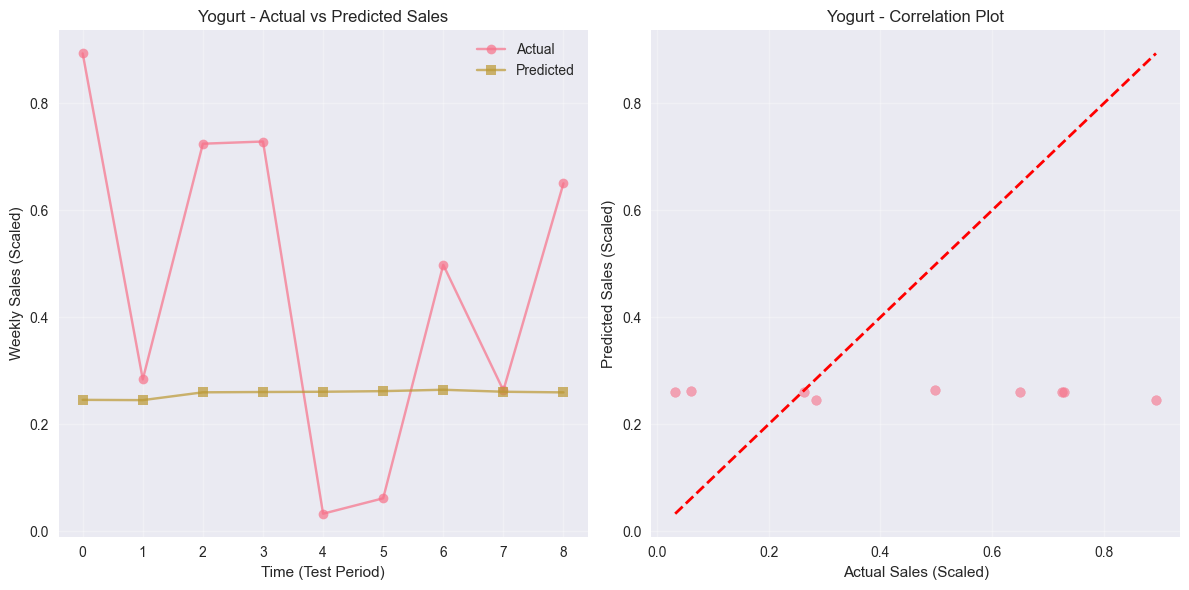

Plot saved to: results/plots/Yogurt_predictions.png


In [19]:
# Main execution - Train models for all categories
def train_all_categories(df, lookback=8, epochs=100, patience=10):
    """
    Train LSTM models for all categories in the dataset
    
    Args:
        df (pd.DataFrame): Preprocessed dataset
        lookback (int): Number of previous weeks to use as input
        epochs (int): Maximum number of training epochs
        patience (int): Early stopping patience
    
    Returns:
        dict: Results for all categories
    """
    categories = df['category'].unique()
    results = {}
    
    print(f"Found {len(categories)} categories: {list(categories)}")
    print(f"Training parameters: lookback={lookback}, epochs={epochs}, patience={patience}")
    
    for category in categories:
        result = train_and_evaluate_model(df, category, lookback, epochs, patience)
        if result is not None:
            results[category] = result
    
    return results

# Execute training for all categories
print("Starting LSTM model training for all categories...")
results = train_all_categories(df_processed, lookback=8, epochs=100, patience=10)

In [20]:
# Results summary and analysis
def summarize_results(results):
    """
    Create a summary of all model results
    
    Args:
        results (dict): Results from all trained models
    """
    if not results:
        print("No successful model training results to summarize.")
        return
    
    print(f"\n{'='*80}")
    print("SUMMARY OF ALL LSTM MODELS")
    print(f"{'='*80}")
    
    # Create summary DataFrame
    summary_data = []
    for category, result in results.items():
        if result is not None:
            test_metrics = result['test_metrics']
            summary_data.append({
                'Category': category,
                'Test MSE': test_metrics['MSE'],
                'Test RMSE': test_metrics['RMSE'],
                'Test MAE': test_metrics['MAE'],
                'Test MAPE (%)': test_metrics['MAPE']
            })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        print(summary_df.to_string(index=False, float_format='%.4f'))
        
        # Find best performing model
        best_category = summary_df.loc[summary_df['Test RMSE'].idxmin(), 'Category']
        print(f"\nBest performing model (lowest RMSE): {best_category}")
        
        # Average metrics
        print(f"\nAverage Test Metrics across all categories:")
        for col in ['Test MSE', 'Test RMSE', 'Test MAE', 'Test MAPE (%)']:
            print(f"  {col}: {summary_df[col].mean():.4f}")
    
    print(f"\nModels and scalers saved in:")
    print(f"  - Models: ./models/")
    print(f"  - Plots: ./results/plots/")

# Summarize results
summarize_results(results)


SUMMARY OF ALL LSTM MODELS
        Category  Test MSE  Test RMSE  Test MAE  Test MAPE (%)
     Air Mineral    0.0535     0.2314    0.2065        38.8663
           Beras    0.0533     0.2308    0.1724       216.0591
           Bihun    0.0467     0.2160    0.1755        58.4165
         Biskuit    0.0518     0.2275    0.1733        54.9054
     Buah Kering    0.0510     0.2259    0.1703        33.0949
     Buah-Buahan    0.1065     0.3263    0.2786        37.9264
         Cokelat    0.0530     0.2303    0.1989        47.0982
    Daging Segar    0.0478     0.2187    0.1981        51.1972
           Garam    0.0470     0.2167    0.1521        43.1460
            Gula    0.0809     0.2844    0.2347       120.3819
          Gulali    0.0603     0.2455    0.1852        25.7384
       Ice Cream    0.0830     0.2882    0.2332       117.0901
     Jus Kemasan    0.0528     0.2297    0.1870        22.6234
          Kacang    0.0364     0.1908    0.1639        25.9055
     Kaldu Jamur    0.0736 

In [ ]:
# Model loading and prediction functions - UPDATED for new features
def load_trained_model(category):
    """
    Load a trained model and its scalers
    
    Args:
        category (str): Product category
    
    Returns:
        tuple: (model, scaler_X, scaler_y)
    """
    try:
        # Load model
        model_path = f'models/lstm_model_{category}.h5'
        model = load_model(model_path)
        
        # Load scalers
        scaler_X_path = f'models/scaler_X_{category}.pkl'
        scaler_y_path = f'models/scaler_y_{category}.pkl'
        
        with open(scaler_X_path, 'rb') as f:
            scaler_X = pickle.load(f)
        with open(scaler_y_path, 'rb') as f:
            scaler_y = pickle.load(f)
        
        print(f"Successfully loaded model and scalers for {category}")
        return model, scaler_X, scaler_y
    
    except Exception as e:
        print(f"Error loading model for {category}: {str(e)}")
        return None, None, None

def predict_next_week(model, scaler_X, scaler_y, recent_data):
    """
    Predict next week's sales using trained model
    UPDATED: Works with features [week, promo_active, normal_price, promo_price]
    
    Args:
        model: Trained LSTM model
        scaler_X: Fitted feature scaler
        scaler_y: Fitted target scaler
        recent_data (np.array): Recent 8 weeks of feature data (shape: [8, 4])
    
    Returns:
        float: Predicted sales value (inverse transformed)
    """
    try:
        # Validate input shape
        if recent_data.shape[1] != 4:
            raise ValueError(f"Expected 4 features [week, promo_active, normal_price, promo_price], got {recent_data.shape[1]}")
        
        # Scale the input data
        recent_data_scaled = scaler_X.transform(recent_data)
        
        # Reshape for LSTM input (1, timesteps, features)
        recent_data_scaled = recent_data_scaled.reshape(1, recent_data_scaled.shape[0], recent_data_scaled.shape[1])
        
        # Make prediction
        prediction_scaled = model.predict(recent_data_scaled, verbose=0)
        
        # Inverse transform to get actual sales value
        prediction = scaler_y.inverse_transform(prediction_scaled)
        
        return prediction[0][0]
    
    except Exception as e:
        print(f"Error making prediction: {str(e)}")
        return None

def prepare_prediction_data(category_data, lookback=8):
    """
    Prepare recent data for prediction using only the specified features
    
    Args:
        category_data (pd.DataFrame): Historical data for category
        lookback (int): Number of weeks to use for prediction
    
    Returns:
        np.array: Feature array ready for prediction
    """
    # Use only the specified feature columns
    feature_columns = ['week', 'promo_active', 'normal_price', 'promo_price']
    
    # Get the most recent data
    recent_data = category_data.tail(lookback)[feature_columns].values
    
    print(f"Prepared prediction data shape: {recent_data.shape}")
    print(f"Features used: {feature_columns}")
    
    return recent_data

# Example usage (commented out - uncomment to use):
# # Load a specific model for predictions
# category_to_predict = list(results.keys())[0] if results else None
# if category_to_predict:
#     model, scaler_X, scaler_y = load_trained_model(category_to_predict)
#     if model is not None:
#         print(f"Model for {category_to_predict} loaded successfully!")
#         
#         # Prepare prediction data
#         category_data = df_processed[df_processed['category'] == category_to_predict]
#         recent_data = prepare_prediction_data(category_data)
#         
#         # Make prediction
#         prediction = predict_next_week(model, scaler_X, scaler_y, recent_data)
#         print(f"Next week sales prediction: {prediction:.0f}")

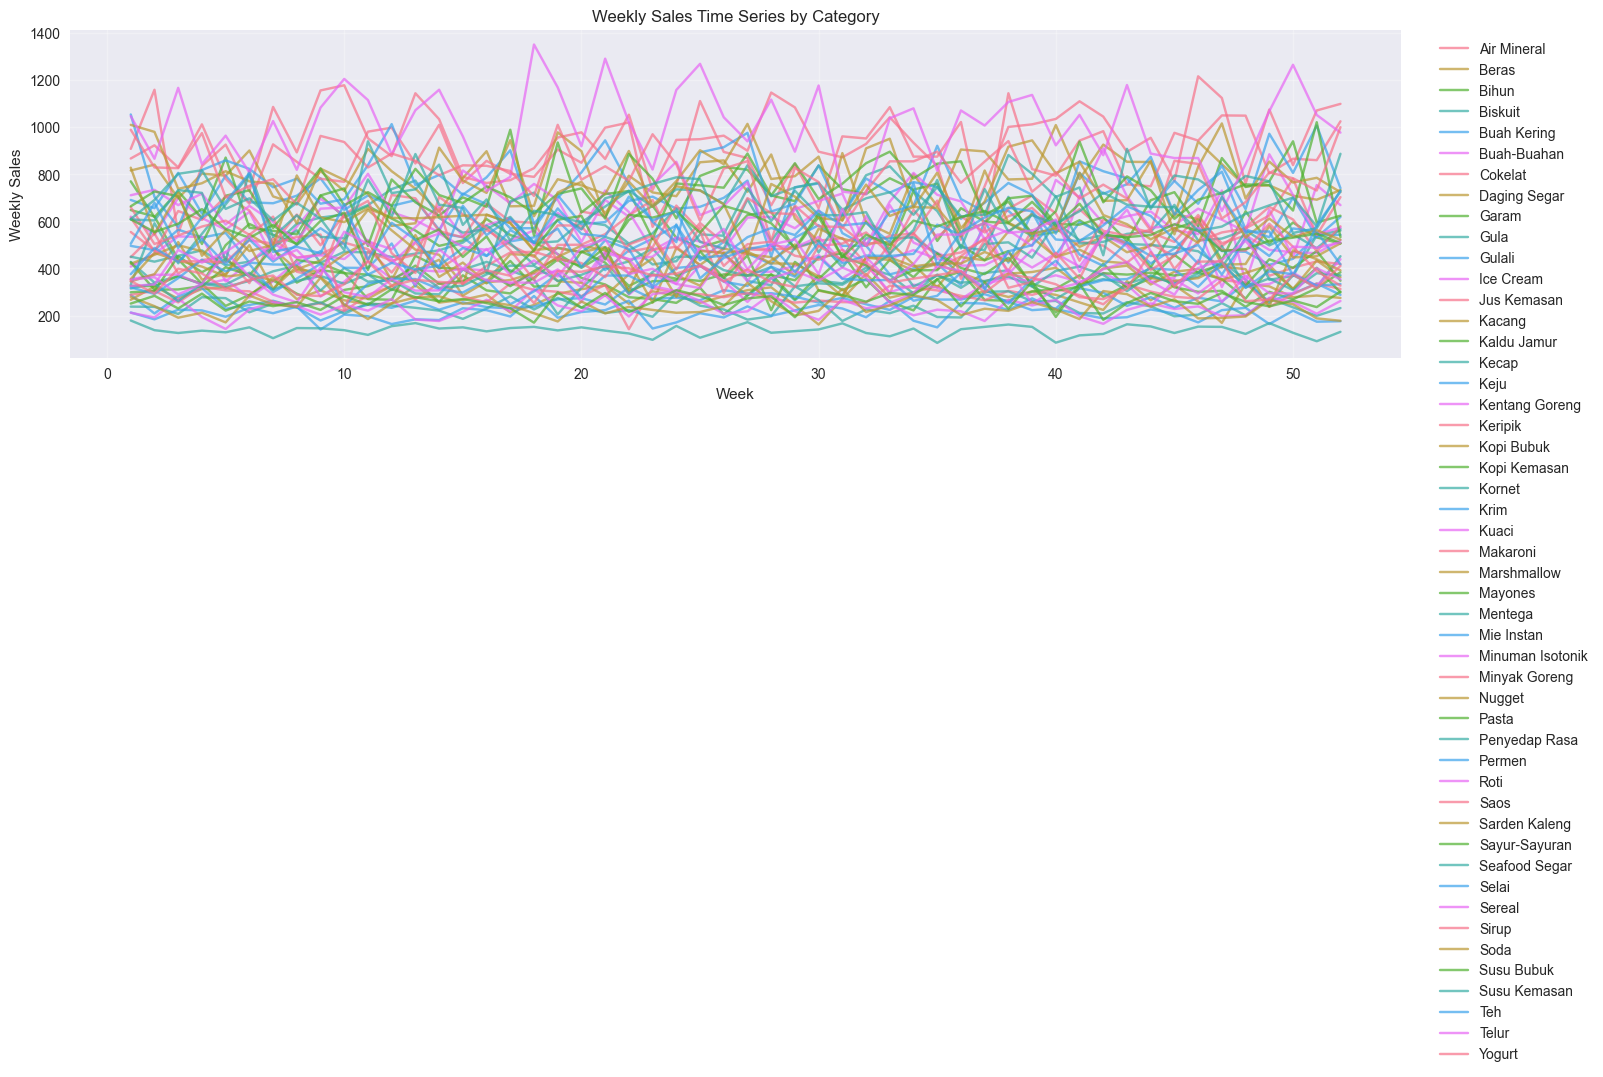

In [22]:
# Plot time series of weekly sales for each category
plt.figure(figsize=(16, 8))
for category in df_processed['category'].unique():
    category_data = df_processed[df_processed['category'] == category]
    plt.plot(category_data['week'], category_data['weekly_sales'], label=category, alpha=0.7)

plt.title('Weekly Sales Time Series by Category')
plt.xlabel('Week')
plt.ylabel('Weekly Sales')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary and Next Steps

### What This Notebook Does:

1. **Data Loading & Preprocessing**: 
   - Loads the sales dataset
   - Handles missing values in promo_price
   - Sorts data by category and week
   - Converts boolean features to numeric

2. **LSTM Model Training**:
   - Creates separate models for each product category
   - Uses 8-week lookback window for predictions
   - Includes features: sku_count, brand_count, promo_active, normal_price, promo_price
   - Implements early stopping to prevent overfitting

3. **Model Architecture**:
   - 2 LSTM layers (64 and 32 units)
   - Dropout layers for regularization
   - Dense layers for final prediction
   - Adam optimizer with MSE loss

4. **Evaluation & Saving**:
   - Calculates MSE, RMSE, MAE, MAPE metrics
   - Saves trained models as .h5 files
   - Saves scalers as .pkl files
   - Generates prediction plots

### Files Created:
- `models/lstm_model_<category>.h5` - Trained models
- `models/scaler_X_<category>.pkl` - Feature scalers
- `models/scaler_y_<category>.pkl` - Target scalers
- `results/plots/<category>_predictions.png` - Prediction plots

### How to Use for Predictions:
1. Load a trained model using `load_trained_model(category)`
2. Use `predict_next_week()` with 8 weeks of recent data
3. The prediction will be automatically inverse-transformed to actual sales values

The models are now ready for production use!

In [ ]:
# VALIDATION: Test the reconfigured model with updated features
print("="*80)
print("VALIDATING RECONFIGURED LSTM MODEL")
print("Features: week, promo_active, normal_price, promo_price")
print("="*80)

# Check available categories
available_categories = df_processed['category'].unique()
print(f"Available categories: {list(available_categories)}")

# Test with first available category
test_category = available_categories[0]
print(f"\nTesting reconfigured model with category: {test_category}")

try:
    # Test data preparation with new features
    X_train, X_test, y_train, y_test, scaler_X, scaler_y = prepare_data_for_lstm(
        df_processed, test_category, lookback=8
    )
    
    print(f"\n✅ Data preparation successful!")
    print(f"   - Training data shape: {X_train.shape}")
    print(f"   - Features per timestep: {X_train.shape[2]} (expected: 4)")
    print(f"   - Test data shape: {X_test.shape}")
    
    # Test model architecture
    input_shape = (X_train.shape[1], X_train.shape[2])
    test_model = build_lstm_model(input_shape)
    
    print(f"\n✅ Model architecture validation:")
    print(f"   - Input shape: {input_shape}")
    print(f"   - Expected: (8, 4) for 8 timesteps and 4 features")
    
    # Test prediction data preparation
    category_data = df_processed[df_processed['category'] == test_category]
    recent_data = prepare_prediction_data(category_data, lookback=8)
    
    print(f"\n✅ Prediction data preparation successful!")
    print(f"   - Recent data shape: {recent_data.shape}")
    print(f"   - Expected shape: (8, 4)")
    
    # Validate feature columns are correct
    expected_features = ['week', 'promo_active', 'normal_price', 'promo_price']
    feature_columns = ['week', 'promo_active', 'normal_price', 'promo_price']
    
    if expected_features == feature_columns:
        print(f"\n✅ Feature validation successful!")
        print(f"   - Using correct features: {feature_columns}")
    else:
        print(f"\n❌ Feature validation failed!")
        print(f"   - Expected: {expected_features}")
        print(f"   - Current: {feature_columns}")
    
    # Show sample of the data being used
    print(f"\n📊 Sample of training data (first 3 rows of features):")
    sample_category_data = df_processed[df_processed['category'] == test_category].head(10)
    print(sample_category_data[['week', 'category', 'promo_active', 'normal_price', 'promo_price', 'weekly_sales']])
    
    print(f"\n🎯 VALIDATION COMPLETE - Model ready for retraining!")
    
except Exception as e:
    print(f"\n❌ Validation failed: {str(e)}")
    print("Please check the data preparation function.")

In [ ]:
# RETRAIN MODELS with updated feature configuration
print("="*80)
print("RETRAINING LSTM MODELS WITH NEW FEATURES")
print("Features: week, promo_active, normal_price, promo_price")
print("="*80)

# Create backup directory for old models (optional)
backup_dir = 'models_backup'
if os.path.exists('models') and not os.path.exists(backup_dir):
    import shutil
    shutil.copytree('models', backup_dir)
    print(f"📁 Backed up old models to: {backup_dir}")

# Retrain all models with new configuration
print("\n🚀 Starting model retraining with updated features...")
results_new = train_all_categories(df_processed, lookback=8, epochs=100, patience=10)

# Summarize new results
print("\n" + "="*80)
print("RETRAINING COMPLETE - NEW MODEL SUMMARY")
print("="*80)
summarize_results(results_new)

# Validate that models are working with new features
print("\n" + "="*80)
print("POST-TRAINING VALIDATION")
print("="*80)

if results_new:
    # Test prediction with the first retrained model
    test_category = list(results_new.keys())[0]
    print(f"\n🧪 Testing prediction with retrained model: {test_category}")
    
    # Load the newly trained model
    model, scaler_X, scaler_y = load_trained_model(test_category)
    
    if model is not None:
        # Prepare test data
        category_data = df_processed[df_processed['category'] == test_category]
        recent_data = prepare_prediction_data(category_data, lookback=8)
        
        # Make a test prediction
        prediction = predict_next_week(model, scaler_X, scaler_y, recent_data)
        
        if prediction is not None:
            print(f"✅ Test prediction successful: {prediction:.0f}")
            print(f"✅ Model is working correctly with new features!")
            
            # Show what features were used
            feature_names = ['week', 'promo_active', 'normal_price', 'promo_price']
            print(f"\n📊 Last week's input features used:")
            last_week_data = recent_data[-1]
            for i, feature in enumerate(feature_names):
                print(f"   - {feature}: {last_week_data[i]}")
        else:
            print("❌ Test prediction failed!")
    else:
        print("❌ Could not load retrained model!")
else:
    print("❌ No models were successfully retrained!")